MINE-4101: Applied Data Science  
Univerisdad de los Andes  
Edgar Javier Toquica Gahona

**Dataset:** El dataset corresponde a más de 60.000 registros de la Fundación Canguro en donde se incluyen datos médicos longitudinales y de caracterización de los pacientes, recolectados durante más de 15 años.

**Contexto de Negocio:** La Fundación Canguro promueve y supervisa la aplicación del Método Madre Canguro Integral, recolectando datos principalmete de bebés de bajo peso y prematuros hasta los 12 meses de edad corregida. La investigación busca encontrar factores de riesgo que afecten el neurodesarrollo principalmente en el aspecto cognitivo y motor, además de visualizar el impacto de los componentes del Método Madre Canguro sobre los aspectos de neurodesarrollo mencionados.

Junto con la Fundación, fueron definidas las variables que determinan el desarrollo neuromotor e cognitivo. Ambas variables categoricas: infanib12m para el desarrollo neuromotor, con valores 1 para normal, 2 para transitorio y 3 para anormal.
IQ12cat para el desarrollo cognitivo, con valores 1 para normal y 0 para no normal.

Última actualización: Nov, 2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings
import locale
import joblib
import shap

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pandas.api.types import is_integer_dtype, is_float_dtype, is_numeric_dtype

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    make_scorer,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    recall_score, precision_score, f1_score, roc_auc_score
)

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Recolección de datos y características del dataset

In [2]:
fulldataset = pd.read_csv("KMC-70k-93-2024-Obes 19-conVel-DATA-SPSS-20250322V1.csv", low_memory=False)
pd.set_option("display.max_columns", None)
fulldataset.head()

,Idenfinal,Iden_Codigo,Iden_Sede,periodosanalisis,Sistemadeaseguramiento,Iden_embarazoMultiple,Iden_FechaParto,CSP_SituaPareja,CSP_TipoVivienda,CSP_EscolaridadMadre,CSP_SituacionLaboralMadre,CSP_EscolaridadPadre,CSP_SituacionLaboralPadre,CSP_IngresoMensual,CSP_DistanciaVivienda,CSP_numPersVivenIngMen,CSP_Menores5vivenMadre,CSP_NutricionFam,CSP_EmbarazoDeseado,CSP_MesTabajoEmba,CSP_AyudaPerm1mes,CP_PesoMadre,CP_TallaMadre,CP_tallamadremetro,BMImadre,BMImadrecat,CP_PesoPadre,CP_TallaPadre,CP_tallapadremetro,BMIpadre,BMIpadrecat,CP_TotalCPN,CP_ARO,CP_EnfermeraJefe,CP_MedGeneral,CP_Hormonales,CP_DIU,CP_MesInicCP,CP_SA_Sangrado,CP_SA_InfUrinaria,CP_SA_InfGineco,CP_SA_Anemia,CP_SA_EnfRespiratoria,CP_SA_RPM,CP_SA_APP,CP_SA_Preclampsia,CP_EstuvoHosp,CP_HospitalizacionesPreParto,CP_rhMadre,CP_MadreAlcohol,CP_MadreDrogas,CP_MadreFumo,CP_HospitalizacionEmbarazoAccidentes,CP_HospitalizacionEmbarazoAnemia,CP_HospitalizacionEmbarazoEnfermedadRespiratoria,CP_HospitalizacionEmbarazoAPP,CP_HospitalizacionEmbarazoPreeclampsia,CP_HospitalizacionEmbarazoEclampsia,CP_HospitalizacionEmbarazoInfeccionGinecologica,CP_HospitalizacionEmbarazoInfeccionUrinaria,CP_HospitalizacionEmbarazoSangrado,CP_TP_Orina,CP_TP_Rubeola,CP_TP_Toxoplasmosis,CP_TP_Sifilis,CP_TP_HIV,CP_TP_HepatitisB,CP_Medicamentos,CP_NumEcografias,CP_EcoPrimerTrimestre,CP_edadmaterna,PA_LugarNacimiento,PA_DuracionRPM,PA_AtendioParto,PA_DuracionTraParto,PA_TipoParto,PA_PresentacionNino,PA_MovimientoDisminuido,PA_SufrimientoFetalAgudo,PA_LiqAmnioticoMeconiado,PA_RitmoCardiaco,PA_Monitoreo,PA_NumDosisCorticoides,PA_ComplicacionsPartoPlacentaPrevia,PA_ComplicacionsPartoAbrupcio,PA_ComplicacionsPartoMultiples,PA_ComplicacionsPartoPatologIaCordOn,PA_ComplicacionsPartoPreeclampsia,PA_ComplicacionsPartoEclampsia,PA_ComplicacionsPartoAmnionitis,PA_ComplicacionsPartoSindromedehellp,PA_DiasHospiMadre,PA_DiasUCIMadre,PA_EstActualMadre,ERN_AdaptNeonatal,ERN_Peso,ERN_Talla0,ERN_Talla,ERN_Sexo,ERN_PC,RCIUpeso,RCIUtalla,RCIUpesoytallanacer,RCIUPC,pesotalla0,ERN_FUM,edadgestaFUM,ERN_Ballard,zscorepesotalla0,zscorepesotalla0cat,zscorepeso0,zscorepeso0cat,zscoretalla0,zscoretalla0cat,zscorePC0,zscorePC0cat,ERN_LubchencoFenton,ERN_A_1min,ERN_A_5min,ERN_A_10min,ERN_Remision,HD_FechaEntrada,HD_FechaSalida,HD_DiasVenMecanica,HD_DiasVenNoInvasiva,HD_DiasOxigeno,HD_DiasCanulaNasa,HD_DiasFototerapia,HD_DiasCamaraCefalica,HD_DiasIncubadora,HD_DiasAlimentacionPar,HD_DiasUCI,HD_DiasURN,HD_DiasAlojamiento,HD_TotalDiasHospital,HD_ExamenesEcografiacerebral,HD_ExamenesEcocardiograma,HD_ExamenesExamendeorina,HD_ExamenesRubeola,HD_ExamenesToxoplasmosis,HD_ExamenesSifilis,HD_ExamenesHIV,HD_ExamenesHepatitisB,HD_ExamenesGenetico,HD_ExamenesRMICerebral,HD_ExamenesTSH_Tiroides,HD_DosisSurfactante,HD_CicloAntibio,HD_DosisAmino,HD_CiclosUltimaLinea,HD_CiclosOtroAntibio,HD_RhNino,HD_NumTrasSanguineas,HD_FechaUltimaTrans,HD_UltiValorHematocrito,HD_UltimValorHemaglobina,HD_ValorMasAltoBilirubina,HD_C_HemorragiaIntra,HD_C_Hipoglicemia,HD_C_Apnea,HD_C_Ictericia,HD_C_ExamenNeurologico,HD_C_Convulsiones,HD_C_DisplasiaBronco,HD_C_OxigenoDependencia,HD_PesoSalida,HD_TipoAlimentacionS,AC_LugarAC,AC_DiasPosCanguro,AC_MaxHorasLogroCargar,AC_AdapSeno,AC_ExtraSeno,AC_AdmGoteo,AC_UnidadAbierta,AC_MadreAmamanta,AC_CansaNinoChupando,AC_EntrenoOtroCuidador,AC_RecibioChupo,AC_CirujiaSeno,AC_SoportePosicionC,AC_ApoyoLactancia,AC_EnsePosCangu,AC_SillaIncubadora,V7a,V7,V8,V10,V10D,V10A,V10B,V10C,VAR00003,ANOCAT,ANOCAT2ISS,educmadresimplificada,educpadresimplificada,ERN_sepsis,HD_C_GradoHIV,Sufrimientofetalcronico,tuvotransfusiones,edadmatcat,toxemia,ecocat,apgarcat1,apgarcat5,pesocat,gestacat,ninosmenosde5anos,UCI,ALIMENTAPARENTERAL,INFECCIONOSOCOMIAL,cesarea,BPN,PESO1500G,V195B,Nearterm,controlcat,pdpcat,primipara,trimestre,anemiamadre,HD_Infecciones,recibioantibioticos,RELACIONAROSOBRETOTALCONSULTAS,AROCAT02,anoxia5mn,problemaneurologico,menosde31sem,menosde1001,tipoventilacion,ventilacionsola,cpapsola,ventilacionmixta,UCIsinsoporteventilatorio,cor

In [3]:
fulldataset.shape

(64801, 753)

In [4]:
sorted_columns = sorted(fulldataset.columns)
for col in sorted_columns:
    print(col)

AC_AdapSeno
AC_AdmGoteo
AC_ApoyoLactancia
AC_CansaNinoChupando
AC_CirujiaSeno
AC_DiasPosCanguro
AC_EnsePosCangu
AC_EntrenoOtroCuidador
AC_ExtraSeno
AC_LugarAC
AC_MadreAmamanta
AC_MaxHorasLogroCargar
AC_RecibioChupo
AC_SillaIncubadora
AC_SoportePosicionC
AC_UnidadAbierta
ALIMENTAPARENTERAL
ANOCAT
ANOCAT2ISS
AROCAT02
BMI1
BMI12
BMI2
BMImadre
BMImadrecat
BMInacermas2DE
BMIpadre
BMIpadrecat
BPN
CD12
CD6
CONSULT08
CONSULT09
CONSULT10
CONSULT11
CONSULT12
CP_ARO
CP_DIU
CP_EcoPrimerTrimestre
CP_EnfermeraJefe
CP_EstuvoHosp
CP_Hormonales
CP_HospitalizacionEmbarazoAPP
CP_HospitalizacionEmbarazoAccidentes
CP_HospitalizacionEmbarazoAnemia
CP_HospitalizacionEmbarazoEclampsia
CP_HospitalizacionEmbarazoEnfermedadRespiratoria
CP_HospitalizacionEmbarazoInfeccionGinecologica
CP_HospitalizacionEmbarazoInfeccionUrinaria
CP_HospitalizacionEmbarazoPreeclampsia
CP_HospitalizacionEmbarazoSangrado
CP_HospitalizacionesPreParto
CP_MadreAlcohol
CP_MadreDrogas
CP_MadreFumo
CP_MedGeneral
CP_Medicamentos
CP_MesInicCP

### Variables que identifican los niños

In [5]:
fulldataset['Iden_Codigo'].value_counts()

Iden_Codigo
#NULL!    16
11111      5
19         4
59         4
60         4
          ..
16925      1
16948      1
16979      1
16999      1
17045      1
Name: count, Length: 27737, dtype: int64

In [6]:
fulldataset['Idenfinal'].value_counts()

Idenfinal
5001362    1
5001321    1
5001322    1
5001323    1
5001324    1
          ..
1000005    1
1000006    1
1000007    1
1000008    1
1000009    1
Name: count, Length: 64801, dtype: int64

**Duplicados**

No hay duplicados

In [7]:
vc = fulldataset['Idenfinal'].value_counts()
mask = fulldataset['Idenfinal'].map(vc) > 1

df_duplicados = fulldataset[mask]
df_duplicados

,Idenfinal,Iden_Codigo,Iden_Sede,periodosanalisis,Sistemadeaseguramiento,Iden_embarazoMultiple,Iden_FechaParto,CSP_SituaPareja,CSP_TipoVivienda,CSP_EscolaridadMadre,CSP_SituacionLaboralMadre,CSP_EscolaridadPadre,CSP_SituacionLaboralPadre,CSP_IngresoMensual,CSP_DistanciaVivienda,CSP_numPersVivenIngMen,CSP_Menores5vivenMadre,CSP_NutricionFam,CSP_EmbarazoDeseado,CSP_MesTabajoEmba,CSP_AyudaPerm1mes,CP_PesoMadre,CP_TallaMadre,CP_tallamadremetro,BMImadre,BMImadrecat,CP_PesoPadre,CP_TallaPadre,CP_tallapadremetro,BMIpadre,BMIpadrecat,CP_TotalCPN,CP_ARO,CP_EnfermeraJefe,CP_MedGeneral,CP_Hormonales,CP_DIU,CP_MesInicCP,CP_SA_Sangrado,CP_SA_InfUrinaria,CP_SA_InfGineco,CP_SA_Anemia,CP_SA_EnfRespiratoria,CP_SA_RPM,CP_SA_APP,CP_SA_Preclampsia,CP_EstuvoHosp,CP_HospitalizacionesPreParto,CP_rhMadre,CP_MadreAlcohol,CP_MadreDrogas,CP_MadreFumo,CP_HospitalizacionEmbarazoAccidentes,CP_HospitalizacionEmbarazoAnemia,CP_HospitalizacionEmbarazoEnfermedadRespiratoria,CP_HospitalizacionEmbarazoAPP,CP_HospitalizacionEmbarazoPreeclampsia,CP_HospitalizacionEmbarazoEclampsia,CP_HospitalizacionEmbarazoInfeccionGinecologica,CP_HospitalizacionEmbarazoInfeccionUrinaria,CP_HospitalizacionEmbarazoSangrado,CP_TP_Orina,CP_TP_Rubeola,CP_TP_Toxoplasmosis,CP_TP_Sifilis,CP_TP_HIV,CP_TP_HepatitisB,CP_Medicamentos,CP_NumEcografias,CP_EcoPrimerTrimestre,CP_edadmaterna,PA_LugarNacimiento,PA_DuracionRPM,PA_AtendioParto,PA_DuracionTraParto,PA_TipoParto,PA_PresentacionNino,PA_MovimientoDisminuido,PA_SufrimientoFetalAgudo,PA_LiqAmnioticoMeconiado,PA_RitmoCardiaco,PA_Monitoreo,PA_NumDosisCorticoides,PA_ComplicacionsPartoPlacentaPrevia,PA_ComplicacionsPartoAbrupcio,PA_ComplicacionsPartoMultiples,PA_ComplicacionsPartoPatologIaCordOn,PA_ComplicacionsPartoPreeclampsia,PA_ComplicacionsPartoEclampsia,PA_ComplicacionsPartoAmnionitis,PA_ComplicacionsPartoSindromedehellp,PA_DiasHospiMadre,PA_DiasUCIMadre,PA_EstActualMadre,ERN_AdaptNeonatal,ERN_Peso,ERN_Talla0,ERN_Talla,ERN_Sexo,ERN_PC,RCIUpeso,RCIUtalla,RCIUpesoytallanacer,RCIUPC,pesotalla0,ERN_FUM,edadgestaFUM,ERN_Ballard,zscorepesotalla0,zscorepesotalla0cat,zscorepeso0,zscorepeso0cat,zscoretalla0,zscoretalla0cat,zscorePC0,zscorePC0cat,ERN_LubchencoFenton,ERN_A_1min,ERN_A_5min,ERN_A_10min,ERN_Remision,HD_FechaEntrada,HD_FechaSalida,HD_DiasVenMecanica,HD_DiasVenNoInvasiva,HD_DiasOxigeno,HD_DiasCanulaNasa,HD_DiasFototerapia,HD_DiasCamaraCefalica,HD_DiasIncubadora,HD_DiasAlimentacionPar,HD_DiasUCI,HD_DiasURN,HD_DiasAlojamiento,HD_TotalDiasHospital,HD_ExamenesEcografiacerebral,HD_ExamenesEcocardiograma,HD_ExamenesExamendeorina,HD_ExamenesRubeola,HD_ExamenesToxoplasmosis,HD_ExamenesSifilis,HD_ExamenesHIV,HD_ExamenesHepatitisB,HD_ExamenesGenetico,HD_ExamenesRMICerebral,HD_ExamenesTSH_Tiroides,HD_DosisSurfactante,HD_CicloAntibio,HD_DosisAmino,HD_CiclosUltimaLinea,HD_CiclosOtroAntibio,HD_RhNino,HD_NumTrasSanguineas,HD_FechaUltimaTrans,HD_UltiValorHematocrito,HD_UltimValorHemaglobina,HD_ValorMasAltoBilirubina,HD_C_HemorragiaIntra,HD_C_Hipoglicemia,HD_C_Apnea,HD_C_Ictericia,HD_C_ExamenNeurologico,HD_C_Convulsiones,HD_C_DisplasiaBronco,HD_C_OxigenoDependencia,HD_PesoSalida,HD_TipoAlimentacionS,AC_LugarAC,AC_DiasPosCanguro,AC_MaxHorasLogroCargar,AC_AdapSeno,AC_ExtraSeno,AC_AdmGoteo,AC_UnidadAbierta,AC_MadreAmamanta,AC_CansaNinoChupando,AC_EntrenoOtroCuidador,AC_RecibioChupo,AC_CirujiaSeno,AC_SoportePosicionC,AC_ApoyoLactancia,AC_EnsePosCangu,AC_SillaIncubadora,V7a,V7,V8,V10,V10D,V10A,V10B,V10C,VAR00003,ANOCAT,ANOCAT2ISS,educmadresimplificada,educpadresimplificada,ERN_sepsis,HD_C_GradoHIV,Sufrimientofetalcronico,tuvotransfusiones,edadmatcat,toxemia,ecocat,apgarcat1,apgarcat5,pesocat,gestacat,ninosmenosde5anos,UCI,ALIMENTAPARENTERAL,INFECCIONOSOCOMIAL,cesarea,BPN,PESO1500G,V195B,Nearterm,controlcat,pdpcat,primipara,trimestre,anemiamadre,HD_Infecciones,recibioantibioticos,RELACIONAROSOBRETOTALCONSULTAS,AROCAT02,anoxia5mn,problemaneurologico,menosde31sem,menosde1001,tipoventilacion,ventilacionsola,cpapsola,ventilacionmixta,UCIsinsoporteventilatorio,cor

### Variables objetivo

In [8]:
fulldataset['IQ12cat'].value_counts()

IQ12cat
#NULL!    35408
1         23502
0          5891
Name: count, dtype: int64

In [9]:
fulldataset['infanib12m'].value_counts()

infanib12m
#NULL!    34710
1         28732
2           933
3           424
0             2
Name: count, dtype: int64

## Preparación de los datos


**Preparación de datos:** Reemplazamos las cadenas de texto que señalizan nulos e imputamos nulos NAN, a continuación limpiamos los registros que no cuentan con las variables objetivo determinadas. Posterior a esto nos aseguramos que las columnas sean del tipo correcto.

In [10]:
## Reemplazar strings por Nan
fulldataset.replace("#NULL!", np.nan, inplace=True)

In [11]:
#Quitar columnas de zscore
fulldataset = fulldataset.drop(columns=[c for c in fulldataset.columns if "zscore" in c])

In [12]:
#Solo conservar 1 ID
fulldataset.drop('Iden_Codigo', axis=1, inplace=True)

In [13]:
fulldataset.shape

(64801, 682)

In [14]:
#Bebes que cuentan con ambas variables objetivo
bebes_infanib12 = set(fulldataset.loc[fulldataset['infanib12m'].notna(), 'Idenfinal'])
bebes_iq12 = set(fulldataset.loc[fulldataset['IQ12cat'].notna(), 'Idenfinal'])
bebes_interseccion = bebes_infanib12.intersection(bebes_iq12)
print(f"Bebes con Infanib12 & Iq12: {len(bebes_interseccion)}")

Bebes con Infanib12 & Iq12: 26155


In [15]:
#Seleccionar bebes que cuentan con ambas variables
df_estudio = fulldataset[fulldataset['Idenfinal'].isin(bebes_interseccion)].copy()

In [16]:
df_estudio.shape

(26155, 682)

#### Transformación variables objetivo

In [17]:
df_estudio["infanib12m"].value_counts()

infanib12m
1    25110
2      715
3      330
Name: count, dtype: int64

In [18]:
# Copia segura de la columna original
y = df_estudio["infanib12m"].copy()

# Primero convertir la columna a numérica
y = pd.to_numeric(y, errors="coerce")

# Transformación de las categorias:
# 1 → 1 "Normal"
# 2,3 → 0 "Transitorio" y "Anormal"
# otras → NaN (opcional)
y_bin = y.map({
    1: 1,
    2: 0,
    3: 0
})

# Agregar la variable transformada de nuevo al dataset
df_estudio["infanib12m_bin"] = y_bin

# Verificación
print(df_estudio["infanib12m_bin"].value_counts(dropna=False))

infanib12m_bin
1    25110
0     1045
Name: count, dtype: int64


#### Transformación de variables temporales

In [19]:
#Columna con la fecha del parto
df_estudio['Iden_FechaParto'].unique()

array(['11-Mar-08', '18-Apr-08', '16-Apr-08', ..., '18-Sep-22',
       '19-Nov-22', nan], dtype=object)

In [20]:
locale.setlocale(locale.LC_TIME, 'C')  # 'C' = inglés neutro, compatible

df_estudio['Iden_FechaParto'] = pd.to_datetime(
    df_estudio['Iden_FechaParto'],
    format='%d-%b-%y',
    errors='coerce'
)

In [21]:
df_estudio['Iden_FechaParto'].describe()

count                            21575
mean     2016-06-19 07:39:35.916570112
min                2008-01-25 00:00:00
25%                2013-09-07 00:00:00
50%                2016-07-20 00:00:00
75%                2019-06-22 00:00:00
max                2023-01-03 00:00:00
Name: Iden_FechaParto, dtype: object

#### Transformación de las variables según el diccionario

In [22]:
df_vartype = pd.read_excel("KMC-70K-diccionarioVARS-JTH-PhETI-rev20250520-MINE.xlsx", sheet_name="VARS-(KMC70k)")
df_vartype.head()

,#consecutivo,NOMBRE EN LA BdeD,ID-VAR,VAR-SHORT DESCRIPTION,#Phase,ID-Phase,#Episode-1,ID-Episode-1,#Episode-2,ID-Episode-2,#Episode-3,ID-Episode-3,#TofI-1,id-TofI-1,VAR-LONG DESCRIPTION,VAR-TYPE-prim,VAR-TYPE-sec,UNITS,VAR-MIN-VALUE,VAR-MAX-VALUE,VAR-MISSING-VALUE,#TofI-2,id-TofI-2,TimeStamp? (NO/SI),CODIFICACION-CATEGORIAS,VAL1,SHORT-NAME1,VAL2,SHORT-NAME2,VAL3,SHORT-NAME3,VAL4,SHORT-NAME4,VAL5,SHORT-NAME5,VAL6,SHORT-NAME6,VAL7,SHORT-NAME7,VAL8,SHORT-NAME8,VAL9,SHORT-NAME9,VAL10,SHORT-NAME10,VAL11,SHORT-NAME11,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,TEMA DE INTERES 1,TEMA DE INTERES2,TEMA DE INTERES3,Unnamed: 54,Unnamed: 55,Unnamed: 56,*VAR-COMPUESTA
0,1.0,Iden_embarazoMultiple,CP_EmbarazoMultiple,si fue un embarazo multiple,0.0,caracterizacion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BOOLEAN,NaN,NaN,0,1,-1,NaN,NaN,NaN,NaN,0,NO,1.0,SI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,CP_Prematuro,CP_Prematuro,Numero de prematuros,0.0,caracterizacion,NaN,NaN,NaN,NaN,NaN,NaN,8.0,SEGUIMIENTO-VACUNAS-TAMIZ-MORT,Numero de prematuros,INTEGER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,Iden_Codigo,IDEN_Codigo,IdentificadorBebe,0.0,caracterizacion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTEGER,NaN,NaN,0,200000,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,Iden_Sede,IDEN_Sede,sede del PMC,0.0,caracterizacion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTEGER,NaN,NaN,1,4,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,Iden_FechaParto,PA_FechaParto,Fecha del parto,0.0,caracterizacion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DATE11,NaN,NaN,19950101,20501231,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Diccionario
dic = df_vartype[['NOMBRE EN LA BdeD', 'VAR-TYPE-prim']].dropna(subset=['NOMBRE EN LA BdeD']).copy()

In [24]:
# Limpieza mínima de espacios
dic['NOMBRE EN LA BdeD'] = dic['NOMBRE EN LA BdeD'].astype(str).str.strip()
df_estudio.columns = df_estudio.columns.astype(str).str.strip()

In [25]:
# columnas del DataFrame
cols_df = set(df_estudio.columns)
#columnas diccionario
cols_dict = set(dic['NOMBRE EN LA BdeD'])

# Columnas que están tanto en df como en el diccionario
cols_con_tipo = sorted(list(cols_df & cols_dict))

# Columnas en df pero NO en diccionario
cols_sin_tipo = sorted(list(cols_df - cols_dict))

# Variables en el diccionario que NO existen en df
cols_no_existen = sorted(list(cols_dict - cols_df))

print("━━━━━━━━ MATCH RESUMEN ━━━━━━━━")
print(f"Columnas totales en df:                 {len(cols_df)}")
print(f"Columnas en diccionario:                {len(cols_dict)}")
print("")
print(f"Columnas con tipo definido:           {len(cols_con_tipo)}")
print(f"Columnas en df SIN tipo definido:     {len(cols_sin_tipo)}")
print(f"En diccionario pero no en df:         {len(cols_no_existen)}")


━━━━━━━━ MATCH RESUMEN ━━━━━━━━
Columnas totales en df:                 683
Columnas en diccionario:                634

Columnas con tipo definido:           594
Columnas en df SIN tipo definido:     89
En diccionario pero no en df:         40


In [26]:
# Variables de df que sí tienen tipo en diccionario (con metadatos)
df_con_tipo = dic[dic['NOMBRE EN LA BdeD'].isin(cols_con_tipo)].copy()

# Variables de df sin tipo (no están en diccionario)
df_sin_tipo = pd.DataFrame({"col_df": cols_sin_tipo})

##### Funciones de transformación

In [27]:
#Variables que se omitiran en la transformación 
# de variables que no se encuentran en el diccionario

# IDs y fechas
id_vars = ["Idenfinal", "Iden_Codigo", "Iden_Sede", "Iden_FechaParto"]

# Targets (objetivo(s) del modelo)
target_vars = ["infanib12m_bin", "infanib12m", "IQ12cat"]

#Variables omitidas de transformacion
vars_protegidas = set(id_vars + target_vars)

In [28]:
#Funciones de transformación
YES = {"yes","y","true","t","1","si","sí","verdadero","v","s"}
NO  = {"no","n","false","f","0","falso"}

def safe_to_numeric(s: pd.Series, threshold: float = 0.9) -> pd.Series:
    """
    Convierte la serie a numérica si la mayoría de valores son numéricos o nulos.
    threshold: proporción mínima de valores 'aceptables' requerida (por defecto 90%).
    """

    # 1) Limpieza ligera de strings frecuentes
    s_clean = (s.astype(str).str.strip().replace({"": np.nan, "nan": np.nan, "NaN": np.nan,  "#NULL!": np.nan, 
                                                  "None": np.nan, "NA": np.nan, "<NA>": np.nan}))

    # 2) Intentar conversión a numérico
    converted = pd.to_numeric(s_clean, errors="coerce")

    # 3) Éxitos = numéricos (converted.notna()) o nulos originales
    mask_numeric = converted.notna()
    mask_missing = s_clean.isna()

    success_rate = (mask_numeric | mask_missing).mean()

    # 4) Si más del 90% de los valores son numéricos o nulos → convertir
    if success_rate >= threshold:
        return converted
    else:
        return s  # mantener como texto/categórica


def to_boolean(s: pd.Series) -> pd.Series:
    if s.dtype == bool:
        return s

    x = s.copy()

    # Si es numérica 0/1, usamos eso directo
    if pd.api.types.is_numeric_dtype(x):
        return x.astype('Int64').map({0: False, 1: True}).astype('boolean')

    # Pasar todo a str para mapear valores heterogéneos
    mask_notna = x.notna()
    x_str = x[mask_notna].astype(str).str.strip().str.lower()

    mapped = pd.Series(index=x.index, dtype="boolean")
    mapped.loc[mask_notna & x_str.isin(YES)] = True
    mapped.loc[mask_notna & x_str.isin(NO)]  = False

    return mapped.astype('boolean')


def to_integer(s: pd.Series) -> pd.Series:
    # Convierte limpiando símbolos frecuentes
    if s.dtype == 'O':
        s = s.str.replace(r'[^\d\-\+]', '', regex=True)
    return pd.to_numeric(s, errors='coerce').astype('Int64')  # entero “nullable”


def to_float(s: pd.Series) -> pd.Series:
    if s.dtype == 'O':
        # cambia comas por punto y retira símbolos
        s = (s.str.replace(',', '.', regex=False)
               .str.replace(r'[^\d\-\.+eE]', '', regex=True))
    return pd.to_numeric(s, errors='coerce').astype('Float32')


def to_datetime_guess(s: pd.Series) -> pd.Series:
    # DATE/DATE11: intentamos conversión flexible; ajusta dayfirst según tu caso
    return pd.to_datetime(s, format='%d/%m/%Y', errors='coerce')


def to_category(s: pd.Series) -> pd.Series:
    return s.astype('category')


def cast_by_type(s: pd.Series, tipo: str) -> pd.Series:
    t = str(tipo).upper()
    if 'BOOL' in t:
        return to_boolean(s)
    if 'INT' in t:
        return to_integer(s)
    if 'FLOAT' in t or 'DOUBLE' in t or 'REAL' in t or 'NUM' in t:
        return to_float(s)
    if 'DATE' in t or 'FECHA' in t or 'TIME' in t:
        return to_datetime_guess(s)
    if 'CHAR' in t or 'STRING' in t or 'TEXT' in t:
        return s.astype('string')
    # Categóricas
    if 'CATEG' in t:
        return to_category(s)
    return s

def norm_name(x):
    if pd.isna(x):
        return x
    s = str(x)

    # espacios y caracteres invisibles
    s = s.replace('\u00a0', ' ')  # no-breaking space
    s = s.replace('\t', ' ')
    s = s.strip()

    # mayúsculas
    s = s.upper()

    # reemplazar espacios por nada
    s = s.replace(' ', '')

    # permitir solo letras, números y _
    s = re.sub(r'[^A-Z0-9_]', '', s)

    return s


##### Transformación según el diccionario

In [29]:
columnas_no_casteadas = []
columnas_casteadas = []

for _, row in df_con_tipo.iterrows():
    col  = row['NOMBRE EN LA BdeD']   # este nombre existe en df_estudio
    tipo = row['VAR-TYPE-prim']

    try:
        df_estudio[col] = cast_by_type(df_estudio[col], tipo)
        columnas_casteadas.append(col)
    except Exception as e:
        print(f"[WARN] No se pudo castear {col} como {tipo}: {e}")
        columnas_no_casteadas.append(col)

print("━━━━━━━━ RESULTADO CASTING FINAL ━━━━━━━━")
print(f"Columnas casteadas correctamente:       {len(columnas_casteadas)}")
print(f"Columnas NO casteadas (por error real): {len(columnas_no_casteadas)}")
print("Ejemplos no casteadas:", columnas_no_casteadas[:15])

━━━━━━━━ RESULTADO CASTING FINAL ━━━━━━━━
Columnas casteadas correctamente:       594
Columnas NO casteadas (por error real): 0
Ejemplos no casteadas: []


#### Transformación de variables que no estan en el diccionario

In [30]:
columnas_casteadas_sin_tipo = []
columnas_no_casteadas_sin_tipo = []

for col in cols_sin_tipo:


    # OMITIR columnas protegidas (IDs, fechas y Targets)
    if col in vars_protegidas:
        columnas_no_casteadas_sin_tipo.append(col)
        continue

    s = df_estudio[col]


    # 1) Intento: convertir a boolean
    try:
        s_bool = to_boolean(s)
        # boolean conversion solo tiene sentido si hay True/False reales
        if s_bool.notna().mean() > 0:   # al menos 1 valor booleano real
            df_estudio[col] = s_bool
            columnas_casteadas_sin_tipo.append((col, "boolean"))
            continue
    except:
        pass

    # 2) Intento: convertir a fecha
    try:
        s_date = to_datetime_guess(s)
        # Si hay al menos 5% de fechas válidas, lo consideramos fecha
        if s_date.notna().mean() > 0.05:
            df_estudio[col] = s_date
            columnas_casteadas_sin_tipo.append((col, "datetime"))
            continue
    except:
        pass


    # 3) Intento: safe_to_numeric (numérica si ≥ 90%)
    try:
        s_num = safe_to_numeric(s, threshold=0.9)
        if pd.api.types.is_numeric_dtype(s_num):
            df_estudio[col] = s_num
            columnas_casteadas_sin_tipo.append((col, "numeric"))
            continue
    except:
        pass

    # 4) Resultado final: texto/categoría
    try:
        df_estudio[col] = s.astype("string")
        columnas_casteadas_sin_tipo.append((col, "string"))
    except:
        columnas_no_casteadas_sin_tipo.append(col)

print("━━━━━━━━ RESULTADOS CASTEO SIN DICCIONARIO ━━━━━━━━")
print(f"Columnas casteadas automáticamente: {len(columnas_casteadas_sin_tipo)}")
print(f"Columnas que no se pudieron castear: {len(columnas_no_casteadas_sin_tipo)}")
print("Ejemplos casteadas:", columnas_casteadas_sin_tipo[:10])
print("Ejemplos no casteadas:", columnas_no_casteadas_sin_tipo[:10])


━━━━━━━━ RESULTADOS CASTEO SIN DICCIONARIO ━━━━━━━━
Columnas casteadas automáticamente: 87
Columnas que no se pudieron castear: 2
Ejemplos casteadas: [('ANOCAT2ISS', 'boolean'), ('BMI1', 'numeric'), ('BMI12', 'numeric'), ('BMI2', 'numeric'), ('BMImadre', 'numeric'), ('BMImadrecat', 'boolean'), ('BMInacermas2DE', 'boolean'), ('BMIpadre', 'numeric'), ('BMIpadrecat', 'boolean'), ('CP_tallamadremetro', 'boolean')]
Ejemplos no casteadas: ['Idenfinal', 'infanib12m_bin']


In [31]:
cols_casteadas_sin_tipo = [col for col, tipo in columnas_casteadas_sin_tipo]
df_estudio[cols_casteadas_sin_tipo]

,ANOCAT2ISS,BMI1,BMI12,BMI2,BMImadre,BMImadrecat,BMInacermas2DE,BMIpadre,BMIpadrecat,CP_tallamadremetro,CP_tallapadremetro,Diasoxigenoambulatorio,EG1,EG40,EGEnt,ERN_Talla0,Gananciatallaentradatalla40sem,Gananciatallaentradatalla40semhosp,HD_C_GradoHIV,LBWI,Nutpadre,Overweightorobesity12m,PesosalidaPC,PrimaryLast,RCEUFentonentrada,RCIUpeso,RCIUpesoytallanacer,SGAprema,Sistemadeaseguramiento,V196BB,V219BB,V262BB,V305BB,V344B_AULEN,V344B_EJEC,V344B_LOC,V344B_OCUMAN,V344B_PSOC,V348BB,V390BB,V430B_AULEN,V430B_EJEC,V430B_LOC,V430B_OCUMAN,V430B_PSOC,V7a,VAR00003,VAR00004,VAR00005,VAR00006,algoLA12m,algoLA3m,algoLA40,algoLA6m,algoLA9m,edaddestete,edadgestaFUM,edadgestasalPC,edadsalidaPC,examenneuropsico12meses,filter_$,formulaversusLME3m,gananciapesoentradapeso40sem,gananciapesoentradapeso40semhosp,gananciapesonacerpesoentradaPMC,gananciapesonacerpesoentradaPMChosp,gananciatallanacertallaentradaPMC,gananciatallanacertallaentradaPMChosp,gesentcat,gestaentrada,gestaentradacat,gestasalsindecimales,hospenURN,mixtaversusLME3m,nutmadre,percapindicfinal,periodosanalisis,pesentcat,pesokilo12m,pesotalla0,preterm,primariamadre,tallametro12m,underweight12m,velocidad12_9mesesOMS,velocidad6_3mesesOMS,velocidad9_6mesesOMS
5049,<NA>,13.265306,20.368234,17.247623,NaN,<NA>,False,NaN,<NA>,<NA>,<NA>,<NA>,34.0,40,34.0,38.0,<NA>,<NA>,True,True,<NA>,True,2670.0,True,False,False,False,True,<NA>,42.0,47.0,58.0,66.0,NaN,NaN,NaN,NaN,NaN,73.0,76.5,NaN,NaN,NaN,NaN,NaN,11-Mar-08,True,28,1005052,NaN,True,True,True,True,True,<NA>,NaN,35.857143,<NA>,True,False,True,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,34.857143,<NA>,34.0,True,<NA>,<NA>,<NA>,<NA>,<NA>,11.92,7.693906,True,False,0.765,<NA>,-0.025448,0.557758,0.041930
5050,<NA>,10.827664,15.411700,14.981096,NaN,<NA>,False,NaN,<NA>,<NA>,<NA>,<NA>,35.0,40,35.0,43.0,<NA>,<NA>,<NA>,True,<NA>,False,2570.0,True,True,False,False,True,<NA>,42.0,46.0,54.0,61.0,NaN,NaN,NaN,NaN,NaN,66.0,70.5,NaN,NaN,NaN,NaN,NaN,18-Apr-08,True,34,1005053,NaN,True,False,False,True,True,<NA>,NaN,37.714286,<NA>,True,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,35.428571,<NA>,35.0,True,False,<NA>,<NA>,<NA>,<NA>,7.66,10.708491,True,False,0.705,False,0.179714,-0.567948,0.115305
5051,<NA>,9.512485,16.215952,12.903226,NaN,<NA>,False,NaN,<NA>,<NA>,<NA>,<NA>,34.0,40,34.0,43.0,<NA>,<NA>,<NA>,True,<NA>,False,2180.0,True,True,False,False,True,<NA>,43.5,46.5,56.0,63.5,NaN,NaN,NaN,NaN,NaN,68.5,71.5,NaN,NaN,NaN,NaN,NaN,16-Apr-08,True,33,1005054,NaN,False,False,False,False,False,<NA>,NaN,37.000000,<NA>,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,34.857143,<NA>,34.0,True,False,<NA>,<NA>,<NA>,<NA>,8.29,11.357491,True,False,0.715,False,0.184081,-0.162777,-0.440298
5054,<NA>,11.447893,19.308813,15.174983,NaN,<NA>,False,NaN,<NA>,<NA>,<NA>,<NA>,34.0,40,34.0,42.0,<NA>,<NA>,True,True,<NA>,False,2430.0,True,False,False,False,True,<NA>,45.5,50.5,62.0,68.0,NaN,NaN,NaN,NaN,NaN,73.5,76.5,NaN,NaN,NaN,NaN,NaN,01-Apr-08,True,30,1005057,NaN,True,True,True,True,True,<NA>,NaN,NaN,<NA>,False,False,True,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,34.428571,<NA>,34.0,True,<NA>,<NA>,<NA>,<NA>,<NA>,11.30,9.880952,True,True,0.765,False,0.279179,-2.479459,2.526489
5055,<NA>,12.592593,14.792388,NaN,NaN,<NA>,False,NaN,<NA>,<NA>,<NA>,<NA>,37.0,40,37.0,44.0,<NA>,<NA>,<NA>,True,<NA>,False,NaN,True,False,False,False,True,<NA>,45.0,NaN,NaN,60.5,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,NaN,NaN,NaN,18-Apr-08,True,35,1005058,NaN,True,<NA>,<NA>,True,<NA>,<NA>,NaN,NaN,<NA>,True,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,37.142857,<NA>,36.0,True,<NA>,<NA>,<NA>,<NA>,<NA>,6.84,11.415289,True,False,0.680,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64634,<NA>,12.201084,16.397566,11.998776

## Análisis datos faltantes

### Top columnas con más datos faltantes

In [32]:
# 1. Crear la serie de nulos a partir de df_estudio
nulos_series = df_estudio.isnull().sum()

# 2. Obtener el número total de filas del DataFrame original
total_filas = len(df_estudio)

# 3. Filtrar solo las columnas con nulos y ordenarlas
nulos_df = nulos_series[nulos_series > 0].sort_values(ascending=False).reset_index()

# 4. Renombrar las columnas para mayor claridad
nulos_df.columns = ['Columna', 'Conteo_Nulos']

# 5. Agregar la nueva columna con el total de datos (Total_Datos)
nulos_df['Total_Datos'] = total_filas

# Opcional: Agregar el porcentaje de nulos para una mejor visualización
nulos_df['Porcentaje_Nulos'] = (nulos_df['Conteo_Nulos'] / nulos_df['Total_Datos']) * 100

# 6. Mostrar las 20 columnas con más nulos
print("--- 20 Columnas con Mayor Cantidad de Nulos ---")
print(nulos_df.head(20))


--- 20 Columnas con Mayor Cantidad de Nulos ---
                Columna  Conteo_Nulos  Total_Datos  Porcentaje_Nulos
0                  V259         26155        26155        100.000000
1                  V271         26155        26155        100.000000
2               ERN_FUM         26155        26155        100.000000
3       HD_FechaEntrada         26155        26155        100.000000
4                  V195         26155        26155        100.000000
5                  V302         26155        26155        100.000000
6                 V195A         26155        26155        100.000000
7                  V215         26155        26155        100.000000
8              VAR00006         26155        26155        100.000000
9        HD_FechaSalida         26155        26155        100.000000
10                 V345         26155        26155        100.000000
11                   V7         26155        26155        100.000000
12                 V232         26155        26155     

### Imputación para variables neonatos

In [33]:
cols_false = [
    "AC_RecibioChupo",
    "HD_C_Convulsiones",
    "HD_C_DisplasiaBronco",
    "HD_C_OxigenoDependencia",
    "cpapsola",
    "recibioantibioticos",
]

cols_categ_nueva = [
    "AC_ExtraSeno", "HD_TipoAlimentacionS"   
]


cols_cero = [
    "HD_C_Apnea",
    "HD_C_ExamenNeurologico",
    "HD_C_HemorragiaIntra",
    "HD_C_Hipoglicemia",
    "HD_C_Ictericia",
    "HD_CicloAntibio",
    "HD_CiclosOtroAntibio",
    "HD_CiclosUltimaLinea",
    "HD_DiasCamaraCefalica",
    "HD_DiasCanulaNasa",
    "HD_DiasFototerapia",
    "HD_DiasIncubadora",
    "HD_DiasOxigeno",
    "HD_DiasUCI",
    "HD_DiasURN",
    "HD_DiasVenMecanica",
    "HD_DiasVenNoInvasiva",
    "HD_DosisAmino",
    "HD_DosisSurfactante",
    "HD_ExamenesHepatitisB",
    "HD_ExamenesHIV",
    "HD_ExamenesRMICerebral",
    "HD_ExamenesRubeola",
    "HD_ExamenesSifilis",
    "HD_ExamenesToxoplasmosis",
    "HD_ExamenesTSH_Tiroides",
    "indicadorHICentrada",
    "HD_Infecciones",
    "HD_ExamenesEcocardiograma",
    "HD_ExamenesEcografiacerebral",
    "HD_ExamenesExamendeorina",
    "surfcatante",
    "tipoventilacion",
    "HD_TotalDiasHospital",
    "ventilacionmixta",
    "ventilacionsola",
    "HD_NumTrasSanguineas",
]

cols_dos = [
    "V206",
    "V204A",
    "V205",
    "V207",
]

cols_no_imputar = [ #fechas
    "HD_FechaEntrada",
    "HD_FechaSalida",
    "HD_FechaUltimaTrans",
]

cols_moda = [
    "HD_RhNino",
    "ALIMENTAPARENTERAL",
    "alisalida",
]

cols_mice = [
    "HD_DiasAlimentacionPar",
    "V196",
    "HD_ExamenesGenetico",
    "gestasal",
    "HD_PesoSalida",
    "HD_UltimValorHemaglobina",
    "HD_UltiValorHematocrito",
    "HD_ValorMasAltoBilirubina",
]

**IMPUTACIÓN SIMPLE**

In [34]:
df_estudio_limpio = df_estudio.copy()

for col in cols_cero:
    if col in df_estudio.columns:
        try:
            df_estudio_limpio[col] = df_estudio[col].fillna(0)
        except:
            continue

for col in cols_dos:
    if col in df_estudio_limpio.columns:
        s = df_estudio_limpio[col]

        # Si es categórica → agregar categoría 2 antes de imputar
        if pd.api.types.is_categorical_dtype(s):
            df_estudio_limpio[col] = s.cat.add_categories([2]).fillna(2)
        else:
            df_estudio_limpio[col] = s.fillna(2)

for col in cols_false:
    if col in df_estudio.columns:
        df_estudio_limpio[col] = df_estudio[col].fillna(False)

for col in cols_categ_nueva:
    if col in df_estudio_limpio.columns:
        s = df_estudio_limpio[col]

        # Si es categórica → agregar categoría "NO REFIERE" antes de imputar
        if pd.api.types.is_categorical_dtype(s):
            if "NO REFIERE" not in s.cat.categories:
                s = s.cat.add_categories(["NO REFIERE"])
            df_estudio_limpio[col] = s.fillna("NO REFIERE")

        else:
            # Caso general: convertir a object y rellenar con "NO REFIERE"
            df_estudio_limpio[col] = (
                s.astype("object")
                 .fillna("NO REFIERE")
            )

for col in cols_moda:
    if col in df_estudio.columns:
        moda = df_estudio[col].mode(dropna=True)
        if len(moda) > 0:
            df_estudio_limpio[col] = df_estudio[col].fillna(moda.iloc[0])




**IMPUTACIÓN MÚLTIPLE**

In [35]:
cols_mice_existentes = [c for c in cols_mice if c in df_estudio.columns]

imp = IterativeImputer(random_state=42)

df_estudio_limpio[cols_mice_existentes] = imp.fit_transform(df_estudio[cols_mice_existentes])

c:\Users\javie\anaconda3\envs\eda-env\lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [36]:
cols_neonato = (
    cols_false
    + cols_categ_nueva
    + cols_cero
    + cols_dos
    + cols_moda
    + cols_mice + ["Idenfinal"]
)

# Solo las que existan en el DF
cols_neonato = [c for c in cols_neonato if c in df_estudio_limpio.columns]

df_neonato = df_estudio_limpio[cols_neonato]

### Columnas con un porcentaje mayor al 40% de nulos

In [37]:
# 1. Calcular el umbral de nulos (40% de las filas totales)
total_filas = len(df_estudio_limpio)
umbral_conteo = 0.40 * total_filas

# 2. Identificar las columnas a borrar
# Se usa df_estudio.isnull().sum() para obtener el conteo de nulos por columna
columnas_a_eliminar = df_estudio_limpio.columns[df_estudio_limpio.isnull().sum() > umbral_conteo]

# 3. Crear el nuevo DataFrame limpio
df_estudio_limpio = df_estudio_limpio.drop(columns=columnas_a_eliminar)

# 4. Mostrar el resumen de las operaciones
print("━━━━━━━━ RESUMEN DE LIMPIEZA DE NULOS> 40%) ━━━━━━━━")
print(f"Filas totales: {total_filas}")
print(f"Columnas originales: {df_estudio.shape[1]}")
print(f"Umbral de nulos (40%): {int(umbral_conteo)} nulos")
print(f"Columnas eliminadas: {len(columnas_a_eliminar)}")
print(f"Columnas finales: {df_estudio_limpio.shape[1]}")

━━━━━━━━ RESUMEN DE LIMPIEZA DE NULOS> 40%) ━━━━━━━━
Filas totales: 26155
Columnas originales: 683
Umbral de nulos (40%): 10462 nulos
Columnas eliminadas: 212
Columnas finales: 471


In [38]:
print("\n━━━━━━━━LISTADO DE COLUMNAS ELIMINADAS (Superan el 40% de Nulos) ━━━━━━━━")
print(columnas_a_eliminar.tolist())


━━━━━━━━LISTADO DE COLUMNAS ELIMINADAS (Superan el 40% de Nulos) ━━━━━━━━
['periodosanalisis', 'Sistemadeaseguramiento', 'CSP_TipoVivienda', 'CSP_MesTabajoEmba', 'CP_PesoMadre', 'CP_tallamadremetro', 'BMImadre', 'BMImadrecat', 'CP_PesoPadre', 'CP_TallaPadre', 'CP_tallapadremetro', 'BMIpadre', 'BMIpadrecat', 'CP_EnfermeraJefe', 'CP_rhMadre', 'CP_MadreDrogas', 'CP_HospitalizacionEmbarazoAccidentes', 'CP_HospitalizacionEmbarazoAnemia', 'CP_HospitalizacionEmbarazoEnfermedadRespiratoria', 'CP_HospitalizacionEmbarazoAPP', 'CP_HospitalizacionEmbarazoPreeclampsia', 'CP_HospitalizacionEmbarazoEclampsia', 'CP_HospitalizacionEmbarazoInfeccionGinecologica', 'CP_HospitalizacionEmbarazoInfeccionUrinaria', 'CP_HospitalizacionEmbarazoSangrado', 'CP_Medicamentos', 'CP_EcoPrimerTrimestre', 'PA_DuracionRPM', 'PA_DuracionTraParto', 'PA_PresentacionNino', 'PA_MovimientoDisminuido', 'PA_DiasHospiMadre', 'PA_DiasUCIMadre', 'ERN_FUM', 'edadgestaFUM', 'HD_FechaEntrada', 'HD_FechaSalida', 'HD_FechaUltimaTrans'

### Imputación SIMPLE de columnas con valores faltantes (hasta el 5%)

In [39]:
# 1. Umbral de nulos (5% del total de filas)
total_filas = len(df_estudio_limpio)
umbral_5_porciento = 0.05 * total_filas

# 2. Conteo de nulos por columna
nulos_conteo = df_estudio_limpio.isna().sum()

# Columnas con nulos entre 0% y 5%
columnas_a_imputar = nulos_conteo[
    (nulos_conteo > 0) & (nulos_conteo < umbral_5_porciento)
].index.tolist()

if not columnas_a_imputar:
    print("No hay columnas con nulos entre 0% y 5%.")
else:
    # 3. Separar por tipo de dato con los dtypes nuevos

    # Numéricas: incluye float64, Float32, int64, Int64, etc.
    columnas_numericas = df_estudio_limpio[columnas_a_imputar].select_dtypes(include=['number']).columns.tolist()

    # Categóricas: dtype 'category'
    columnas_categoricas = df_estudio_limpio[columnas_a_imputar].select_dtypes(include=['category']).columns.tolist()

    # Strings: dtype string[python] u object (por si queda alguna)
    columnas_string = df_estudio_limpio[columnas_a_imputar].select_dtypes(include=['string', 'object']).columns.tolist()

    # Booleanas: dtype 'boolean' (pandas nullable)
    columnas_booleanas = df_estudio_limpio[columnas_a_imputar].select_dtypes(include=['boolean']).columns.tolist()

    # 4. Imputar NUMÉRICAS con MEDIANA
    for col in columnas_numericas:
        mediana_valor = df_estudio_limpio[col].median()
        df_estudio_limpio[col] = df_estudio_limpio[col].fillna(mediana_valor)

    # 5. Imputar CATEGÓRICAS, STRINGS y BOOLEANAS con MODA
    columnas_moda = columnas_categoricas + columnas_string + columnas_booleanas

    for col in columnas_moda:
        moda_series = df_estudio_limpio[col].mode(dropna=True)
        if len(moda_series) == 0:
            continue  # por si todo fuera NA
        moda_valor = moda_series.iloc[0]
        df_estudio_limpio[col] = df_estudio_limpio[col].fillna(moda_valor)

    print("━━━━━━━━ IMPUTACIÓN SIMPLE COMPLETADA ━━━━━━━━")
    print(f"Total columnas imputadas: {len(columnas_a_imputar)}")
    print(f"  - Numéricas (mediana): {len(columnas_numericas)}")
    print(f"  - Categóricas (moda): {len(columnas_categoricas)}")
    print(f"  - Strings (moda):     {len(columnas_string)}")
    print(f"  - Booleanas (moda):   {len(columnas_booleanas)}")

    # Verificación
    nulos_verificacion = df_estudio_limpio[columnas_a_imputar].isna().sum().sum()
    print(f"Nulos restantes en estas columnas: {nulos_verificacion}")


━━━━━━━━ IMPUTACIÓN SIMPLE COMPLETADA ━━━━━━━━
Total columnas imputadas: 52
  - Numéricas (mediana): 18
  - Categóricas (moda): 13
  - Strings (moda):     0
  - Booleanas (moda):   21
Nulos restantes en estas columnas: 0


### Imputación MÚLTIPLE de columnas con valores faltantes (del 5% al 40%)

In [40]:
df = df_estudio_limpio
# 1. Definir umbrales 5% y 40%
total_filas = len(df)
umbral_5 = 0.05 * total_filas
umbral_40 = 0.40 * total_filas

nulos_conteo = df.isna().sum()

cols_5_40 = nulos_conteo[
    (nulos_conteo >= umbral_5) & (nulos_conteo <= umbral_40)
].index.tolist()

print("━━━━━━━━ SELECCIÓN COLUMNAS (5%–40% nulos) ━━━━━━━━")
print(f"Filas totales: {total_filas}")
print(f"Columnas candidatas (5–40% nulos): {len(cols_5_40)}")
print(cols_5_40[:20])

if not cols_5_40:
    print("No hay columnas con nulos entre 5% y 40%.")
else:
    # 2. Separar numéricas y categóricas
    sub = df[cols_5_40]

    cols_num = sub.select_dtypes(include=np.number).columns.tolist()
    cols_cat = [c for c in cols_5_40 if c not in cols_num]

    print("\nNuméricas para MICE:", len(cols_num))
    print("Categóricas para imputar por moda:", len(cols_cat))

    # 3. Imputar categóricas por moda (rápido)
    for col in cols_cat:
        s = df[col]
        if s.isna().any():
            moda = s.mode(dropna=True)
            if len(moda) > 0:
                valor_moda = moda.iloc[0]
                df[col] = s.fillna(valor_moda)

    # 4. Preparar matriz numérica para MICE
    if len(cols_num) == 0:
        print("\nNo hay columnas numéricas en este rango. Solo se imputaron categóricas por moda.")
    else:
        # Guardamos los dtypes originales de las numéricas
        dtypes_orig = df[cols_num].dtypes.to_dict()

        X_num = df[cols_num].astype('float64')  # MICE trabaja cómodo en float64
        print("\nShape X_num para MICE:", X_num.shape)

        # 5. Muestra para ajustar MICE (acelera muchísimo)
        n_sample = min(10000, total_filas)  # máximo 10k filas para fit
        idx_sample = X_num.sample(n=n_sample, random_state=42).index

        imputer = IterativeImputer(random_state=42, max_iter=5, sample_posterior=False,
            n_nearest_features=min(30, len(cols_num)) 
        )

        print(f"\nAjustando MICE sobre {n_sample} filas y {len(cols_num)} columnas numéricas...")
        imputer.fit(X_num.loc[idx_sample])

        print("Transformando todo el DataFrame numérico con el imputador ajustado...")
        X_num_imputed = imputer.transform(X_num)
        X_num_imputed = pd.DataFrame(
            X_num_imputed,
            columns=cols_num,
            index=df.index
        )

        # 6. Volver a pegar las columnas imputadas
        #    respetando, en lo posible, el tipo original
        for col in cols_num:
            dtype_orig = dtypes_orig[col]

            # Si era entero (incluye Int64 nullable)
            if is_integer_dtype(dtype_orig):
                # Redondeamos antes de castear
                serie_round = np.round(X_num_imputed[col])

                # Usamos Int64 (nullable) para no romper con posibles NA
                df[col] = serie_round.astype("Int64")

            # Si era float, mantenemos float (podemos intentar el mismo tipo)
            elif is_float_dtype(dtype_orig):
                try:
                    df[col] = X_num_imputed[col].astype(dtype_orig)
                except TypeError:
                    df[col] = X_num_imputed[col].astype('float64')

            # Otro tipo numérico raro → lo dejamos como float64
            elif is_numeric_dtype(dtype_orig):
                df[col] = X_num_imputed[col].astype('float64')
            else:
                # No debería pasar, pero por si acaso
                df[col] = X_num_imputed[col]

        # 7. Resumen final
        nulos_restantes = df[cols_5_40].isna().sum().sum()
        print("\n━━━━━━━━ RESUMEN IMPUTACIÓN 5–40% ━━━━━━━━")
        print(f"Columnas tratadas (5–40% nulos): {len(cols_5_40)}")
        print(f" - Numéricas con MICE: {len(cols_num)}")
        print(f" - Categóricas con moda: {len(cols_cat)}")
        print(f"Nulos restantes en estas columnas: {nulos_restantes}")
        if nulos_restantes == 0:
            print("Todas las columnas de este rango quedaron sin nulos.")
        else:
            print("Aún quedan algunos nulos. Revisa columnas específicas.")

# Actualizamos el original
df_estudio_limpio = df

━━━━━━━━ SELECCIÓN COLUMNAS (5%–40% nulos) ━━━━━━━━
Filas totales: 26155
Columnas candidatas (5–40% nulos): 343
['Iden_FechaParto', 'CSP_SituacionLaboralMadre', 'CSP_EscolaridadPadre', 'CSP_SituacionLaboralPadre', 'CSP_IngresoMensual', 'CSP_DistanciaVivienda', 'CSP_numPersVivenIngMen', 'CSP_Menores5vivenMadre', 'CSP_NutricionFam', 'CSP_EmbarazoDeseado', 'CSP_AyudaPerm1mes', 'CP_TallaMadre', 'CP_ARO', 'CP_MedGeneral', 'CP_Hormonales', 'CP_DIU', 'CP_MesInicCP', 'CP_SA_Anemia', 'CP_SA_EnfRespiratoria', 'CP_SA_RPM']

Numéricas para MICE: 84
Categóricas para imputar por moda: 259

Shape X_num para MICE: (26155, 84)

Ajustando MICE sobre 10000 filas y 84 columnas numéricas...


c:\Users\javie\anaconda3\envs\eda-env\lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Transformando todo el DataFrame numérico con el imputador ajustado...

━━━━━━━━ RESUMEN IMPUTACIÓN 5–40% ━━━━━━━━
Columnas tratadas (5–40% nulos): 343
 - Numéricas con MICE: 84
 - Categóricas con moda: 259
Nulos restantes en estas columnas: 0
Todas las columnas de este rango quedaron sin nulos.


In [41]:
# Verificación final
nulos_verificacion = df_estudio_limpio[columnas_a_imputar].isnull().sum().sum()
print(f"Nulos restantes en estas columnas: {nulos_verificacion}")

Nulos restantes en estas columnas: 0


## Segmentación según la etápa del proceso

Diccionario de las variables  para cada fase

In [42]:
dic_fase = df_vartype[['NOMBRE EN LA BdeD', '#Phase']].copy()

# Normalizar nombre y fase
dic_fase['NOMBRE EN LA BdeD'] = dic_fase['NOMBRE EN LA BdeD'].astype(str).str.strip()
dic_fase['Phase'] = pd.to_numeric(dic_fase['#Phase'], errors='coerce').astype("Int64")

In [43]:
cols_df = set(df_estudio_limpio.columns)

dic_fase = dic_fase[dic_fase['NOMBRE EN LA BdeD'].isin(cols_df)]

Se crea una serie que tiene una fila por fase y como valores las listas de variables correspondientes

In [44]:
mask_con_fase = dic_fase['Phase'].notna()

vars_por_fase = (dic_fase[mask_con_fase].groupby('Phase')['NOMBRE EN LA BdeD'].apply(list))

# Columnas que si tienen fase
cols_con_fase = set(dic_fase.loc[mask_con_fase, 'NOMBRE EN LA BdeD'])

# -Columnas sin fase
extra_cols = sorted([c for c in df_estudio_limpio.columns if c not in cols_con_fase])

print("Columnas con fase definida:", len(cols_con_fase))
print("Columnas sin fase (fase extra):", len(extra_cols))
print("Ejemplos sin fase:", extra_cols[:20])


Columnas con fase definida: 353
Columnas sin fase (fase extra): 118
Ejemplos sin fase: ['AC_ExtraSeno', 'AC_RecibioChupo', 'ALIMENTAPARENTERAL', 'BMI1', 'BMI12', 'BMI2', 'BMInacermas2DE', 'CSP_AyudaPerm1mes', 'EG1', 'EG40', 'EGEnt', 'ERN_Talla0', 'HD_C_Apnea', 'HD_C_Convulsiones', 'HD_C_DisplasiaBronco', 'HD_C_ExamenNeurologico', 'HD_C_Hipoglicemia', 'HD_C_Ictericia', 'HD_C_OxigenoDependencia', 'HD_CicloAntibio']


In [45]:
for fase, cols in vars_por_fase.items():
    print(f"Fase {fase}: {len(cols)} variables")

Fase 0: 3 variables
Fase 1: 15 variables
Fase 2: 41 variables
Fase 3: 53 variables
Fase 4: 29 variables
Fase 5: 50 variables
Fase 6: 55 variables
Fase 7: 36 variables
Fase 8: 71 variables


Las columnas dsn fase se añaden a todas las fases, adicionalmente se crea un dataframe con estas columnas

In [46]:
#ID
id_cols = ['Idenfinal']

# Variables objetivo
target_cols = ['IQ12cat', 'infanib12m_bin']

dfs_por_fase = {}

for fase, cols in vars_por_fase.items():
    # columnas específicas de la fase que existan en el df
    cols_fase = [c for c in cols if c in df_estudio_limpio.columns]

    # unimos: IDs + targets + columnas de la fase + columnas sin fase
    cols_finales = id_cols + target_cols + cols_fase
    cols_finales = list(dict.fromkeys(cols_finales))

    dfs_por_fase[int(fase)] = df_estudio_limpio[cols_finales].copy()

# Fase extra solo con IDs + targets + extra_cols
cols_extra = list(dict.fromkeys(id_cols + target_cols + extra_cols))
dfs_por_fase[9] = df_estudio_limpio[cols_extra].copy()


print("━━━━━━━━ DATAFRAMES POR FASE ━━━━━━━━")
for fase, df_f in dfs_por_fase.items():
    print(f"Fase {fase} → {df_f.shape[1]} columnas, {df_f.shape[0]} filas")


━━━━━━━━ DATAFRAMES POR FASE ━━━━━━━━
Fase 0 → 6 columnas, 26155 filas
Fase 1 → 18 columnas, 26155 filas
Fase 2 → 44 columnas, 26155 filas
Fase 3 → 56 columnas, 26155 filas
Fase 4 → 32 columnas, 26155 filas
Fase 5 → 53 columnas, 26155 filas
Fase 6 → 58 columnas, 26155 filas
Fase 7 → 39 columnas, 26155 filas
Fase 8 → 73 columnas, 26155 filas
Fase 9 → 119 columnas, 26155 filas


## Análisis de multicolinealidad en cada fase

### Funciones

In [47]:
#Columnas objetivo y de identificación (ajusta si hace falta)
targets = ['IQ12cat', 'infanib12m_bin']
id_col = ['Idenfinal']

def preparar_X_fase(df_fase):
    """
    Devuelve solo predictores numéricos,
    """
    cols_drop = [c for c in targets + id_col if c in df_fase.columns]
    df_work = df_fase.drop(columns=cols_drop, errors='ignore')

    # solo numéricas (int, float, boolean)
    num_cols = df_work.select_dtypes(include=['number', 'bool', 'boolean']).columns
    X = df_work[num_cols].copy()

    # si no hay columnas numéricas, devolvemos vacío
    if X.shape[1] == 0:
        print("No hay columnas numéricas en esta fase tras el filtrado.")
        return X

    # imputar NaN con la media (para VIF)
    X = X.astype(float)
    X = X.fillna(X.mean())

    return X


def analizar_multicolinealidad_fase(df_fase, nombre_fase, umbral_corr=0.9, umbral_vif=10):
    """
    Imprime resumen de multicolinealidad:
      - Pares de variables con correlación alta
      - VIF de todas las variables numéricas
    Devuelve (corr_matrix, serie_vif)
    """
    X = preparar_X_fase(df_fase)
    if X.shape[1] == 0:
        print(f"\n════ Fase {nombre_fase}: sin variables numéricas para analizar. ════")
        return None, None

    print(f"\n═════ Fase {nombre_fase} ═════")
    print(f"Variables numéricas usadas: {X.shape[1]}")

    # 1. Matriz de correlación
    corr = X.corr()

    # pares con |corr| > umbral_corr
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pares_altos = (upper.stack().reset_index()
             .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'corr'}))
    pares_altos = pares_altos.reindex(pares_altos['corr'].abs().sort_values(ascending=False).index)

    print(f"\nPares con |correlación| > {umbral_corr}:")
    display(pares_altos[pares_altos['corr'].abs() > umbral_corr].head(20))

    # 2. VIF
    X_const = sm.add_constant(X, has_constant='add')

    vifs = pd.Series(
        [variance_inflation_factor(X_const.values, i)
         for i in range(1, X_const.shape[1])],  # saltamos la constante
        index= X_const.columns[1:],
        name='VIF'
    )

    print("\nTop 20 VIF:")
    display(vifs.sort_values(ascending=False).head(20))

    print(f"\nVariables con VIF > {umbral_vif} (revisar/eliminar):")
    display(vifs[vifs > umbral_vif].sort_values(ascending=False))

    return corr, vifs


### Análisis de multicolinealidad por fase

In [48]:
resultados_multicol = {}

for fase, df_fase in dfs_por_fase.items():
    corr, vifs = analizar_multicolinealidad_fase(df_fase, fase)
    resultados_multicol[fase] = {"corr": corr, "vif": vifs}


═════ Fase 0 ═════
Variables numéricas usadas: 2

Pares con |correlación| > 0.9:


,var1,var2,corr



Top 20 VIF:


Iden_Sede                1.001707
Iden_embarazoMultiple    1.001707
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


Series([], Name: VIF, dtype: float64)


═════ Fase 1 ═════
Variables numéricas usadas: 5

Pares con |correlación| > 0.9:


,var1,var2,corr



Top 20 VIF:


ninosmenosde5anos         1.946455
CSP_Menores5vivenMadre    1.935331
CSP_IngresoMensual        1.052957
CSP_numPersVivenIngMen    1.029593
CP_TallaMadre             1.007529
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


Series([], Name: VIF, dtype: float64)


═════ Fase 2 ═════
Variables numéricas usadas: 32

Pares con |correlación| > 0.9:


,var1,var2,corr
404,CP_SA_Anemia,anemiamadre,1.000000
177,embarazoplanifhormonal,CP_Hormonales,0.997695
63,CP_DIU,embarazoplanifDIU,0.997132
225,CP_HospitalizacionesPreParto,CP_EstuvoHosp,0.982802
201,embbajoplanificacion,CP_Hormonales,0.946088
171,embarazoplanifhormonal,embbajoplanificacion,0.943907


c:\Users\javie\anaconda3\envs\eda-env\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Top 20 VIF:


anemiamadre                              inf
CP_SA_Anemia                             inf
CP_Hormonales                     328.085709
embarazoplanifhormonal            217.495884
CP_DIU                            188.369778
embarazoplanifDIU                 174.793343
embbajoplanificacion              120.223446
CP_EstuvoHosp                      29.452342
CP_HospitalizacionesPreParto       29.403122
CP_ARO                              6.404838
RELACIONAROSOBRETOTALCONSULTAS      4.630122
CP_NumEcografias                    3.369043
toxemia                             3.259608
CP_SA_Preclampsia                   3.197059
CP_TotalCPN                         3.070052
ecocat                              3.023579
CP_MedGeneral                       2.308866
CP_MesInicCP                        2.073439
trimestre                           1.980812
CP_SA_APP                           1.449869
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


CP_SA_Anemia                           inf
anemiamadre                            inf
CP_Hormonales                   328.085709
embarazoplanifhormonal          217.495884
CP_DIU                          188.369778
embarazoplanifDIU               174.793343
embbajoplanificacion            120.223446
CP_EstuvoHosp                    29.452342
CP_HospitalizacionesPreParto     29.403122
Name: VIF, dtype: float64


═════ Fase 3 ═════
Variables numéricas usadas: 35

Pares con |correlación| > 0.9:


,var1,var2,corr



Top 20 VIF:


ERN_Ballard               10.921466
ERN_Peso                   5.566447
ERN_Talla                  4.947670
Nearterm                   3.283501
ERN_PC                     3.171397
PESO1500G                  2.727830
menosde31sem               2.635416
BPN                        2.411732
RCIUtalla                  1.949369
RCIUPC                     1.578083
rehosp40                   1.571082
UCI                        1.560151
REHOSP08                   1.552362
menosde1001                1.538142
ANOCAT                     1.526295
tuvotransfusiones          1.361115
CONSULT08                  1.224637
cesarea                    1.208662
PA_NumDosisCorticoides     1.193563
anoxia5mn                  1.188782
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


ERN_Ballard    10.921466
Name: VIF, dtype: float64


═════ Fase 4 ═════
Variables numéricas usadas: 13

Pares con |correlación| > 0.9:


,var1,var2,corr



Top 20 VIF:


V218           2.640279
V235           2.437731
CONSULT09      2.362972
V219           2.327495
V237           1.804888
REHOSP09       1.798792
V220           1.514985
DIASTOT09      1.483803
V238           1.470984
LME40          1.108535
V216           1.095721
algoLM40sem    1.044481
V235A          1.011017
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


Series([], Name: VIF, dtype: float64)


═════ Fase 5 ═════
Variables numéricas usadas: 13

Pares con |correlación| > 0.9:


,var1,var2,corr



Top 20 VIF:


V276         2.078610
V261         2.061072
REHOSP10     1.989385
V262         1.824549
V263         1.427403
V277         1.287567
V274         1.231724
vino3m       1.187585
LME3m        1.136580
V275         1.134336
CONSULT10    1.129884
DIASTOT10    1.122966
V260         1.065827
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


Series([], Name: VIF, dtype: float64)


═════ Fase 6 ═════
Variables numéricas usadas: 18

Pares con |correlación| > 0.9:


,var1,var2,corr
89,CD6,V344B,0.987161



Top 20 VIF:


CD6             701.683657
V344B           693.399502
V344C            17.620857
V304              2.245798
DIASTOT11         2.152028
V319              2.138612
V305              2.003252
REHOSP11          1.606266
V306              1.579837
V318              1.573290
vino6m            1.511681
V316              1.419038
V317              1.363176
LME6m             1.226896
algoLM6meses      1.189276
IQ6cat            1.175628
CONSULT11         1.075439
V303              1.065392
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


CD6      701.683657
V344B    693.399502
V344C     17.620857
Name: VIF, dtype: float64


═════ Fase 7 ═════
Variables numéricas usadas: 13

Pares con |correlación| > 0.9:


,var1,var2,corr



Top 20 VIF:


V347                2.211152
V348                1.966474
REHOSP12            1.541422
V349                1.469771
V359                1.439103
vino9m              1.416091
rehosp40a12meses    1.379371
V361                1.203527
DIASTOT12           1.124143
V362                1.118827
CONSULT12           1.113353
ROP                 1.094500
V346                1.053012
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


Series([], Name: VIF, dtype: float64)


═════ Fase 8 ═════
Variables numéricas usadas: 25

Pares con |correlación| > 0.9:


,var1,var2,corr



Top 20 VIF:


indexvacuna12msinMMR         13.689091
indexvacuna12m               12.384405
V430B                         8.061709
CD12                          7.335683
vacunas12mMMR                 7.290223
vacunas12mrota                5.114223
vacunas12mneumo               4.220099
vacunas12mpenta               3.329549
V430C                         2.460282
MUERTE1ANO                    2.335451
mortalidad40sem12meses        2.334691
V390                          2.292093
V389                          2.205718
indexnutricion12meses         1.517260
V391                          1.464430
V402                          1.198508
vacunas12mHepB                1.180020
examenneurodurante12meses     1.139073
vino12m                       1.117781
vacunas12mBCG                 1.104199
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


indexvacuna12msinMMR    13.689091
indexvacuna12m          12.384405
Name: VIF, dtype: float64


═════ Fase 9 ═════
Variables numéricas usadas: 92

Pares con |correlación| > 0.9:


,var1,var2,corr
3664,VAR00004,gestasal,1.000000
3375,V196B,V196BB,0.999045
748,EGEnt,gestaentrada,0.965247
3649,V390BB,tallametro12m,0.934854
2774,HD_Infecciones,recibioantibioticos,0.926115


c:\Users\javie\anaconda3\envs\eda-env\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\javie\anaconda3\envs\eda-env\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\javie\anaconda3\envs\eda-env\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss



Top 20 VIF:


gestasal                       inf
VAR00004                       inf
V196B                   568.851045
V196BB                  565.068894
V196D                   212.479426
EGEnt                   200.653309
gestaentrada             23.637936
pesokilo12m              20.898933
HD_TotalDiasHospital     19.630429
tallametro12m            19.431258
BMI12                    10.806552
HD_Infecciones            8.380422
V390BB                    8.348741
recibioantibioticos       8.258342
V196A                     7.638426
HD_DiasURN                5.563760
ERN_Talla0                5.427993
HD_DiasOxigeno            5.392145
BMI1                      5.257581
V196C                     5.198098
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


VAR00004                       inf
gestasal                       inf
V196B                   568.851045
V196BB                  565.068894
V196D                   212.479426
EGEnt                   200.653309
gestaentrada             23.637936
pesokilo12m              20.898933
HD_TotalDiasHospital     19.630429
tallametro12m            19.431258
BMI12                    10.806552
Name: VIF, dtype: float64

### Selección de variables para cada Fase

#### Fase 2

Dado el análisis de multicolinealidad realizado para la Fase 2, se identificaron pares de variables con correlaciones muy altas, indicando redundancia en la información aportada. Para reducir esta multicolinealidad y mejorar la estabilidad del modelo, se decidió eliminar las variables`anamiamadre`, `CP_Hormonales`, `CP_DIU`, ``embbajoplanificacion`y `CP_EstuvoHosp`por ser las más redundantes dentro de sus pares correlacionados.

Luego de la eliminación, se recalcularon los valores VIF para verificar que la multicolinealidad residual se redujera a niveles aceptables.

In [49]:
cols_eliminar_fase2 = [ "anemiamadre","CP_Hormonales","CP_DIU","CP_EstuvoHosp", "embbajoplanificacion"]

df_fase2 = dfs_por_fase[2].copy()

df_fase2 = df_fase2.drop(columns=[c for c in cols_eliminar_fase2 if c in df_fase2.columns],
                         errors="ignore")

dfs_por_fase[2] = df_fase2

corr_f2, vif_f2 = analizar_multicolinealidad_fase(df_fase2, nombre_fase=2)


═════ Fase 2 ═════
Variables numéricas usadas: 27

Pares con |correlación| > 0.9:


,var1,var2,corr



Top 20 VIF:


CP_ARO                            6.402725
RELACIONAROSOBRETOTALCONSULTAS    4.628880
CP_NumEcografias                  3.367642
toxemia                           3.258583
CP_SA_Preclampsia                 3.195044
CP_TotalCPN                       3.069348
ecocat                            3.023153
CP_MedGeneral                     2.308276
CP_MesInicCP                      2.072296
trimestre                         1.980286
CP_SA_APP                         1.449596
CSP_EmbarazoDeseado               1.193689
CP_SA_Sangrado                    1.189039
CP_TP_Orina                       1.187115
CP_HospitalizacionesPreParto      1.172050
CP_MadreFumo                      1.167080
CP_MadreAlcohol                   1.158528
corticodosis                      1.153137
CP_edadmaterna                    1.149260
Sufrimientofetalcronico           1.149035
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


Series([], Name: VIF, dtype: float64)

#### Fase 8

Se eliminó la variable `indexvacuna12msinMMR`, ya que su información está completamente contenida dentro de `indexvacuna12m`, la cual representa el esquema de vacunación completo. Mantener ambas variables generaría redundancia y aumentaría la multicolinealidad sin aportar información adicional al modelo. Luego de la eliminación, se recalcularon los valores VIF para verificar que la multicolinealidad residual se redujera a niveles aceptables.

In [50]:
col_eliminar_fase8 = ["indexvacuna12msinMMR"]
df_fase8 = dfs_por_fase[8].copy()

df_fase8 = df_fase8.drop(columns=[c for c in col_eliminar_fase8 if c in df_fase8.columns],
                         errors="ignore")

dfs_por_fase[8] = df_fase8

corr_f8, vif_f8 = analizar_multicolinealidad_fase(df_fase8, nombre_fase=8)


═════ Fase 8 ═════
Variables numéricas usadas: 24

Pares con |correlación| > 0.9:


,var1,var2,corr



Top 20 VIF:


V430B                        8.061366
CD12                         7.335348
indexvacuna12m               6.842998
vacunas12mMMR                4.445810
vacunas12mrota               4.169328
vacunas12mneumo              3.482686
V430C                        2.460112
MUERTE1ANO                   2.335451
mortalidad40sem12meses       2.334685
V390                         2.292018
V389                         2.205716
vacunas12mpenta              1.732167
indexnutricion12meses        1.517238
V391                         1.464405
V402                         1.198179
vacunas12mHepB               1.175040
examenneurodurante12meses    1.139051
vino12m                      1.117773
vacunas12mBCG                1.103961
riesgoPC12m                  1.098989
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


Series([], Name: VIF, dtype: float64)

#### Variables sin fase (Fase 9)

Dado que la correlación entre `VAR00004` y `gestasal` es prácticamente perfecta (≈ 1), concluimos que `VAR00004` no aporta información adicional y la descartamos para evitar redundancias. Asimismo, eliminamos `EGEnt` debido a su alta correlación con `gestaentrada`, su VIF elevado y porque no se encuentra en el diccionario de variables, lo cual limita su interpretabilidad dentro del modelo.

También se excluyó `V196B`, correspondiente a la talla a la entrada al PMC, ya que presenta alta correlación con otras medidas antropométricas de entrada, como el peso de entrada, haciendo su aporte marginal redundante. De igual manera, se eliminó `pesokilo12m`, dado que la variable `tallametro12m` ya captura la antropometría a los 12 meses y `pesokilo12m` estaba fuertemente correlacionada con ella.

Tras estas exclusiones, se recalcularon los VIF para la Fase 9 con el fin de verificar que la multicolinealidad se redujera efectivamente.

In [51]:
cols_drop_f9 = ["VAR00004", "EGEnt", "pesokilo12m", "V196B"]
df_fase9 = dfs_por_fase[9].copy()

df_fase9 = df_fase9.drop(columns=[c for c in cols_drop_f9 if c in df_fase9.columns],
                         errors="ignore")

dfs_por_fase[9] = df_fase9

corr_f9, vif_f9 = analizar_multicolinealidad_fase(df_fase9, nombre_fase=9)



═════ Fase 9 ═════
Variables numéricas usadas: 88

Pares con |correlación| > 0.9:


,var1,var2,corr
3350,V390BB,tallametro12m,0.934854
2568,HD_Infecciones,recibioantibioticos,0.926115


c:\Users\javie\anaconda3\envs\eda-env\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\javie\anaconda3\envs\eda-env\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss



Top 20 VIF:


gestaentrada                23.133445
V196D                       22.873255
HD_TotalDiasHospital        19.542929
gestasal                    18.017644
tallametro12m               10.795761
HD_Infecciones               8.379456
V390BB                       8.321111
recibioantibioticos          8.257223
V196A                        7.634371
HD_DiasURN                   5.556099
ERN_Talla0                   5.426361
HD_DiasOxigeno               5.391547
BMI1                         5.230297
V196C                        5.189798
gestasalsindecimales         4.187699
V196                         4.178105
HD_UltimValorHemaglobina     3.870631
HD_DiasIncubadora            3.748693
HD_C_OxigenoDependencia      3.669655
oxigenoalaentrada            3.644863
Name: VIF, dtype: float64


Variables con VIF > 10 (revisar/eliminar):


gestaentrada            23.133445
V196D                   22.873255
HD_TotalDiasHospital    19.542929
gestasal                18.017644
tallametro12m           10.795761
Name: VIF, dtype: float64

### Variables posicion canguro

In [52]:
# Normalizar strings para evitar problemas de mayúsculas, acentos, espacios
df_vartype["id-TofI-1_clean"] = (
    df_vartype["id-TofI-1"]
    .astype(str)
    .str.lower()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
    .str.strip()
)

# Filtrar las variables relacionadas con posición canguro
vars_posicion_canguro = df_vartype[df_vartype["id-TofI-1_clean"].str.contains("posicion canguro", na=False)]

# Lista final de nombres de variable
lista_vars_posicion_canguro = vars_posicion_canguro["NOMBRE EN LA BdeD"].tolist()

lista_vars_posicion_canguro


['CONSULT08',
 'AC_DiasPosCanguro',
 'AC_EnsePosCangu',
 'AC_EntrenoOtroCuidador',
 'AC_LugarAC',
 'AC_MaxHorasLogroCargar',
 'AC_SillaIncubadora',
 'AC_SoportePosicionC',
 'AC_UnidadAbierta',
 'CSP_AyudaPerm1mes',
 'V209',
 'V196E',
 'egestasalPC',
 'EGentradaPMC',
 'V195A',
 'V208',
 'V204',
 'V195',
 'V217',
 'V233',
 'V216',
 'V232',
 'V215',
 'V236',
 'V235A',
 'V235',
 'V234',
 'V272',
 'V271',
 'V274',
 'V273']

In [53]:
df_pos_canguro = dfs_por_fase[9].loc[:, dfs_por_fase[9].columns.isin(lista_vars_posicion_canguro + ["Idenfinal"])]


### Variables de episodios Neonatos

In [54]:
# Normalizar strings para evitar problemas de mayúsculas, acentos, espacios
df_vartype["ID-Episode-1_clean"] = (
    df_vartype["ID-Episode-1"]
    .astype(str)
    .str.strip()
)

# Filtrar las variables relacionadas con posición canguro
vars_neonato= df_vartype[df_vartype["ID-Episode-1_clean"].str.contains("HD-NEONATO", na=False)]

# Lista final de nombres de variable
lista_vars_neonato= vars_neonato["NOMBRE EN LA BdeD"].tolist()

lista_vars_neonato

['AC_AdapSeno',
 'AC_AdmGoteo',
 'AC_ApoyoLactancia',
 'AC_CansaNinoChupando',
 'AC_MadreAmamanta',
 'HD_DiasAlojamiento',
 'DIASTOT08',
 'hosp',
 'AC_RecibioChupo',
 'AC_ExtraSeno',
 'HD_C_Apnea',
 'HD_C_Convulsiones',
 'HD_C_DisplasiaBronco',
 'HD_C_ExamenNeurologico',
 'HD_C_HemorragiaIntra',
 'HD_C_Hipoglicemia',
 'HD_C_Ictericia',
 'HD_C_OxigenoDependencia',
 'HD_CicloAntibio',
 'HD_CiclosOtroAntibio',
 'HD_CiclosUltimaLinea',
 'cpapsola',
 'HD_DiasAlimentacionPar',
 'HD_DiasCamaraCefalica',
 'HD_DiasCanulaNasa',
 'HD_DiasFototerapia',
 'HD_DiasIncubadora',
 'HD_DiasOxigeno',
 'HD_DiasUCI',
 'HD_DiasURN',
 'HD_DiasVenMecanica',
 'HD_DiasVenNoInvasiva',
 'HD_DosisAmino',
 'HD_DosisSurfactante',
 'V196',
 'HD_ExamenesGenetico',
 'HD_ExamenesHepatitisB',
 'HD_ExamenesHIV',
 'HD_ExamenesRMICerebral',
 'HD_ExamenesRubeola',
 'HD_ExamenesSifilis',
 'HD_ExamenesToxoplasmosis',
 'HD_ExamenesTSH_Tiroides',
 'HD_FechaEntrada',
 'HD_FechaSalida',
 'HD_FechaUltimaTrans',
 'gestasal',
 'indica

In [55]:
df_neonato= dfs_por_fase[9].loc[:, dfs_por_fase[9].columns.isin(lista_vars_neonato + ["Idenfinal"])]
df_neonato

,Idenfinal,AC_ExtraSeno,AC_RecibioChupo,ALIMENTAPARENTERAL,HD_C_Apnea,HD_C_Convulsiones,HD_C_DisplasiaBronco,HD_C_ExamenNeurologico,HD_C_Hipoglicemia,HD_C_Ictericia,HD_C_OxigenoDependencia,HD_CicloAntibio,HD_CiclosOtroAntibio,HD_CiclosUltimaLinea,HD_DiasAlimentacionPar,HD_DiasCamaraCefalica,HD_DiasCanulaNasa,HD_DiasFototerapia,HD_DiasIncubadora,HD_DiasOxigeno,HD_DiasUCI,HD_DiasURN,HD_DiasVenMecanica,HD_DiasVenNoInvasiva,HD_DosisAmino,HD_DosisSurfactante,HD_ExamenesEcocardiograma,HD_ExamenesEcografiacerebral,HD_ExamenesExamendeorina,HD_ExamenesGenetico,HD_ExamenesHIV,HD_ExamenesHepatitisB,HD_ExamenesRMICerebral,HD_ExamenesRubeola,HD_ExamenesSifilis,HD_ExamenesTSH_Tiroides,HD_ExamenesToxoplasmosis,HD_Infecciones,HD_NumTrasSanguineas,HD_PesoSalida,HD_RhNino,HD_TipoAlimentacionS,HD_TotalDiasHospital,HD_UltiValorHematocrito,HD_UltimValorHemaglobina,HD_ValorMasAltoBilirubina,V196,V204A,V205,V206,V207,alisalida,cpapsola,gestasal,indicadorHICentrada,recibioantibioticos
5049,1005052,NO REFIERE,False,True,0,False,False,4,0,1,True,1,0,0,10.000000,0,0,0,0,46,8,38,2,1,0,1,1,0,0,0.003483,0,0,0,0,0,0,0,True,0,2340.000000,8,2,46,69.526734,34.262361,21.085642,46.0,2,2,1,1,2,False,28.0,True,True
5050,1005053,NO REFIERE,False,False,0,False,False,1,0,0,False,0,0,0,0.000000,0,0,0,0,0,0,7,0,0,0,0,0,1,0,0.000388,0,0,0,0,0,0,0,False,0,1910.000000,8,1,7,80.094842,27.202160,10.548951,7.0,2,2,1,1,1,False,34.0,False,False
5051,1005054,NO REFIERE,False,True,0,False,False,1,0,0,False,1,0,0,3.000000,0,0,0,0,9,1,11,0,0,0,0,1,1,0,0.000511,0,0,0,0,0,0,0,True,0,1800.000000,8,1,12,80.867406,25.346129,10.025732,12.0,2,2,1,1,1,False,33.0,False,True
5054,1005057,NO REFIERE,False,False,0,False,False,1,0,0,True,0,0,0,0.000000,0,0,0,0,29,7,22,4,1,0,0,0,0,0,0.002535,0,0,0,0,0,0,0,False,0,2370.000000,8,2,29,72.649584,36.138996,20.327179,29.0,2,2,1,1,2,False,30.0,True,True
5055,1005058,NO REFIERE,False,False,0,False,False,1,0,0,True,0,0,0,0.000000,0,0,0,0,11,1,10,1,0,0,0,1,1,0,0.001614,0,0,0,0,0,0,0,False,0,2550.000000,8,2,11,69.514766,36.495758,17.087621,11.0,2,2,1,1,2,False,35.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64634,4012747,NO REFIERE,False,False,0,False,False,0,0,0,False,0,0,0,0.011528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000816,0,0,0,0,0,0,0,False,0,2378.230370,8,NO REFIERE,3,72.441381,33.627179,14.052696,3.0,2,2,2,2,1,False,36.0,False,False
64635,4012807,NO REFIERE,False,False,0,False,False,0,0,0,False,0,0,0,0.011528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000816,0,0,0,0,0,0,0,False,0,2378.230370,8,NO REFIERE,3,72.441381,33.627179,14.052696,3.0,2,2,2,2,1,False,36.0,False,False
64637,4012819,NO REFIERE,False,False,0,False,False,0,0,0,False,0,0,0,3.154046,0,0,0,0,12,0,0,5,0,0,0,0,0,0,0.001359,0,0,0,0,0,0,0,True,0,2328.086689,8,NO REFIERE,13,72.203487,33.121050,15.299718,13.0,2,2,2,2,1,False,34.0,False,True
64639,4012897,NO REFIERE,False,False,0,False,False,0,0,0,False,0,0,0,0.011528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000816,0,0,0,0,0,0,0,False,0,2378.230370,8,NO REFIERE,3,72.441381,33.627179,14.052696,3.0,2,2,2,2,1,False,36.0,False,False


## Modelos

### Modelo hasta fase 1 (infanib12m)

In [56]:
dfs_por_fase[0]

,Idenfinal,IQ12cat,infanib12m_bin,Iden_embarazoMultiple,Iden_Sede,Iden_FechaParto
5049,1005052,True,1,False,1,2008-03-11
5050,1005053,True,1,False,1,2008-04-18
5051,1005054,True,1,True,1,2008-04-16
5054,1005057,True,1,False,1,2008-04-01
5055,1005058,True,1,False,1,2008-04-18
...,...,...,...,...,...,...
64634,4012747,True,1,False,4,2013-04-08
64635,4012807,True,1,False,4,2013-04-08
64637,4012819,True,1,False,4,2013-04-08
64639,4012897,True,1,False,4,2013-04-08


In [57]:
dfs_por_fase[1]

,Idenfinal,IQ12cat,infanib12m_bin,edadmatcat,educmadresimplificada,educpadresimplificada,CP_TallaMadre,CSP_DistanciaVivienda,CSP_EscolaridadMadre,CSP_EscolaridadPadre,CSP_IngresoMensual,CSP_Menores5vivenMadre,ninosmenosde5anos,CSP_numPersVivenIngMen,CSP_NutricionFam,CSP_SituacionLaboralMadre,CSP_SituacionLaboralPadre,CSP_SituaPareja
5049,1005052,True,1,3,2,2,159.130753,1,3,3,900000.0,1,True,5,1,1,1,3
5050,1005053,True,1,2,3,3,155.947418,1,7,7,1000000.0,1,True,3,1,1,1,3
5051,1005054,True,1,2,3,3,157.673935,1,7,7,1974527.75,2,True,3,1,3,1,1
5054,1005057,True,1,2,1,1,160.671936,1,1,1,2000000.0,1,True,3,1,1,1,3
5055,1005058,True,1,3,3,3,156.915085,1,7,7,2538648.75,2,True,4,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64634,4012747,True,1,2,1,2,157.512451,1,1,3,165000.0,0,False,4,1,1,1,1
64635,4012807,True,1,3,2,3,151.0,1,3,5,133333.328125,1,False,4,1,1,1,2
64637,4012819,True,1,2,2,2,155.0,1,3,3,400000.0,1,False,4,1,1,1,2
64639,4012897,True,1,2,3,3,164.0,1,5,5,166666.671875,1,False,4,1,1,1,2


In [58]:
#Merge de los dataframes de la fase 0 y 1
df_fase1_modelo = dfs_por_fase[0].merge( dfs_por_fase[1],on=["Idenfinal", "IQ12cat", "infanib12m_bin"],how="inner")

In [59]:
df_fase1_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26155 entries, 0 to 26154
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Idenfinal                  26155 non-null  int64         
 1   IQ12cat                    26155 non-null  boolean       
 2   infanib12m_bin             26155 non-null  int64         
 3   Iden_embarazoMultiple      26155 non-null  boolean       
 4   Iden_Sede                  26155 non-null  Int64         
 5   Iden_FechaParto            26155 non-null  datetime64[ns]
 6   edadmatcat                 26155 non-null  category      
 7   educmadresimplificada      26155 non-null  category      
 8   educpadresimplificada      26155 non-null  category      
 9   CP_TallaMadre              26155 non-null  Float32       
 10  CSP_DistanciaVivienda      26155 non-null  category      
 11  CSP_EscolaridadMadre       26155 non-null  category      
 12  CSP_

##### Preparación

In [60]:
df = df_fase1_modelo.copy()

# Target binaria
y = df["infanib12m_bin"].astype(int)

# Columnas que no son predictores
id_cols = ["Idenfinal"]
target_col = ['infanib12m_bin', "IQ12cat"]

# Solo extraemos el año del parto
if np.issubdtype(df["Iden_FechaParto"].dtype, np.datetime64):
    df["AnioParto"] = df["Iden_FechaParto"].dt.year
    df = df.drop(columns=["Iden_FechaParto"])

# Predictores
feature_cols = [c for c in df.columns if c not in id_cols + target_col]
X = df[feature_cols]

# Separar numericas de categoricas
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['Iden_Sede', 'CP_TallaMadre', 'CSP_IngresoMensual', 'CSP_Menores5vivenMadre', 'CSP_numPersVivenIngMen', 'AnioParto']
Categóricas: ['Iden_embarazoMultiple', 'edadmatcat', 'educmadresimplificada', 'educpadresimplificada', 'CSP_DistanciaVivienda', 'CSP_EscolaridadMadre', 'CSP_EscolaridadPadre', 'ninosmenosde5anos', 'CSP_NutricionFam', 'CSP_SituacionLaboralMadre', 'CSP_SituacionLaboralPadre', 'CSP_SituaPareja']


##### Split en conjuntos de entrenamiento y prueba

In [61]:
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2,
                                                     random_state=42, stratify=y)

#### Random Forest

##### Pipeline con preprocesamiento y modelo

In [62]:
# Transformaciones
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_cols)])



# Modelo base
rf = RandomForestClassifier(n_estimators=300,random_state=42, n_jobs=-1,
                            class_weight="balanced")


# Pipeline
pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", rf),])

##### GridSearch de hiperparámetros

In [63]:
param_grid = {"model__n_estimators": [200, 400], "model__max_depth": [None, 8, 12],
              "model__min_samples_leaf": [1, 5, 10]}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring="recall",   
                    cv=5, n_jobs=-1, verbose=2)

In [64]:
grid.fit(X_train, y_train)
print("Mejores parámetros:", grid.best_params_)
print("Mejor recall (CV):", grid.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores parámetros: {'model__max_depth': 12, 'model__min_samples_leaf': 1, 'model__n_estimators': 400}
Mejor recall (CV): 0.8347268880775867


##### Evaluación

In [65]:
best_model = grid.best_estimator_

#Predicciones en trian y test
y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

print(f"Recall TRAIN {recall_score(y_train, y_pred_train):.4f}")
print("Recall TEST:", recall_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Recall TRAIN 0.8146
Recall TEST: 0.7982875348466746

Classification report:
              precision    recall  f1-score   support

           0       0.05      0.26      0.08       209
           1       0.96      0.80      0.87      5022

    accuracy                           0.78      5231
   macro avg       0.51      0.53      0.48      5231
weighted avg       0.93      0.78      0.84      5231



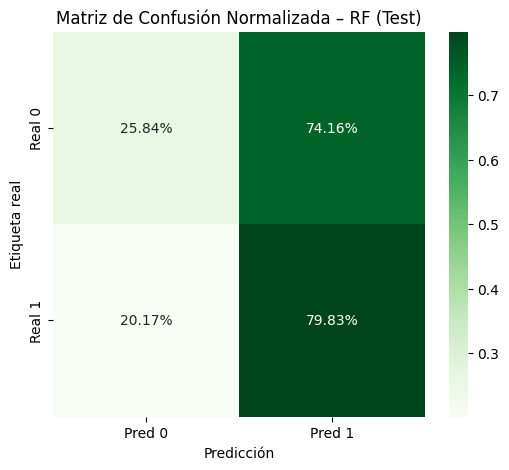

In [66]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – RF (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocess', 'model']
Nombre del preprocesador: preprocess
Nombre del modelo: model
47 features después del preprocesamiento
47 importances en el RandomForest
Top 30 features más importantes:
cat__CSP_DistanciaVivienda_2        0.038714
cat__edadmatcat_3                   0.037998
cat__CSP_NutricionFam_1             0.037803
cat__CSP_DistanciaVivienda_1        0.036466
cat__CSP_SituaPareja_3              0.035275
cat__edadmatcat_2                   0.034987
cat__CSP_SituacionLaboralMadre_3    0.034673
cat__ninosmenosde5anos_0.0          0.034472
cat__ninosmenosde5anos_1.0          0.034181
cat__CSP_SituacionLaboralMadre_1    0.032182
cat__CSP_SituaPareja_1              0.031947
cat__CSP_NutricionFam_2             0.029231
cat__Iden_embarazoMultiple_0.0      0.028628
cat__Iden_embarazoMultiple_1.0      0.027969
cat__CSP_DistanciaVivienda_4        0.027034
cat__CSP_EscolaridadMadre_3         0.026206
cat__CSP_EscolaridadPadre_3         0.024899
cat__educmadresimpl

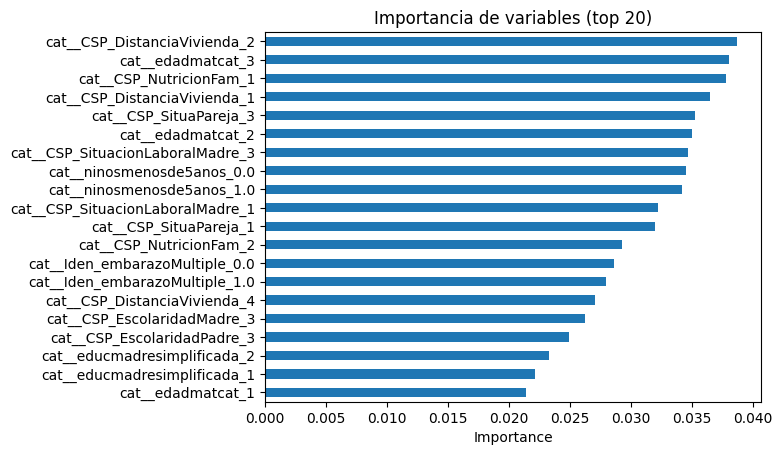

In [67]:

# Tomar los nombres de los pasos
step_names = list(best_model.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_model.named_steps[preproc_name]
rf_best = best_model.named_steps[clf_name]

print("Nombre del preprocesador:", preproc_name)
print("Nombre del modelo:", clf_name)

# 1. Nombres reales de las columnas tras el preprocesamiento
feature_names = preproc.get_feature_names_out()
print(len(feature_names), "features después del preprocesamiento")
print(len(rf_best.feature_importances_), "importances en el RandomForest")


importances = rf_best.feature_importances_

feat_imp = (
    pd.Series(importances, index=feature_names)
      .sort_values(ascending=False)
)

print("Top 30 features más importantes:")
print(feat_imp.head(30))

# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()



##### Guardar modelo

In [70]:
type(best_model)

sklearn.pipeline.Pipeline

In [73]:
joblib.dump(best_model, "modelorf_fase1_infanib.pkl")
print("Modelo guardado como modelorf_fase1_infanib.pkl")

Modelo guardado como modelorf_fase1_infanib.pkl


In [74]:
#Ejemplo de carga
modelo_rf = joblib.load("modelorf_fase1_infanib.pkl")

pred  = modelo_rf.predict(X_test)
proba = modelo_rf.predict_proba(X_test)[:, 1]

#### XGBoost

##### Pipeline con preprocesamiento y modelo

In [75]:
# Peso de clases para XGBoost
counts = y_train.value_counts()
print("Distribución en train:\n", counts)
scale_pos_weight = counts[0] / counts[1]   # mayor peso a la clase 1
print("scale_pos_weight:", scale_pos_weight)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Modelo base XGBoost
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",   # evita warnings
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",      # más rápido en CPU
    scale_pos_weight=scale_pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_clf)   #  nombre para acceder fácil después
])


Distribución en train:
 infanib12m_bin
1    20088
0      836
Name: count, dtype: int64
scale_pos_weight: 0.04161688570290721


##### GridSearch de hiperparámetros

In [76]:
# Búsqueda de hiperparámetros (ligera para no matar el PC)
param_grid = {
    "model__max_depth": [3, 4, 5],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score, pos_label=0)

In [77]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid, cv=cv, scoring=recall_scorer, 
                        n_jobs=-1,verbose=2)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Iden_Sede',
                                                                          'CP_TallaMadre',
                                                                          'CSP_IngresoMensual',
                                                                          'CSP_Menores5vivenMadre',
                                                                          'CSP_numPersVivenIngMen',
                                                                          'AnioParto']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          One...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 4, 5],
                         'model__subsample': [0.8, 1.0]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=0),
             verbose=2)

##### Evaluación

In [78]:
best_xgb = grid_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:,1]
y_pred = best_xgb.predict(X_test)

print("Recall TRAIN:", recall_score(y_train, y_train_pred))
print("Recall TEST:", recall_score(y_test, y_pred))

print("Precision TRAIN:", precision_score(y_train, y_train_pred))
print("Precision TEST:", precision_score(y_test, y_pred))


Recall TRAIN: 0.7258562325766627
Recall TEST: 0.7174432497013142
Precision TRAIN: 0.981951646575527
Precision TEST: 0.9711590296495957


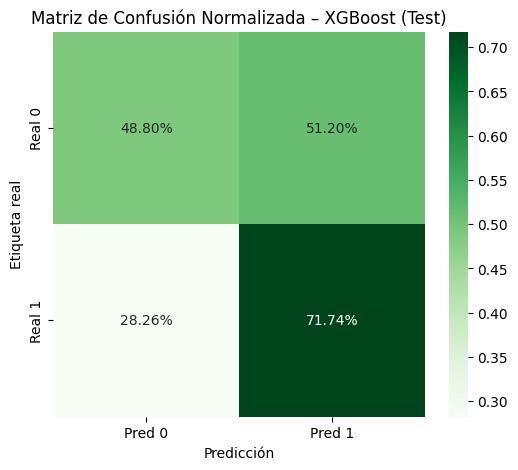

In [79]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocessor', 'model']
Features esperados: 53
Importances entregados: 53

Top 30 Features más importantes:


edadmatcat_3                   0.043250
AnioParto                      0.039046
educmadresimplificada_1        0.037694
CSP_EscolaridadMadre_7         0.031296
CSP_SituaPareja_2              0.028466
educmadresimplificada_2        0.027889
CSP_SituacionLaboralMadre_3    0.026070
educpadresimplificada_3        0.026033
edadmatcat_2                   0.023419
Iden_Sede                      0.022844
CSP_DistanciaVivienda_4        0.022735
CSP_EscolaridadMadre_5         0.022505
CSP_EscolaridadPadre_3         0.022326
CSP_IngresoMensual             0.021284
Iden_embarazoMultiple_1.0      0.021260
CSP_NutricionFam_1             0.021143
CSP_SituacionLaboralMadre_1    0.020521
CSP_EscolaridadPadre_5         0.020521
Iden_embarazoMultiple_0.0      0.020507
CP_TallaMadre                  0.020116
CSP_NutricionFam_2             0.019750
CSP_DistanciaVivienda_2        0.019694
CSP_SituacionLaboralMadre_4    0.019668
CSP_EscolaridadPadre_7         0.019582
CSP_EscolaridadMadre_3         0.019486


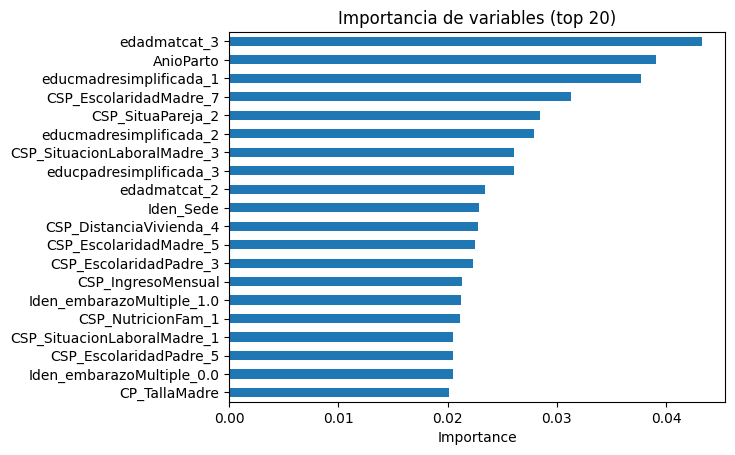

In [80]:
# Tomar los nombres de los pasos
step_names = list(best_xgb.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_xgb.named_steps[preproc_name]
xgb_best = best_xgb.named_steps[clf_name]

# 1.1 Nombres de columnas numéricas (sin transformar)
num_cols = preproc.transformers_[0][2]

# 1.2 Nombres de columnas categóricas transformadas
ohe = preproc.transformers_[1][1]       # OneHotEncoder
cat_cols = preproc.transformers_[1][2]  # columnas originales categóricas
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# 1.3 Unimos todas las columnas transformadas
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

# 1.4 Importance del modelo
importances = xgb_best.feature_importances_

# Validación por si hay mismatch
print("Features esperados:", len(all_feature_names))
print("Importances entregados:", len(importances))

# Crear tabla ordenada
feat_imp = pd.Series(importances, index=all_feature_names)\
                .sort_values(ascending=False)

print("\nTop 30 Features más importantes:")
display(feat_imp.head(30))


# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()


##### Guardar modelo

In [81]:
best_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Iden_Sede', 'CP_TallaMadre',
                                                   'CSP_IngresoMensual',
                                                   'CSP_Menores5vivenMadre',
                                                   'CSP_numPersVivenIngMen',
                                                   'AnioParto']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Iden_embarazoMultiple',
                                                   'edadmatcat',
                                                   'educm...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [83]:
joblib.dump (best_xgb, "modeloxgb_fase1_infanib.pkl")
print("Modelo guardado como modeloxgb_fase1_infanib.pkl")

Modelo guardado como modeloxgb_fase1_infanib.pkl


In [84]:
#Cargar modelo
modelo = joblib.load("modeloxgb_fase1_infanib.pkl")


### Modelo hasta fase 1 (IQ12cat)

#### Preparación

In [85]:
df = df_fase1_modelo.copy()

# Target binaria
y = df["IQ12cat"].astype(int)

# Columnas que no son predictores
id_cols = ["Idenfinal"]
target_col = ['infanib12m_bin', "IQ12cat"]

# Solo extraemos el año del parto
if np.issubdtype(df["Iden_FechaParto"].dtype, np.datetime64):
    df["AnioParto"] = df["Iden_FechaParto"].dt.year
    df = df.drop(columns=["Iden_FechaParto"])

# Predictores
feature_cols = [c for c in df.columns if c not in id_cols + target_col]
X = df[feature_cols]

# Separar numericas de categoricas
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)

Numéricas: ['Iden_Sede', 'CP_TallaMadre', 'CSP_IngresoMensual', 'CSP_Menores5vivenMadre', 'CSP_numPersVivenIngMen', 'AnioParto']
Categóricas: ['Iden_embarazoMultiple', 'edadmatcat', 'educmadresimplificada', 'educpadresimplificada', 'CSP_DistanciaVivienda', 'CSP_EscolaridadMadre', 'CSP_EscolaridadPadre', 'ninosmenosde5anos', 'CSP_NutricionFam', 'CSP_SituacionLaboralMadre', 'CSP_SituacionLaboralPadre', 'CSP_SituaPareja']


#### Split en conjuntos de entrenamiento y prueba

In [86]:
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2,
                                                     random_state=42, stratify=y)

#### Random Forest

##### Pipeline con preprocesamiento y modelo

In [87]:
# Transformaciones
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_cols)])



# Modelo base
rf = RandomForestClassifier(n_estimators=300,random_state=42, n_jobs=-1,
                            class_weight="balanced")


# Pipeline
pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", rf),])

##### GridSearch de hiperparámetros

In [88]:
param_grid = {"model__n_estimators": [200, 400], "model__max_depth": [None, 8, 12],
              "model__min_samples_leaf": [1, 5, 10]}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring="recall",   
                    cv=5, n_jobs=-1, verbose=2)

In [89]:
grid.fit(X_train, y_train)
print("Mejores parámetros:", grid.best_params_)
print("Mejor recall (CV):", grid.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores parámetros: {'model__max_depth': 12, 'model__min_samples_leaf': 1, 'model__n_estimators': 400}
Mejor recall (CV): 0.8216455322913594


##### Evaluación

In [90]:
best_rf= grid.best_estimator_

#Predicciones en trian y test
y_pred_train = best_rf.predict(X_train)
y_pred = best_rf.predict(X_test)

print(f"Recall TRAIN {recall_score(y_train, y_pred_train):.4f}")
print("Recall TEST:", recall_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Recall TRAIN 0.8376
Recall TEST: 0.8105685303137532

Classification report:
              precision    recall  f1-score   support

           0       0.36      0.46      0.41       992
           1       0.87      0.81      0.84      4239

    accuracy                           0.74      5231
   macro avg       0.61      0.64      0.62      5231
weighted avg       0.77      0.74      0.76      5231



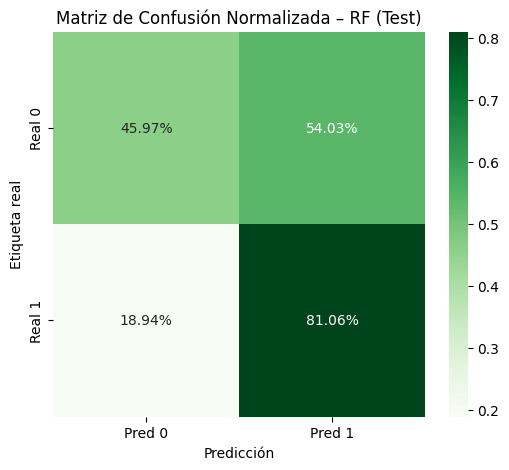

In [91]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – RF (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocess', 'model']
Nombre del preprocesador: preprocess
Nombre del modelo: model
47 features después del preprocesamiento
47 importances en el RandomForest
Top 30 features más importantes:
cat__CSP_NutricionFam_1             0.141401
cat__CSP_NutricionFam_2             0.104040
cat__educmadresimplificada_1        0.042574
cat__CSP_EscolaridadMadre_2         0.034361
cat__CSP_DistanciaVivienda_1        0.030155
cat__CSP_DistanciaVivienda_2        0.027629
cat__CSP_SituacionLaboralMadre_3    0.027625
cat__CSP_SituacionLaboralMadre_1    0.027177
cat__educpadresimplificada_1        0.025957
cat__edadmatcat_2                   0.025877
cat__ninosmenosde5anos_0.0          0.024073
cat__edadmatcat_3                   0.023718
cat__ninosmenosde5anos_1.0          0.023511
cat__CSP_SituaPareja_1              0.022582
cat__CSP_SituaPareja_3              0.022423
cat__CSP_EscolaridadPadre_2         0.021355
cat__CSP_NutricionFam_3             0.020314
cat__CSP_DistanciaV

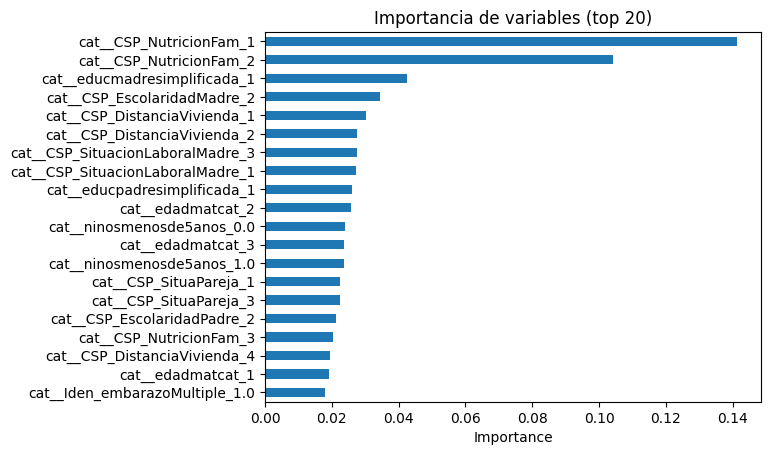

In [92]:

# Tomar los nombres de los pasos
step_names = list(best_rf.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_rf.named_steps[preproc_name]
rf_best = best_rf.named_steps[clf_name]

print("Nombre del preprocesador:", preproc_name)
print("Nombre del modelo:", clf_name)

# 1. Nombres reales de las columnas tras el preprocesamiento
feature_names = preproc.get_feature_names_out()
print(len(feature_names), "features después del preprocesamiento")
print(len(rf_best.feature_importances_), "importances en el RandomForest")


importances = rf_best.feature_importances_

feat_imp = (
    pd.Series(importances, index=feature_names)
      .sort_values(ascending=False)
)

print("Top 30 features más importantes:")
print(feat_imp.head(30))

# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()



##### Guardar modelo

In [93]:
type(best_rf)

sklearn.pipeline.Pipeline

In [95]:
joblib.dump(best_rf, "modelorf_fase1_iq12.pkl")
print("Modelo guardado como modelorf_fase1_iq12.pkl")

Modelo guardado como modelorf_fase1_iq12.pkl


In [96]:
#Ejemplo de carga
modelo_rf = joblib.load("modelorf_fase1_iq12.pkl")

pred  = modelo_rf.predict(X_test)
proba = modelo_rf.predict_proba(X_test)[:, 1]

#### XGBoost

##### Pipeline con preprocesamiento y modelo

In [97]:
# Peso de clases para XGBoost
counts = y_train.value_counts()
print("Distribución en train:\n", counts)
scale_pos_weight = counts[0] / counts[1]   # mayor peso a la clase 1
print("scale_pos_weight:", scale_pos_weight)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Modelo base XGBoost
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",   
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",      # más rápido en CPU
    scale_pos_weight=scale_pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_clf)   
])


Distribución en train:
 IQ12cat
1    16955
0     3969
Name: count, dtype: int64
scale_pos_weight: 0.23409023886759067


##### GridSearch de hiperparámetros

In [98]:
# Búsqueda de hiperparámetros (ligera para no matar el PC)
param_grid = {
    "model__max_depth": [3, 4, 5],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score, pos_label=1)

In [99]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid, cv=cv, scoring=recall_scorer, 
                        n_jobs=-1,verbose=2)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Iden_Sede',
                                                                          'CP_TallaMadre',
                                                                          'CSP_IngresoMensual',
                                                                          'CSP_Menores5vivenMadre',
                                                                          'CSP_numPersVivenIngMen',
                                                                          'AnioParto']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          One...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 4, 5],
                         'model__subsample': [0.8, 1.0]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
             verbose=2)

##### Evaluación

In [100]:
best_xgb = grid_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:,1]

y_pred= best_xgb.predict(X_test)

print("Recall TRAIN:", recall_score(y_train, y_train_pred))
print("Recall TEST:", recall_score(y_test, y_pred))

print("Precision TRAIN:", precision_score(y_train, y_train_pred))
print("Precision TEST:", precision_score(y_test, y_pred))

print("\nClassification report TEST:")
print(classification_report(y_test, y_pred))


Recall TRAIN: 0.804541433205544
Recall TEST: 0.7820240622788394
Precision TRAIN: 0.9061981000465024
Precision TEST: 0.8828229027962716

Classification report TEST:
              precision    recall  f1-score   support

           0       0.37      0.56      0.45       992
           1       0.88      0.78      0.83      4239

    accuracy                           0.74      5231
   macro avg       0.63      0.67      0.64      5231
weighted avg       0.79      0.74      0.76      5231



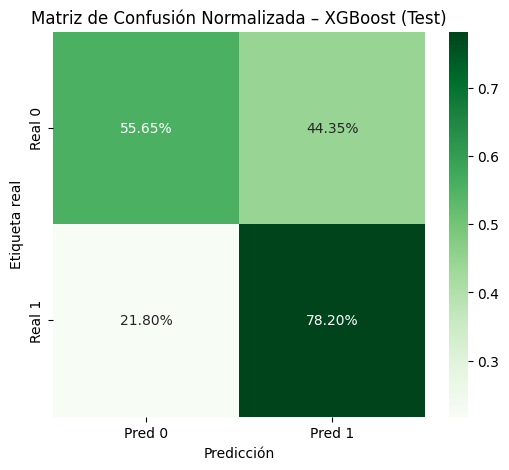

In [101]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocessor', 'model']
Nombre del preprocesador: preprocessor
Nombre del modelo: model
53 features después del preprocesamiento
53 importances en el RandomForest
Top 30 features más importantes:
cat__CSP_NutricionFam_1             0.445975
num__AnioParto                      0.034502
num__Iden_Sede                      0.032501
cat__CSP_EscolaridadMadre_2         0.031827
cat__educpadresimplificada_1        0.021971
cat__educpadresimplificada_3        0.015297
cat__CSP_EscolaridadMadre_7         0.014870
cat__CSP_SituacionLaboralMadre_3    0.014124
cat__edadmatcat_3                   0.014086
cat__CSP_EscolaridadPadre_2         0.013724
cat__CSP_SituaPareja_3              0.012981
cat__CSP_EscolaridadPadre_4         0.012741
cat__educmadresimplificada_2        0.012473
cat__CSP_NutricionFam_2             0.011885
cat__CSP_DistanciaVivienda_4        0.011846
cat__educmadresimplificada_1        0.011528
cat__CSP_DistanciaVivienda_1        0.010717
cat__CSP_Escola

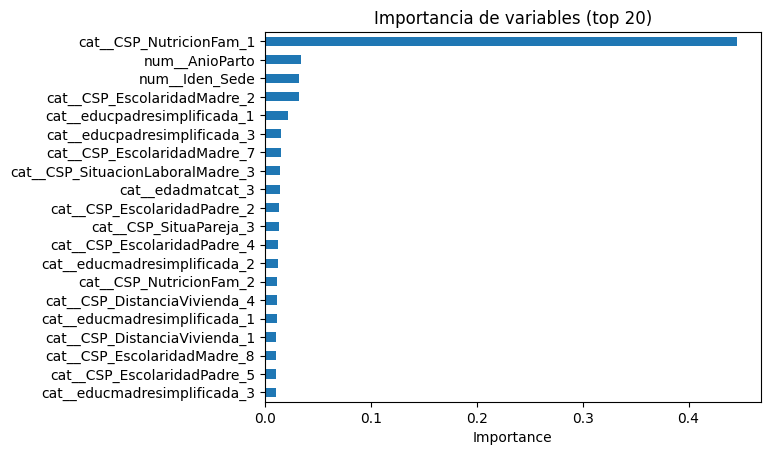

In [102]:

# Tomar los nombres de los pasos
step_names = list(best_xgb.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_xgb.named_steps[preproc_name]
rf_best = best_xgb.named_steps[clf_name]

print("Nombre del preprocesador:", preproc_name)
print("Nombre del modelo:", clf_name)

# 1. Nombres reales de las columnas tras el preprocesamiento
feature_names = preproc.get_feature_names_out()
print(len(feature_names), "features después del preprocesamiento")
print(len(rf_best.feature_importances_), "importances en el RandomForest")


importances = rf_best.feature_importances_

feat_imp = (
    pd.Series(importances, index=feature_names)
      .sort_values(ascending=False)
)

print("Top 30 features más importantes:")
print(feat_imp.head(30))

# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()



##### Guardar modelo

In [103]:
type(best_xgb)

sklearn.pipeline.Pipeline

In [104]:
joblib.dump(best_xgb, "modeloxgb_fase1_iq12.pkl")
print("Modelo guardado como modeloxgb_fase1_iq12.pkl")

Modelo guardado como modeloxgb_fase1_iq12.pkl


In [105]:
#Ejemplo de carga
modelo= joblib.load("modeloxgb_fase1_iq12.pkl")

pred  = modelo.predict(X_test)
proba = modelo.predict_proba(X_test)[:, 1]

### Modelo hasta fase 2 (infanib12m)

In [106]:
dfs_por_fase[2]

,Idenfinal,IQ12cat,infanib12m_bin,CP_ARO,AROCAT02,controlcat,corticodosis,corticoprenatalsimple,ecocat,CP_edadmaterna,embarazoplanifDIU,embarazoplanifhormonal,CP_HospitalizacionesPreParto,CP_MadreAlcohol,CP_MadreFumo,CP_MesInicCP,CP_NumEcografias,pdpcat,CP_MedGeneral,RELACIONAROSOBRETOTALCONSULTAS,CP_SA_Anemia,CP_SA_APP,CP_SA_EnfRespiratoria,CP_SA_InfGineco,CP_SA_InfUrinaria,CP_SA_Preclampsia,CP_SA_RPM,CP_SA_Sangrado,Sufrimientofetalcronico,CP_TotalCPN,toxemia,CP_TP_HepatitisB,CP_TP_HIV,CP_TP_Orina,CP_TP_Rubeola,CP_TP_Sifilis,CP_TP_Toxoplasmosis,trimestre,CSP_EmbarazoDeseado
5049,1005052,True,1,4,1,1,1,0,1.0,38.0,False,False,0,False,False,1,3,2,2,59.06184,False,True,False,True,False,False,False,False,False,4,False,4,1,4,3,1,4,1,True
5050,1005053,True,1,5,1,2,0,0,2.0,29.0,False,False,0,False,False,1,4,1,2,64.417168,False,True,False,True,True,True,False,True,False,7,True,4,1,3,3,1,1,1,True
5051,1005054,True,1,6,1,3,1,0,2.0,21.0,False,True,0,False,False,1,4,1,1,70.13781,False,True,False,False,True,False,False,False,False,14,False,4,1,2,1,1,1,1,False
5054,1005057,True,1,6,1,3,1,0,2.0,28.0,False,False,0,False,False,1,6,2,2,65.500465,False,False,False,False,False,False,False,False,False,17,False,4,1,4,3,1,1,1,True
5055,1005058,True,1,8,1,2,0,0,2.0,41.0,False,False,0,False,False,1,8,1,1,74.436562,False,True,False,False,True,True,False,False,False,6,True,4,1,2,3,1,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64634,4012747,True,1,4,1,2,0,0,1.626386,31.0,False,False,0,False,False,2,4,1,3,46.107395,False,False,False,False,False,False,False,False,False,8,True,1,4,2,3,1,1,1,True
64635,4012807,True,1,4,1,2,0,0,1.628771,41.0,False,False,0,False,False,2,4,1,3,49.184288,False,False,False,False,False,False,False,False,False,5,True,1,4,2,3,1,1,2,False
64637,4012819,True,1,4,1,2,0,0,1.604103,30.0,False,False,0,False,False,2,4,1,3,49.440342,False,False,False,False,False,False,False,True,False,6,False,1,4,2,3,1,1,1,True
64639,4012897,True,1,4,1,2,0,0,1.653553,28.0,False,False,0,False,False,2,4,1,3,47.941757,False,False,False,False,False,False,False,False,False,6,False,1,4,2,3,1,1,1,False


In [107]:
df_fase1_modelo

,Idenfinal,IQ12cat,infanib12m_bin,Iden_embarazoMultiple,Iden_Sede,Iden_FechaParto,edadmatcat,educmadresimplificada,educpadresimplificada,CP_TallaMadre,CSP_DistanciaVivienda,CSP_EscolaridadMadre,CSP_EscolaridadPadre,CSP_IngresoMensual,CSP_Menores5vivenMadre,ninosmenosde5anos,CSP_numPersVivenIngMen,CSP_NutricionFam,CSP_SituacionLaboralMadre,CSP_SituacionLaboralPadre,CSP_SituaPareja
0,1005052,True,1,False,1,2008-03-11,3,2,2,159.130753,1,3,3,900000.0,1,True,5,1,1,1,3
1,1005053,True,1,False,1,2008-04-18,2,3,3,155.947418,1,7,7,1000000.0,1,True,3,1,1,1,3
2,1005054,True,1,True,1,2008-04-16,2,3,3,157.673935,1,7,7,1974527.75,2,True,3,1,3,1,1
3,1005057,True,1,False,1,2008-04-01,2,1,1,160.671936,1,1,1,2000000.0,1,True,3,1,1,1,3
4,1005058,True,1,False,1,2008-04-18,3,3,3,156.915085,1,7,7,2538648.75,2,True,4,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26150,4012747,True,1,False,4,2013-04-08,2,1,2,157.512451,1,1,3,165000.0,0,False,4,1,1,1,1
26151,4012807,True,1,False,4,2013-04-08,3,2,3,151.0,1,3,5,133333.328125,1,False,4,1,1,1,2
26152,4012819,True,1,False,4,2013-04-08,2,2,2,155.0,1,3,3,400000.0,1,False,4,1,1,1,2
26153,4012897,True,1,False,4,2013-04-08,2,3,3,164.0,1,5,5,166666.671875,1,False,4,1,1,1,2


In [108]:
#Merge de los dataframes de la fase 0 y 1
df_fase2_modelo = dfs_por_fase[2].merge(df_fase1_modelo, on=["Idenfinal", "IQ12cat", "infanib12m_bin"],how="inner")

In [109]:
#df_fase2_modelo.to_csv("modelos_fase2/df_fase2.csv", index=False, index_label=False)


In [110]:
df_fase2_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26155 entries, 0 to 26154
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Idenfinal                       26155 non-null  int64         
 1   IQ12cat                         26155 non-null  boolean       
 2   infanib12m_bin                  26155 non-null  int64         
 3   CP_ARO                          26155 non-null  Int64         
 4   AROCAT02                        26155 non-null  category      
 5   controlcat                      26155 non-null  category      
 6   corticodosis                    26155 non-null  Int64         
 7   corticoprenatalsimple           26155 non-null  category      
 8   ecocat                          26155 non-null  Float32       
 9   CP_edadmaterna                  26155 non-null  Float32       
 10  embarazoplanifDIU               26155 non-null  boolean       
 11  em

##### Preparación

In [111]:
df = df_fase2_modelo.copy()

# Target binaria
y = df["infanib12m_bin"].astype(int)

# Columnas que no son predictores
id_cols = ["Idenfinal"]
target_col = ['infanib12m_bin', "IQ12cat"]

# Solo extraemos el año del parto
if np.issubdtype(df["Iden_FechaParto"].dtype, np.datetime64):
    df["AnioParto"] = df["Iden_FechaParto"].dt.year
    df = df.drop(columns=["Iden_FechaParto"])

# Predictores
feature_cols = [c for c in df.columns if c not in id_cols + target_col]
X = df[feature_cols]

# Separar numericas de categoricas
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['CP_ARO', 'corticodosis', 'ecocat', 'CP_edadmaterna', 'CP_HospitalizacionesPreParto', 'CP_MesInicCP', 'CP_NumEcografias', 'CP_MedGeneral', 'RELACIONAROSOBRETOTALCONSULTAS', 'CP_TotalCPN', 'CP_TP_Orina', 'trimestre', 'Iden_Sede', 'CP_TallaMadre', 'CSP_IngresoMensual', 'CSP_Menores5vivenMadre', 'CSP_numPersVivenIngMen', 'AnioParto']
Categóricas: ['AROCAT02', 'controlcat', 'corticoprenatalsimple', 'embarazoplanifDIU', 'embarazoplanifhormonal', 'CP_MadreAlcohol', 'CP_MadreFumo', 'pdpcat', 'CP_SA_Anemia', 'CP_SA_APP', 'CP_SA_EnfRespiratoria', 'CP_SA_InfGineco', 'CP_SA_InfUrinaria', 'CP_SA_Preclampsia', 'CP_SA_RPM', 'CP_SA_Sangrado', 'Sufrimientofetalcronico', 'toxemia', 'CP_TP_HepatitisB', 'CP_TP_HIV', 'CP_TP_Rubeola', 'CP_TP_Sifilis', 'CP_TP_Toxoplasmosis', 'CSP_EmbarazoDeseado', 'Iden_embarazoMultiple', 'edadmatcat', 'educmadresimplificada', 'educpadresimplificada', 'CSP_DistanciaVivienda', 'CSP_EscolaridadMadre', 'CSP_EscolaridadPadre', 'ninosmenosde5anos', 'CSP_NutricionFam'

In [112]:
len(categorical_cols)

36

##### Split en conjuntos de entrenamiento y prueba

In [113]:
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2,
                                                     random_state=42, stratify=y)

#### Random Forest

##### Pipeline con preprocesamiento y modelo

In [114]:
# Transformaciones
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_cols)])



# Modelo base
rf = RandomForestClassifier(n_estimators=300,random_state=42, n_jobs=-1,
                            class_weight="balanced")


# Pipeline
pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", rf),])

##### GridSearch de hiperparámetros

In [115]:
recall_clase0 = make_scorer(recall_score, pos_label=0)
param_grid = {"model__n_estimators": [200, 400], "model__max_depth": [None, 8, 12],
              "model__min_samples_leaf": [1, 5, 10]}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring=recall_clase0,   
                    cv=5, n_jobs=-1, verbose=2)

In [116]:
grid.fit(X_train, y_train)
print("Mejores parámetros:", grid.best_params_)
print("Mejor recall (CV):", grid.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores parámetros: {'model__max_depth': 8, 'model__min_samples_leaf': 10, 'model__n_estimators': 200}
Mejor recall (CV): 0.23092386655260908


##### Evaluación

In [ ]:
best_model = grid.best_estimator_

#Predicciones en trian y test
y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)


print(f"Recall TRAIN {recall_score(y_train, y_pred_train):.4f}")
print("Recall TEST:", recall_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Recall TRAIN 0.8292
Recall TEST: 0.8150139386698526

Classification report:
              precision    recall  f1-score   support

           0       0.06      0.30      0.10       209
           1       0.97      0.82      0.88      5022

    accuracy                           0.79      5231
   macro avg       0.51      0.56      0.49      5231
weighted avg       0.93      0.79      0.85      5231



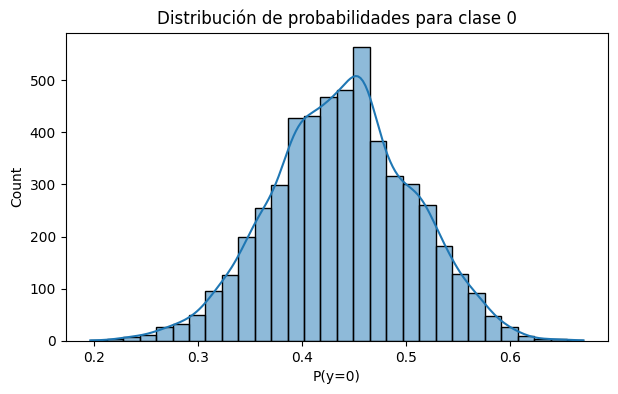

In [ ]:
proba0 = best_model.predict_proba(X_test)[:, 0]

plt.figure(figsize=(7,4))
sns.histplot(proba0, bins=30, kde=True)
plt.title("Distribución de probabilidades para clase 0")
plt.xlabel("P(y=0)")
plt.show()

El histograma muestra la distribución de las probabilidades predichas por el modelo para la clase 0 (niño con desarrollo anómalo) en el conjunto de test. Lo que observamos es una distribución unimodal, aproximadamente simétrica, centrada alrededor de .45, con un rango muy estrecho (aprox. 0.30–0.60). Un clasificador bien entrenado y con señal en los datos debería producir probabilidades cercanas a 0 para la mayoría de los casos de clase 1 y probabilidades cercanas a 1 para los casos de clase 0.

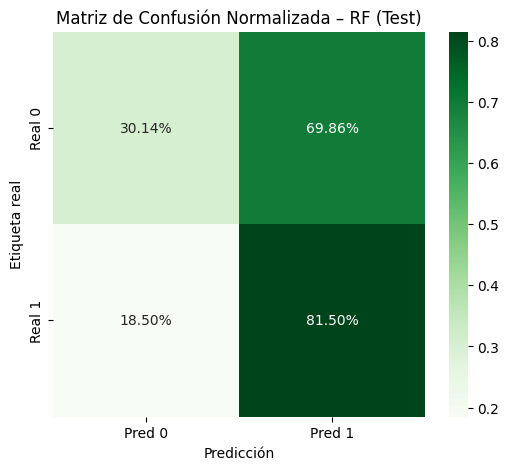

In [ ]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – RF (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocess', 'model']
Nombre del preprocesador: preprocess
Nombre del modelo: model
47 features después del preprocesamiento
47 importances en el RandomForest
Top 30 features más importantes:
cat__CSP_DistanciaVivienda_2        0.038714
cat__edadmatcat_3                   0.037998
cat__CSP_NutricionFam_1             0.037803
cat__CSP_DistanciaVivienda_1        0.036466
cat__CSP_SituaPareja_3              0.035275
cat__edadmatcat_2                   0.034987
cat__CSP_SituacionLaboralMadre_3    0.034673
cat__ninosmenosde5anos_0.0          0.034472
cat__ninosmenosde5anos_1.0          0.034181
cat__CSP_SituacionLaboralMadre_1    0.032182
cat__CSP_SituaPareja_1              0.031947
cat__CSP_NutricionFam_2             0.029231
cat__Iden_embarazoMultiple_0.0      0.028628
cat__Iden_embarazoMultiple_1.0      0.027969
cat__CSP_DistanciaVivienda_4        0.027034
cat__CSP_EscolaridadMadre_3         0.026206
cat__CSP_EscolaridadPadre_3         0.024899
cat__educmadresimpl

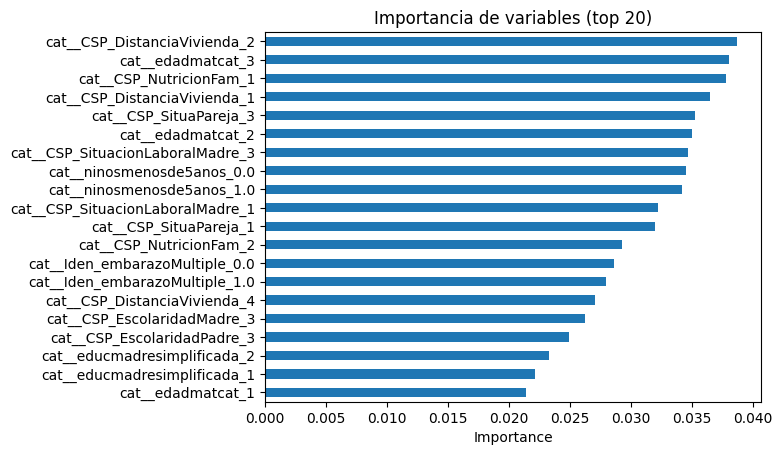

In [117]:

# Tomar los nombres de los pasos
step_names = list(best_model.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_model.named_steps[preproc_name]
rf_best = best_model.named_steps[clf_name]

print("Nombre del preprocesador:", preproc_name)
print("Nombre del modelo:", clf_name)

# 1. Nombres reales de las columnas tras el preprocesamiento
feature_names = preproc.get_feature_names_out()
print(len(feature_names), "features después del preprocesamiento")
print(len(rf_best.feature_importances_), "importances en el RandomForest")


importances = rf_best.feature_importances_

feat_imp = (
    pd.Series(importances, index=feature_names)
      .sort_values(ascending=False)
)

print("Top 30 features más importantes:")
print(feat_imp.head(30))

# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()



##### Guardar modelo

In [118]:
type(best_model)

sklearn.pipeline.Pipeline

In [120]:
joblib.dump(best_model, "modelorf_fase2_infanib.pkl")
print("Modelo guardado como modelorf_fase1_infanib.pkl")

Modelo guardado como modelorf_fase1_infanib.pkl


In [ ]:
#Ejemplo de carga
modelo_rf = joblib.load("modelos_fase1/modelorf_fase1_infanib.pkl")

pred  = modelo_rf.predict(X_test)
proba = modelo_rf.predict_proba(X_test)[:, 1]

#### XGBoost

##### Pipeline con preprocesamiento y modelo

In [121]:
# Peso de clases para XGBoost
counts = y_train.value_counts()
print("Distribución en train:\n", counts)
scale_pos_weight = counts[0] / counts[1]   # mayor peso a la clase 1
print("scale_pos_weight:", scale_pos_weight)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Modelo base XGBoost
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",   # evita warnings
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",      # más rápido en CPU
    scale_pos_weight=scale_pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_clf)   #  nombre para acceder fácil después
])


Distribución en train:
 infanib12m_bin
1    20088
0      836
Name: count, dtype: int64
scale_pos_weight: 0.04161688570290721


In [122]:
X_train.shape

(20924, 54)

##### GridSearch de hiperparámetros

In [123]:
# Búsqueda de hiperparámetros (ligera para no matar el PC)
param_grid = {
    "model__max_depth": [3, 4, 5],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score, pos_label=0)

In [124]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid, cv=cv, scoring=recall_scorer, 
                        n_jobs=-1,verbose=2)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['CP_ARO',
                                                                          'corticodosis',
                                                                          'ecocat',
                                                                          'CP_edadmaterna',
                                                                          'CP_HospitalizacionesPreParto',
                                                                          'CP_MesInicCP',
                                                                          'CP_NumEcografias',
                                                                          'CP_MedGeneral',
                                                                          'RELACIONAROSOBRET...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 4, 5],
                         'model__subsample': [0.8, 1.0]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=0),
             verbose=2)

##### Evaluación

In [125]:
best_xgb = grid_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:,1]
y_pred = best_xgb.predict(X_test)

print("Recall TRAIN:", recall_score(y_train, y_train_pred))
print("Recall TEST:", recall_score(y_test, y_pred))

print("Precision TRAIN:", precision_score(y_train, y_train_pred))
print("Precision TEST:", precision_score(y_test, y_pred))


Recall TRAIN: 0.7516427718040621
Recall TEST: 0.7495021903624054
Precision TRAIN: 0.9835200625325691
Precision TEST: 0.9703531838102604


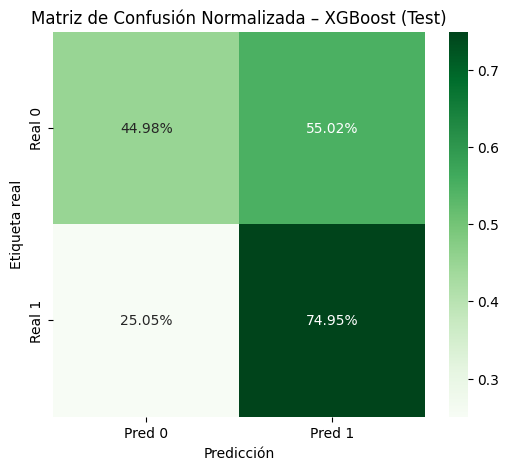

In [126]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocessor', 'model']
Features esperados: 129
Importances entregados: 129

Top 30 Features más importantes:


CSP_NutricionFam_1             0.057602
educmadresimplificada_1        0.034568
AnioParto                      0.028370
edadmatcat_3                   0.026015
CP_SA_APP_1.0                  0.022858
edadmatcat_2                   0.022463
educpadresimplificada_3        0.018471
CSP_EscolaridadMadre_1         0.016758
CSP_SituacionLaboralMadre_3    0.015353
CP_SA_Anemia_0.0               0.015286
CSP_DistanciaVivienda_1        0.015040
CP_TP_Rubeola_3                0.014116
CSP_SituacionLaboralMadre_4    0.014052
CP_TotalCPN                    0.013815
Iden_Sede                      0.013809
CSP_EmbarazoDeseado_0.0        0.013159
CSP_SituaPareja_1              0.013140
CSP_NutricionFam_3             0.012993
corticodosis                   0.012758
CSP_DistanciaVivienda_2        0.012385
controlcat_2                   0.012273
CP_TP_HIV_1                    0.012093
CSP_EscolaridadMadre_3         0.012022
corticoprenatalsimple_0        0.012010
CP_ARO                         0.011715


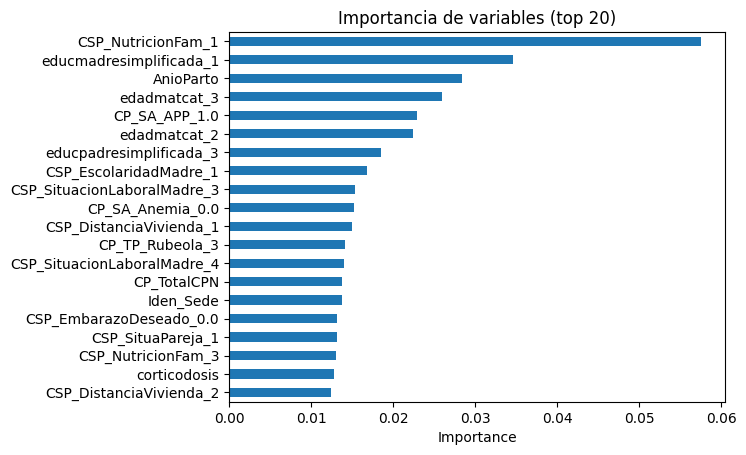

In [127]:
# Tomar los nombres de los pasos
step_names = list(best_xgb.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_xgb.named_steps[preproc_name]
xgb_best = best_xgb.named_steps[clf_name]

# 1.1 Nombres de columnas numéricas (sin transformar)
num_cols = preproc.transformers_[0][2]

# 1.2 Nombres de columnas categóricas transformadas
ohe = preproc.transformers_[1][1]       # OneHotEncoder
cat_cols = preproc.transformers_[1][2]  # columnas originales categóricas
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# 1.3 Unimos todas las columnas transformadas
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

# 1.4 Importance del modelo
importances = xgb_best.feature_importances_

# Validación por si hay mismatch
print("Features esperados:", len(all_feature_names))
print("Importances entregados:", len(importances))

# Crear tabla ordenada
feat_imp = pd.Series(importances, index=all_feature_names)\
                .sort_values(ascending=False)

print("\nTop 30 Features más importantes:")
display(feat_imp.head(30))


# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()


##### Guardar modelo

In [128]:
best_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['CP_ARO', 'corticodosis',
                                                   'ecocat', 'CP_edadmaterna',
                                                   'CP_HospitalizacionesPreParto',
                                                   'CP_MesInicCP',
                                                   'CP_NumEcografias',
                                                   'CP_MedGeneral',
                                                   'RELACIONAROSOBRETOTALCONSULTAS',
                                                   'CP_TotalCPN', 'CP_TP_Orina',
                                                   'trimestre', 'Iden_Sede',
                                                   'CP_TallaMadre',...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [130]:
joblib.dump (best_xgb, "modeloxgb_fase2_infanib.pkl")
print("Modelo guardado como modeloxgb_fase2_infanib.pkl")

Modelo guardado como modeloxgb_fase2_infanib.pkl


In [132]:
#Cargar modelo
modelo = joblib.load("modeloxgb_fase1_infanib.pkl")

### Modelo hasta fase 3 (infanib12m)

In [133]:
dfs_por_fase[3]

,Idenfinal,IQ12cat,infanib12m_bin,ERN_PC,ERN_Peso,ERN_Talla,ERN_AdaptNeonatal,anoxia5mn,ERN_A_10min,ERN_A_1min,ERN_A_5min,apgarcat1,apgarcat5,BPN,ERN_Ballard,gestacat,INFECCIONOSOCOMIAL,ERN_LubchencoFenton,menosde1001,menosde31sem,Nearterm,pesocat,PESO1500G,RCIUPC,RCIUtalla,ERN_Remision,ERN_sepsis,ERN_Sexo,HD_DiasAlojamiento,DIASTOT08,ANOCAT,PA_AtendioParto,cesarea,PA_ComplicacionsPartoAbrupcio,PA_ComplicacionsPartoAmnionitis,PA_ComplicacionsPartoEclampsia,PA_ComplicacionsPartoMultiples,PA_ComplicacionsPartoPatologIaCordOn,PA_ComplicacionsPartoPlacentaPrevia,PA_ComplicacionsPartoPreeclampsia,PA_ComplicacionsPartoSindromedehellp,PA_EstActualMadre,tuvotransfusiones,UCI,PA_LiqAmnioticoMeconiado,PA_LugarNacimiento,PA_Monitoreo,PA_NumDosisCorticoides,primipara,PA_RitmoCardiaco,PA_SufrimientoFetalAgudo,PA_TipoParto,CONSULT08,ecocerebral,REHOSP08,rehosp40
5049,1005052,True,1,27.0,1111.0,38.0,1,False,10,8,10,4,4,False,28.0,1,False,1,False,True,False,2,True,False,False,False,2,1,0,3.0,6,1,True,False,False,False,False,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,10.0,True,2.0,True
5050,1005053,True,1,31.343039,1980.0,43.0,1,True,10,7,9,3,4,False,34.0,3,False,1,False,False,True,5,False,False,False,False,0,1,0,0.0,6,1,True,False,False,False,False,False,False,True,False,1,False,False,0,1,False,1,False,0,0,2,8.0,True,0.0,False
5051,1005054,True,1,31.0,2100.0,43.0,1,True,9,7,8,3,4,False,33.0,3,False,1,False,False,False,6,False,False,False,False,2,1,0,0.0,6,1,True,False,False,False,True,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,9.0,True,0.0,False
5054,1005057,True,1,30.805439,1743.0,42.0,1,False,10,9,10,4,4,False,30.0,1,False,1,False,True,False,4,False,False,False,False,0,1,0,1.0,6,1,True,False,False,False,False,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,11.0,True,1.0,True
5055,1005058,True,1,33.0,2210.0,44.0,1,True,10,6,8,3,4,False,35.0,4,False,1,False,False,True,6,False,False,False,False,0,1,0,0.000121,6,1,True,False,False,False,False,False,False,True,False,1,False,True,0,1,False,1,False,0,0,2,0.0,True,0.000204,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64634,4012747,True,1,32.5,2773.0,46.0,1,False,10,8,9,4,4,False,36.0,4,False,1,False,False,True,6,False,False,False,False,0,2,1,0.0,-1,1,True,False,False,False,False,False,False,False,False,1,False,False,0,1,False,0,True,0,0,2,1.0,True,0.0,False
64635,4012807,True,1,31.5,2276.0,47.0,1,False,10,8,9,4,4,False,36.0,4,False,2,False,False,True,6,False,False,False,False,0,1,0,0.0,-1,1,True,False,False,False,False,False,False,False,False,1,False,False,0,1,False,0,False,0,0,2,5.0,True,0.0,False
64637,4012819,True,1,32.5,2242.0,47.0,1,False,10,8,9,4,4,False,34.0,3,False,1,False,False,True,6,False,False,False,False,0,1,0,0.0,-1,1,False,False,False,False,False,False,False,False,False,1,False,False,0,1,False,0,False,0,0,2,11.0,True,0.0,False
64639,4012897,True,1,33.5,2333.0,46.5,1,False,10,8,9,4,4,False,36.0,4,False,1,False,False,True,6,False,False,False,False,0,2,1,0.0,-1,1,True,False,False,False,False,False,False,False,False,1,False,False,0,1,False,0,True,0,0,2,5.0,True,0.0,False


In [134]:
df_fase2_modelo

,Idenfinal,IQ12cat,infanib12m_bin,CP_ARO,AROCAT02,controlcat,corticodosis,corticoprenatalsimple,ecocat,CP_edadmaterna,embarazoplanifDIU,embarazoplanifhormonal,CP_HospitalizacionesPreParto,CP_MadreAlcohol,CP_MadreFumo,CP_MesInicCP,CP_NumEcografias,pdpcat,CP_MedGeneral,RELACIONAROSOBRETOTALCONSULTAS,CP_SA_Anemia,CP_SA_APP,CP_SA_EnfRespiratoria,CP_SA_InfGineco,CP_SA_InfUrinaria,CP_SA_Preclampsia,CP_SA_RPM,CP_SA_Sangrado,Sufrimientofetalcronico,CP_TotalCPN,toxemia,CP_TP_HepatitisB,CP_TP_HIV,CP_TP_Orina,CP_TP_Rubeola,CP_TP_Sifilis,CP_TP_Toxoplasmosis,trimestre,CSP_EmbarazoDeseado,Iden_embarazoMultiple,Iden_Sede,Iden_FechaParto,edadmatcat,educmadresimplificada,educpadresimplificada,CP_TallaMadre,CSP_DistanciaVivienda,CSP_EscolaridadMadre,CSP_EscolaridadPadre,CSP_IngresoMensual,CSP_Menores5vivenMadre,ninosmenosde5anos,CSP_numPersVivenIngMen,CSP_NutricionFam,CSP_SituacionLaboralMadre,CSP_SituacionLaboralPadre,CSP_SituaPareja
0,1005052,True,1,4,1,1,1,0,1.0,38.0,False,False,0,False,False,1,3,2,2,59.06184,False,True,False,True,False,False,False,False,False,4,False,4,1,4,3,1,4,1,True,False,1,2008-03-11,3,2,2,159.130753,1,3,3,900000.0,1,True,5,1,1,1,3
1,1005053,True,1,5,1,2,0,0,2.0,29.0,False,False,0,False,False,1,4,1,2,64.417168,False,True,False,True,True,True,False,True,False,7,True,4,1,3,3,1,1,1,True,False,1,2008-04-18,2,3,3,155.947418,1,7,7,1000000.0,1,True,3,1,1,1,3
2,1005054,True,1,6,1,3,1,0,2.0,21.0,False,True,0,False,False,1,4,1,1,70.13781,False,True,False,False,True,False,False,False,False,14,False,4,1,2,1,1,1,1,False,True,1,2008-04-16,2,3,3,157.673935,1,7,7,1974527.75,2,True,3,1,3,1,1
3,1005057,True,1,6,1,3,1,0,2.0,28.0,False,False,0,False,False,1,6,2,2,65.500465,False,False,False,False,False,False,False,False,False,17,False,4,1,4,3,1,1,1,True,False,1,2008-04-01,2,1,1,160.671936,1,1,1,2000000.0,1,True,3,1,1,1,3
4,1005058,True,1,8,1,2,0,0,2.0,41.0,False,False,0,False,False,1,8,1,1,74.436562,False,True,False,False,True,True,False,False,False,6,True,4,1,2,3,1,1,1,False,False,1,2008-04-18,3,3,3,156.915085,1,7,7,2538648.75,2,True,4,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26150,4012747,True,1,4,1,2,0,0,1.626386,31.0,False,False,0,False,False,2,4,1,3,46.107395,False,False,False,False,False,False,False,False,False,8,True,1,4,2,3,1,1,1,True,False,4,2013-04-08,2,1,2,157.512451,1,1,3,165000.0,0,False,4,1,1,1,1
26151,4012807,True,1,4,1,2,0,0,1.628771,41.0,False,False,0,False,False,2,4,1,3,49.184288,False,False,False,False,False,False,False,False,False,5,True,1,4,2,3,1,1,2,False,False,4,2013-04-08,3,2,3,151.0,1,3,5,133333.328125,1,False,4,1,1,1,2
26152,4012819,True,1,4,1,2,0,0,1.604103,30.0,False,False,0,False,False,2,4,1,3,49.440342,False,False,False,False,False,False,False,True,False,6,False,1,4,2,3,1,1,1,True,False,4,2013-04-08,2,2,2,155.0,1,3,3,400000.0,1,False,4,1,1,1,2
26153,4012897,True,1,4,1,2,0,0,1.653553,28.0,False,False,0,False,False,2,4,1,3,47.941757,False,False,False,False,False,False,False,False,False,6,False,1,4,2,3,1,1,1,False,False,4,2013-04-08,2,3,3,164.0,1,5,5,166666.671875,1,False,4,1,1,1,2


In [135]:
#Merge de los dataframes de la fase 0 y 1
df_fase3_modelo = dfs_por_fase[3].merge(df_fase2_modelo, on=["Idenfinal", "IQ12cat", "infanib12m_bin"],how="inner")

In [136]:
#df_fase2_modelo.to_csv("modelos_fase2/df_fase2.csv", index=False, index_label=False)


In [137]:
df_fase3_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26155 entries, 0 to 26154
Columns: 110 entries, Idenfinal to CSP_SituaPareja
dtypes: Float32(12), Int64(15), boolean(43), category(37), datetime64[ns](1), int64(2)
memory usage: 8.5 MB


##### Preparación

In [138]:
vars_ruido_original = []

In [139]:
df = df_fase3_modelo.copy()


# Target binaria
y = df["infanib12m_bin"].astype(int)

# Columnas que no son predictores
id_cols = ["Idenfinal"]
target_col = ['infanib12m_bin', "IQ12cat"]

# Solo extraemos el año del parto
if np.issubdtype(df["Iden_FechaParto"].dtype, np.datetime64):
    df["AnioParto"] = df["Iden_FechaParto"].dt.year
    df = df.drop(columns=["Iden_FechaParto"])

# Predictores
feature_cols = [c for c in df.columns if c not in id_cols + target_col+ vars_ruido_original]
X = df[feature_cols]

# Separar numericas de categoricas
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['ERN_PC', 'ERN_Peso', 'ERN_Talla', 'ERN_Ballard', 'HD_DiasAlojamiento', 'DIASTOT08', 'ANOCAT', 'PA_NumDosisCorticoides', 'CONSULT08', 'REHOSP08', 'CP_ARO', 'corticodosis', 'ecocat', 'CP_edadmaterna', 'CP_HospitalizacionesPreParto', 'CP_MesInicCP', 'CP_NumEcografias', 'CP_MedGeneral', 'RELACIONAROSOBRETOTALCONSULTAS', 'CP_TotalCPN', 'CP_TP_Orina', 'trimestre', 'Iden_Sede', 'CP_TallaMadre', 'CSP_IngresoMensual', 'CSP_Menores5vivenMadre', 'CSP_numPersVivenIngMen', 'AnioParto']
Categóricas: ['ERN_AdaptNeonatal', 'anoxia5mn', 'ERN_A_10min', 'ERN_A_1min', 'ERN_A_5min', 'apgarcat1', 'apgarcat5', 'BPN', 'gestacat', 'INFECCIONOSOCOMIAL', 'ERN_LubchencoFenton', 'menosde1001', 'menosde31sem', 'Nearterm', 'pesocat', 'PESO1500G', 'RCIUPC', 'RCIUtalla', 'ERN_Remision', 'ERN_sepsis', 'ERN_Sexo', 'PA_AtendioParto', 'cesarea', 'PA_ComplicacionsPartoAbrupcio', 'PA_ComplicacionsPartoAmnionitis', 'PA_ComplicacionsPartoEclampsia', 'PA_ComplicacionsPartoMultiples', 'PA_ComplicacionsPartoPatologI

In [140]:
len(categorical_cols)

79

##### Split en conjuntos de entrenamiento y prueba

In [141]:
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2,
                                                     random_state=42, stratify=y)

#### Random Forest

##### Pipeline con preprocesamiento y modelo

In [142]:
# Transformaciones
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_cols)])



# Modelo base
rf = RandomForestClassifier(n_estimators=300,random_state=42, n_jobs=-1,
                            class_weight="balanced")


# Pipeline
pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", rf),])

##### GridSearch de hiperparámetros

In [143]:
recall_clase0 = make_scorer(recall_score, pos_label=0)
param_grid = {"model__n_estimators": [200, 400], "model__max_depth": [None, 8, 12],
              "model__min_samples_leaf": [1, 5, 10]}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring=recall_clase0,   
                    cv=5, n_jobs=-1, verbose=2)

In [144]:
grid.fit(X_train, y_train)
print("Mejores parámetros:", grid.best_params_)
print("Mejor recall (CV):", grid.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores parámetros: {'model__max_depth': 8, 'model__min_samples_leaf': 10, 'model__n_estimators': 200}
Mejor recall (CV): 0.33734673510122615


##### Evaluación

In [145]:
best_model = grid.best_estimator_

#Predicciones en trian y test
y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)


print(f"Recall TRAIN {recall_score(y_train, y_pred_train):.4f}")
print("Recall TEST:", recall_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Recall TRAIN 0.8766
Recall TEST: 0.8667861409796893

Classification report:
              precision    recall  f1-score   support

           0       0.11      0.39      0.17       209
           1       0.97      0.87      0.92      5022

    accuracy                           0.85      5231
   macro avg       0.54      0.63      0.54      5231
weighted avg       0.94      0.85      0.89      5231



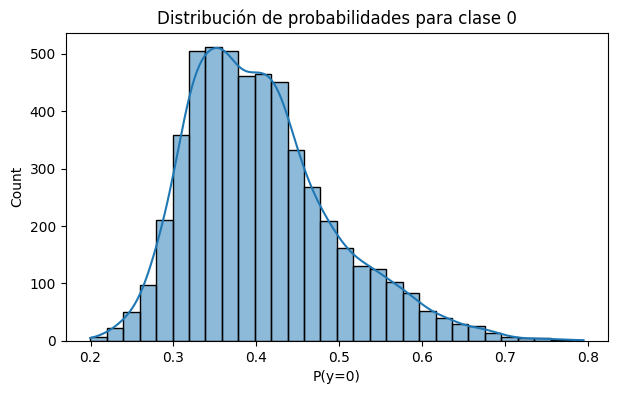

In [146]:
proba0 = best_model.predict_proba(X_test)[:, 0]

plt.figure(figsize=(7,4))
sns.histplot(proba0, bins=30, kde=True)
plt.title("Distribución de probabilidades para clase 0")
plt.xlabel("P(y=0)")
plt.show()

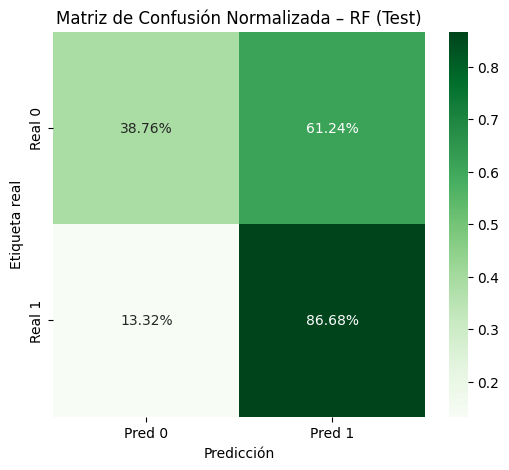

In [147]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – RF (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocess', 'model']
Nombre del preprocesador: preprocess
Nombre del modelo: model
250 features después del preprocesamiento
250 importances en el RandomForest
Top 30 features más importantes:
cat__UCI_1.0                       0.039994
cat__pesocat_6                     0.035299
cat__UCI_0.0                       0.029435
cat__PESO1500G_0.0                 0.026102
cat__tuvotransfusiones_0.0         0.023785
cat__tuvotransfusiones_1.0         0.021448
cat__PESO1500G_1.0                 0.020639
cat__gestacat_1                    0.016711
cat__menosde31sem_0.0              0.015703
cat__educmadresimplificada_1       0.015069
cat__menosde31sem_1.0              0.012747
cat__Nearterm_1.0                  0.012570
cat__menosde1001_0.0               0.012214
cat__menosde1001_1.0               0.012149
cat__pesocat_1                     0.011342
cat__Nearterm_0.0                  0.011261
cat__anoxia5mn_0.0                 0.010992
cat__pesocat_2                    

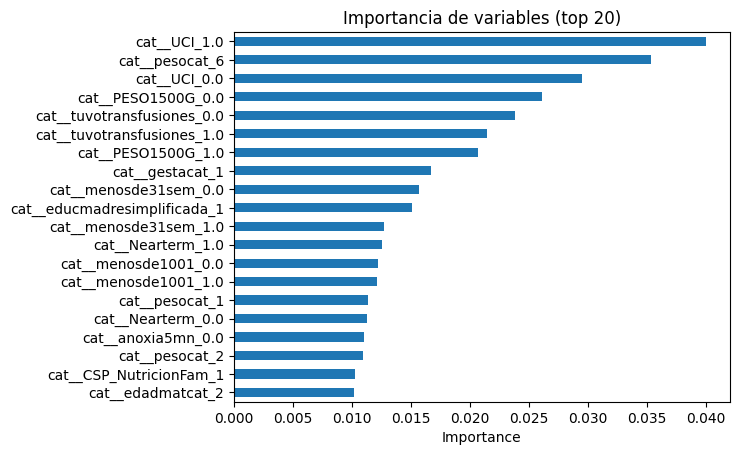

In [148]:

# Tomar los nombres de los pasos
step_names = list(best_model.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_model.named_steps[preproc_name]
rf_best = best_model.named_steps[clf_name]

print("Nombre del preprocesador:", preproc_name)
print("Nombre del modelo:", clf_name)

# 1. Nombres reales de las columnas tras el preprocesamiento
feature_names = preproc.get_feature_names_out()
print(len(feature_names), "features después del preprocesamiento")
print(len(rf_best.feature_importances_), "importances en el RandomForest")


importances = rf_best.feature_importances_

feat_imp = (
    pd.Series(importances, index=feature_names)
      .sort_values(ascending=False)
)

print("Top 30 features más importantes:")
print(feat_imp.head(30))

# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()



In [149]:
best_model.named_steps["preprocess"].named_transformers_

{'cat': Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]),
 'remainder': 'drop'}

##### Variables ruidosas

###### Descarte por feature importance

In [150]:
def var_original_from_encoded(name):
    # Quitar prefijo num__ o cat__
    name = name.replace("num__", "").replace("cat__", "")
    # Quitar sufijo del nivel de categoría si existe
    return name.split("_")[0]


feat_imp_by_var = (
    feat_imp
        .groupby(var_original_from_encoded)
        .sum()
        .sort_values(ascending=False)
)



In [151]:
umbral = 0.01
vars_ruido_original = feat_imp_by_var[feat_imp_by_var < umbral].index.tolist()

vars_ruido_original

['AROCAT02',
 'apgarcat5',
 'cesarea',
 'pdpcat',
 'toxemia',
 'ninosmenosde5anos',
 'embarazoplanifhormonal',
 'BPN',
 'ecocerebral',
 'rehosp40',
 'embarazoplanifDIU']

###### Descarte con shap

In [152]:
ohe = None
cat_cols = None

for name, transformer, cols in preproc.transformers_:
    if hasattr(transformer, "get_feature_names_out"):
        ohe = transformer
        cat_cols = cols
        break

if ohe is None:
    raise ValueError("⚠️ No se encontró un OneHotEncoder en el preprocessor.")

In [153]:
preproc = best_model.named_steps["preprocess"]  # ojo al nombre de la etapa

# 1. Columnas numéricas usadas en el preprocesador
num_cols = preproc.transformers_[0][2]   # asumiendo que el primer bloque es numérico

# 2. Columnas categóricas (solo para info, no las necesitamos para get_feature_names_out)
cat_cols = preproc.transformers_[1][2]   # segundo bloque categórico

# 3. OneHotEncoder dentro del ColumnTransformer
ohe = preproc.named_transformers_["cat"]  # o el nombre que le diste, p.ej. "cat"

# 4. Nombres de las columnas categóricas ya one-hot
if hasattr(ohe, "get_feature_names_out"):
    # sklearn >= 1.0 → NO pases cat_cols, usa lo que ya tiene guardado
    cat_names = ohe.get_feature_names_out()
else:
    # sklearn < 1.0
    cat_names = ohe.get_feature_names()

# 5. Unimos numéricas + dummies
import numpy as np

all_names = np.concatenate([num_cols, cat_names])

print("len(num_cols):", len(num_cols))
print("len(cat_names):", len(cat_names))
print("len(all_names):", len(all_names))
print(all_names[:20])


len(num_cols): 79
len(cat_names): 250
len(all_names): 329
['ERN_AdaptNeonatal' 'anoxia5mn' 'ERN_A_10min' 'ERN_A_1min' 'ERN_A_5min'
 'apgarcat1' 'apgarcat5' 'BPN' 'gestacat' 'INFECCIONOSOCOMIAL'
 'ERN_LubchencoFenton' 'menosde1001' 'menosde31sem' 'Nearterm' 'pesocat'
 'PESO1500G' 'RCIUPC' 'RCIUtalla' 'ERN_Remision' 'ERN_sepsis']


#### XGBoost

##### Pipeline con preprocesamiento y modelo

In [154]:
# Peso de clases para XGBoost
counts = y_train.value_counts()
print("Distribución en train:\n", counts)
scale_pos_weight = counts[0] / counts[1]   # mayor peso a la clase 1
print("scale_pos_weight:", scale_pos_weight)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Modelo base XGBoost
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",   # evita warnings
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",      # más rápido en CPU
    scale_pos_weight=scale_pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_clf)   #  nombre para acceder fácil después
])


Distribución en train:
 infanib12m_bin
1    20088
0      836
Name: count, dtype: int64
scale_pos_weight: 0.04161688570290721


In [155]:
X_train.shape

(20924, 107)

##### GridSearch de hiperparámetros

In [156]:
# Búsqueda de hiperparámetros (ligera para no matar el PC)
param_grid = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.05, 0.1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score, pos_label=0)

In [157]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid, cv=cv, scoring=recall_scorer, 
                        n_jobs=-1,verbose=2)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ERN_PC',
                                                                          'ERN_Peso',
                                                                          'ERN_Talla',
                                                                          'ERN_Ballard',
                                                                          'HD_DiasAlojamiento',
                                                                          'DIASTOT08',
                                                                          'ANOCAT',
                                                                          'PA_NumDosisCorticoides',
                                                                          'CONSULT08',
                                                                          'REHOSP08',
                                                                          'CP_ARO',
                                                                          'cor...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [300, 500, 800]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=0),
             verbose=2)

##### Evaluación

In [158]:
best_xgb = grid_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:,1]
y_pred = best_xgb.predict(X_test)

print("Recall TRAIN:", recall_score(y_train, y_train_pred))
print("Recall TEST:", recall_score(y_test, y_pred))

print("Precision TRAIN:", precision_score(y_train, y_train_pred))
print("Precision TEST:", precision_score(y_test, y_pred))


Recall TRAIN: 0.7473118279569892
Recall TEST: 0.7351652727996814
Precision TRAIN: 0.9807918463347707
Precision TEST: 0.9772366331392272


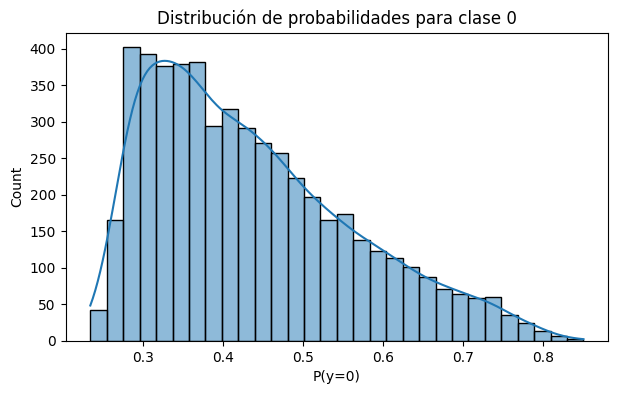

In [159]:
proba0 = best_xgb.predict_proba(X_test)[:, 0]

plt.figure(figsize=(7,4))
sns.histplot(proba0, bins=30, kde=True)
plt.title("Distribución de probabilidades para clase 0")
plt.xlabel("P(y=0)")
plt.show()

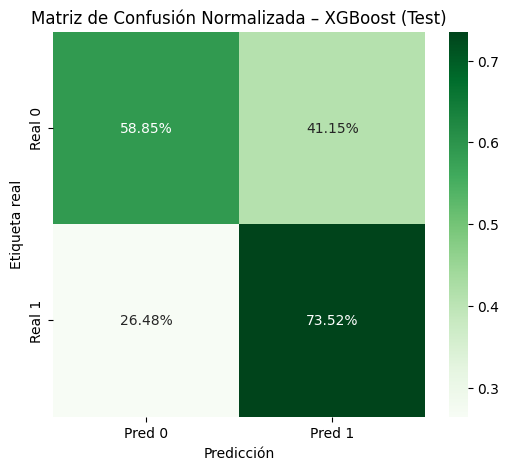

In [160]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


In [161]:
t=0.35

prob_clase0 = best_xgb.predict_proba(X_test)[:,0]
y_pred_t = (prob_clase0 >= t).astype(int)

print("Recall TEST:", recall_score(y_test, y_pred_t))

Recall TEST: 0.6778176025487853


##### Feature importance

Steps en el pipeline: ['preprocessor', 'model']
Features esperados: 278
Importances entregados: 278

Top 30 Features más importantes:


ERN_PC                     0.068166
ERN_Peso                   0.062893
UCI_0.0                    0.060248
AnioParto                  0.046166
tuvotransfusiones_0.0      0.039695
ERN_Talla                  0.036951
educmadresimplificada_1    0.033227
CONSULT08                  0.032238
DIASTOT08                  0.031448
anoxia5mn_0.0              0.028683
CP_edadmaterna             0.027766
ERN_Sexo_1                 0.026660
INFECCIONOSOCOMIAL_0.0     0.026607
apgarcat1_4                0.023526
ANOCAT                     0.023440
PA_NumDosisCorticoides     0.020941
educpadresimplificada_3    0.020435
REHOSP08                   0.019284
Iden_Sede                  0.018303
ERN_A_5min_10              0.017563
ERN_Sexo_2                 0.016316
CSP_IngresoMensual         0.015029
CSP_EscolaridadMadre_3     0.013842
CSP_EscolaridadMadre_2     0.013346
CP_TallaMadre              0.013341
RCIUPC_0.0                 0.013272
ERN_AdaptNeonatal_1        0.012618
CP_MesInicCP               0

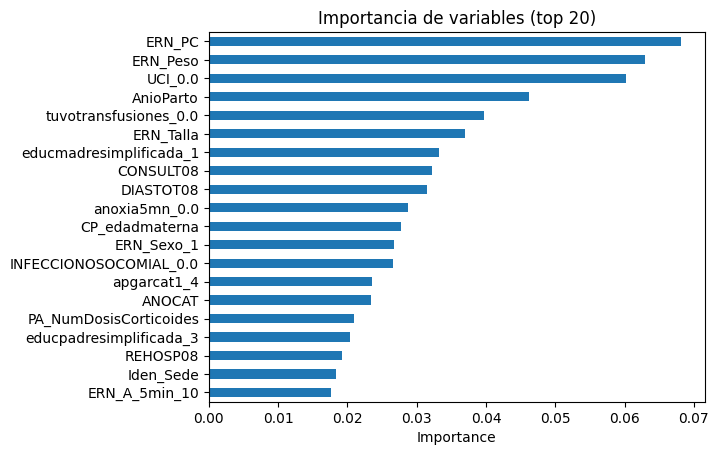

In [162]:
# Tomar los nombres de los pasos
step_names = list(best_xgb.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_xgb.named_steps[preproc_name]
xgb_best = best_xgb.named_steps[clf_name]

# 1.1 Nombres de columnas numéricas (sin transformar)
num_cols = preproc.transformers_[0][2]

# 1.2 Nombres de columnas categóricas transformadas
ohe = preproc.transformers_[1][1]       # OneHotEncoder
cat_cols = preproc.transformers_[1][2]  # columnas originales categóricas
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# 1.3 Unimos todas las columnas transformadas
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

# 1.4 Importance del modelo
importances = xgb_best.feature_importances_

# Validación por si hay mismatch
print("Features esperados:", len(all_feature_names))
print("Importances entregados:", len(importances))

# Crear tabla ordenada
feat_imp = pd.Series(importances, index=all_feature_names)\
                .sort_values(ascending=False)

print("\nTop 30 Features más importantes:")
display(feat_imp.head(30))


# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()


In [163]:
def var_original_from_encoded(name):
    # Quitar prefijo num__ o cat__
    name = name.replace("num__", "").replace("cat__", "")
    # Quitar sufijo del nivel de categoría si existe
    return name.split("_")[0]


In [164]:
feat_imp_by_var = (
    feat_imp
        .groupby(var_original_from_encoded)
        .sum()
        .sort_values(ascending=False)
)

In [165]:
umbral = 0.002
vars_ruido_original = feat_imp_by_var[feat_imp_by_var < umbral].index.tolist()

vars_ruido_original

['AROCAT02',
 'Nearterm',
 'ecocerebral',
 'corticodosis',
 'corticoprenatalsimple',
 'apgarcat5',
 'Sufrimientofetalcronico',
 'PESO1500G',
 'cesarea',
 'menosde31sem',
 'menosde1001',
 'edadmatcat',
 'embarazoplanifDIU',
 'primipara',
 'ninosmenosde5anos',
 'toxemia',
 'rehosp40']

##### Guardar modelo

In [166]:
best_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ERN_PC', 'ERN_Peso',
                                                   'ERN_Talla', 'ERN_Ballard',
                                                   'HD_DiasAlojamiento',
                                                   'DIASTOT08', 'ANOCAT',
                                                   'PA_NumDosisCorticoides',
                                                   'CONSULT08', 'REHOSP08',
                                                   'CP_ARO', 'corticodosis',
                                                   'ecocat', 'CP_edadmaterna',
                                                   'CP_HospitalizacionesPreParto',
                                                   'CP_MesInicCP',...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [168]:
joblib.dump (best_xgb, "modeloxgb_fase3_infanib.pkl")
print("Modelo guardado como modeloxgb_fase3_infanib.pkl")

Modelo guardado como modeloxgb_fase3_infanib.pkl


In [169]:
#Cargar modelo
modelo = joblib.load("modeloxgb_fase1_infanib.pkl")

### Modelo hasta fase 3 (IQ12cat)

##### Preparación

In [170]:
df = df_fase2_modelo.copy()

# Target binaria
y = df["IQ12cat"].astype(int)

# Columnas que no son predictores
id_cols = ["Idenfinal"]
target_col = ['infanib12m_bin', "IQ12cat"]

# Solo extraemos el año del parto
if np.issubdtype(df["Iden_FechaParto"].dtype, np.datetime64):
    df["AnioParto"] = df["Iden_FechaParto"].dt.year
    df = df.drop(columns=["Iden_FechaParto"])

# Predictores
feature_cols = [c for c in df.columns if c not in id_cols + target_col]
X = df[feature_cols]

# Separar numericas de categoricas
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['CP_ARO', 'corticodosis', 'ecocat', 'CP_edadmaterna', 'CP_HospitalizacionesPreParto', 'CP_MesInicCP', 'CP_NumEcografias', 'CP_MedGeneral', 'RELACIONAROSOBRETOTALCONSULTAS', 'CP_TotalCPN', 'CP_TP_Orina', 'trimestre', 'Iden_Sede', 'CP_TallaMadre', 'CSP_IngresoMensual', 'CSP_Menores5vivenMadre', 'CSP_numPersVivenIngMen', 'AnioParto']
Categóricas: ['AROCAT02', 'controlcat', 'corticoprenatalsimple', 'embarazoplanifDIU', 'embarazoplanifhormonal', 'CP_MadreAlcohol', 'CP_MadreFumo', 'pdpcat', 'CP_SA_Anemia', 'CP_SA_APP', 'CP_SA_EnfRespiratoria', 'CP_SA_InfGineco', 'CP_SA_InfUrinaria', 'CP_SA_Preclampsia', 'CP_SA_RPM', 'CP_SA_Sangrado', 'Sufrimientofetalcronico', 'toxemia', 'CP_TP_HepatitisB', 'CP_TP_HIV', 'CP_TP_Rubeola', 'CP_TP_Sifilis', 'CP_TP_Toxoplasmosis', 'CSP_EmbarazoDeseado', 'Iden_embarazoMultiple', 'edadmatcat', 'educmadresimplificada', 'educpadresimplificada', 'CSP_DistanciaVivienda', 'CSP_EscolaridadMadre', 'CSP_EscolaridadPadre', 'ninosmenosde5anos', 'CSP_NutricionFam'

##### Split en conjuntos de entrenamiento y prueba

In [171]:
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2,
                                                     random_state=42, stratify=y)

#### XGBoost

##### Pipeline con preprocesamiento y modelo

In [172]:
# Peso de clases para XGBoost
counts = y_train.value_counts()
print("Distribución en train:\n", counts)
scale_pos_weight = counts[0] / counts[1]   # mayor peso a la clase 1
print("scale_pos_weight:", scale_pos_weight)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Modelo base XGBoost
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",   # evita warnings
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",      # más rápido en CPU
    scale_pos_weight=scale_pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_clf)   #  nombre para acceder fácil después
])


Distribución en train:
 IQ12cat
1    16955
0     3969
Name: count, dtype: int64
scale_pos_weight: 0.23409023886759067


In [173]:
X_train.shape

(20924, 54)

##### GridSearch de hiperparámetros

In [174]:
# Búsqueda de hiperparámetros (ligera para no matar el PC)
param_grid = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.05, 0.1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score, pos_label=0)

In [175]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid, cv=cv, scoring=recall_scorer, 
                        n_jobs=-1,verbose=2)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['CP_ARO',
                                                                          'corticodosis',
                                                                          'ecocat',
                                                                          'CP_edadmaterna',
                                                                          'CP_HospitalizacionesPreParto',
                                                                          'CP_MesInicCP',
                                                                          'CP_NumEcografias',
                                                                          'CP_MedGeneral',
                                                                          'RELACIONAROSOBRET...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [300, 500, 800]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=0),
             verbose=2)

##### Evaluación

In [176]:
best_xgb = grid_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:,1]
y_pred = best_xgb.predict(X_test)

print("Recall TRAIN:", recall_score(y_train, y_train_pred))
print("Recall TEST:", recall_score(y_test, y_pred))

print("Precision TRAIN:", precision_score(y_train, y_train_pred))
print("Precision TEST:", precision_score(y_test, y_pred))


Recall TRAIN: 0.7839575346505455
Recall TEST: 0.766690257136117
Precision TRAIN: 0.8987761173845425
Precision TEST: 0.8817145957677699


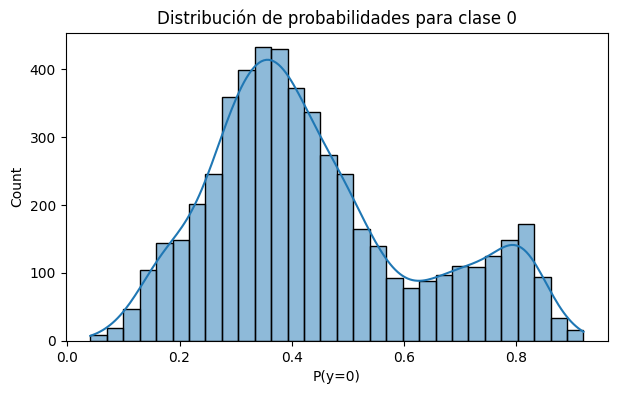

In [177]:
proba0 = best_xgb.predict_proba(X_test)[:, 0]

plt.figure(figsize=(7,4))
sns.histplot(proba0, bins=30, kde=True)
plt.title("Distribución de probabilidades para clase 0")
plt.xlabel("P(y=0)")
plt.show()

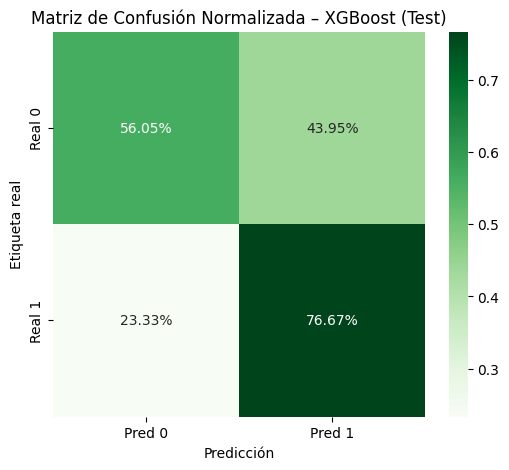

In [178]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocessor', 'model']
Features esperados: 129
Importances entregados: 129

Top 30 Features más importantes:


CSP_NutricionFam_1              0.381500
educmadresimplificada_1         0.033159
CP_TP_Toxoplasmosis_4           0.032534
CP_TP_HepatitisB_1              0.025362
AnioParto                       0.023634
Iden_Sede                       0.020160
CSP_EscolaridadMadre_2          0.019470
CP_TP_Toxoplasmosis_1           0.018252
CP_TP_HIV_1                     0.015165
educpadresimplificada_1         0.011805
CP_TP_Orina                     0.008778
educmadresimplificada_2         0.008196
corticodosis                    0.008157
pdpcat_2                        0.007955
CP_HospitalizacionesPreParto    0.007822
CP_SA_InfGineco_0.0             0.007695
CSP_SituaPareja_3               0.007589
CSP_Menores5vivenMadre          0.007510
CSP_SituacionLaboralPadre_2     0.007200
ecocat                          0.007191
educpadresimplificada_2         0.007037
Iden_embarazoMultiple_0.0       0.006968
CSP_DistanciaVivienda_4         0.006953
CP_MedGeneral                   0.006940
CSP_EscolaridadP

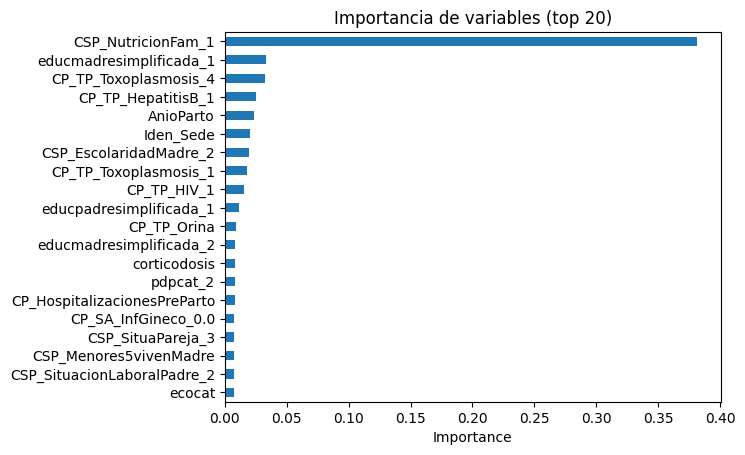

In [179]:
# Tomar los nombres de los pasos
step_names = list(best_xgb.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_xgb.named_steps[preproc_name]
xgb_best = best_xgb.named_steps[clf_name]

# 1.1 Nombres de columnas numéricas (sin transformar)
num_cols = preproc.transformers_[0][2]

# 1.2 Nombres de columnas categóricas transformadas
ohe = preproc.transformers_[1][1]       # OneHotEncoder
cat_cols = preproc.transformers_[1][2]  # columnas originales categóricas
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# 1.3 Unimos todas las columnas transformadas
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

# 1.4 Importance del modelo
importances = xgb_best.feature_importances_

# Validación por si hay mismatch
print("Features esperados:", len(all_feature_names))
print("Importances entregados:", len(importances))

# Crear tabla ordenada
feat_imp = pd.Series(importances, index=all_feature_names)\
                .sort_values(ascending=False)

print("\nTop 30 Features más importantes:")
display(feat_imp.head(30))


# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()


In [180]:
def var_original_from_encoded(name):
    # Quitar prefijo num__ o cat__
    name = name.replace("num__", "").replace("cat__", "")
    # Quitar sufijo del nivel de categoría si existe
    return name.split("_")[0]


In [181]:
feat_imp_by_var = (
    feat_imp
        .groupby(var_original_from_encoded)
        .sum()
        .sort_values(ascending=False)
)

In [182]:
umbral = 0.002
vars_ruido_original = feat_imp_by_var[feat_imp_by_var < umbral].index.tolist()

vars_ruido_original

[]

##### Guardar modelo

In [183]:
best_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['CP_ARO', 'corticodosis',
                                                   'ecocat', 'CP_edadmaterna',
                                                   'CP_HospitalizacionesPreParto',
                                                   'CP_MesInicCP',
                                                   'CP_NumEcografias',
                                                   'CP_MedGeneral',
                                                   'RELACIONAROSOBRETOTALCONSULTAS',
                                                   'CP_TotalCPN', 'CP_TP_Orina',
                                                   'trimestre', 'Iden_Sede',
                                                   'CP_TallaMadre',...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [185]:
joblib.dump (best_xgb, "modeloxgb_fase2_infanib.pkl")
print("Modelo guardado como modeloxgb_fase2_infanib.pkl")

Modelo guardado como modeloxgb_fase2_infanib.pkl


In [186]:
#Cargar modelo
modelo = joblib.load("modeloxgb_fase1_infanib.pkl")

##### Guardar modelo

In [187]:
type(best_model)

sklearn.pipeline.Pipeline

In [188]:
joblib.dump(best_model, "modelorf_fase2_infanib.pkl")
print("Modelo guardado como modelorf_fase1_infanib.pkl")

Modelo guardado como modelorf_fase1_infanib.pkl


In [189]:
#Ejemplo de carga
modelo_rf = joblib.load("modelorf_fase1_infanib.pkl")

pred  = modelo_rf.predict(X_test)
proba = modelo_rf.predict_proba(X_test)[:, 1]

### Modelo hasta fase 3 con variables posición canguro (infanib12m)

In [190]:
df_fase3_modelo

,Idenfinal,IQ12cat,infanib12m_bin,ERN_PC,ERN_Peso,ERN_Talla,ERN_AdaptNeonatal,anoxia5mn,ERN_A_10min,ERN_A_1min,ERN_A_5min,apgarcat1,apgarcat5,BPN,ERN_Ballard,gestacat,INFECCIONOSOCOMIAL,ERN_LubchencoFenton,menosde1001,menosde31sem,Nearterm,pesocat,PESO1500G,RCIUPC,RCIUtalla,ERN_Remision,ERN_sepsis,ERN_Sexo,HD_DiasAlojamiento,DIASTOT08,ANOCAT,PA_AtendioParto,cesarea,PA_ComplicacionsPartoAbrupcio,PA_ComplicacionsPartoAmnionitis,PA_ComplicacionsPartoEclampsia,PA_ComplicacionsPartoMultiples,PA_ComplicacionsPartoPatologIaCordOn,PA_ComplicacionsPartoPlacentaPrevia,PA_ComplicacionsPartoPreeclampsia,PA_ComplicacionsPartoSindromedehellp,PA_EstActualMadre,tuvotransfusiones,UCI,PA_LiqAmnioticoMeconiado,PA_LugarNacimiento,PA_Monitoreo,PA_NumDosisCorticoides,primipara,PA_RitmoCardiaco,PA_SufrimientoFetalAgudo,PA_TipoParto,CONSULT08,ecocerebral,REHOSP08,rehosp40,CP_ARO,AROCAT02,controlcat,corticodosis,corticoprenatalsimple,ecocat,CP_edadmaterna,embarazoplanifDIU,embarazoplanifhormonal,CP_HospitalizacionesPreParto,CP_MadreAlcohol,CP_MadreFumo,CP_MesInicCP,CP_NumEcografias,pdpcat,CP_MedGeneral,RELACIONAROSOBRETOTALCONSULTAS,CP_SA_Anemia,CP_SA_APP,CP_SA_EnfRespiratoria,CP_SA_InfGineco,CP_SA_InfUrinaria,CP_SA_Preclampsia,CP_SA_RPM,CP_SA_Sangrado,Sufrimientofetalcronico,CP_TotalCPN,toxemia,CP_TP_HepatitisB,CP_TP_HIV,CP_TP_Orina,CP_TP_Rubeola,CP_TP_Sifilis,CP_TP_Toxoplasmosis,trimestre,CSP_EmbarazoDeseado,Iden_embarazoMultiple,Iden_Sede,Iden_FechaParto,edadmatcat,educmadresimplificada,educpadresimplificada,CP_TallaMadre,CSP_DistanciaVivienda,CSP_EscolaridadMadre,CSP_EscolaridadPadre,CSP_IngresoMensual,CSP_Menores5vivenMadre,ninosmenosde5anos,CSP_numPersVivenIngMen,CSP_NutricionFam,CSP_SituacionLaboralMadre,CSP_SituacionLaboralPadre,CSP_SituaPareja
0,1005052,True,1,27.0,1111.0,38.0,1,False,10,8,10,4,4,False,28.0,1,False,1,False,True,False,2,True,False,False,False,2,1,0,3.0,6,1,True,False,False,False,False,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,10.0,True,2.0,True,4,1,1,1,0,1.0,38.0,False,False,0,False,False,1,3,2,2,59.06184,False,True,False,True,False,False,False,False,False,4,False,4,1,4,3,1,4,1,True,False,1,2008-03-11,3,2,2,159.130753,1,3,3,900000.0,1,True,5,1,1,1,3
1,1005053,True,1,31.343039,1980.0,43.0,1,True,10,7,9,3,4,False,34.0,3,False,1,False,False,True,5,False,False,False,False,0,1,0,0.0,6,1,True,False,False,False,False,False,False,True,False,1,False,False,0,1,False,1,False,0,0,2,8.0,True,0.0,False,5,1,2,0,0,2.0,29.0,False,False,0,False,False,1,4,1,2,64.417168,False,True,False,True,True,True,False,True,False,7,True,4,1,3,3,1,1,1,True,False,1,2008-04-18,2,3,3,155.947418,1,7,7,1000000.0,1,True,3,1,1,1,3
2,1005054,True,1,31.0,2100.0,43.0,1,True,9,7,8,3,4,False,33.0,3,False,1,False,False,False,6,False,False,False,False,2,1,0,0.0,6,1,True,False,False,False,True,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,9.0,True,0.0,False,6,1,3,1,0,2.0,21.0,False,True,0,False,False,1,4,1,1,70.13781,False,True,False,False,True,False,False,False,False,14,False,4,1,2,1,1,1,1,False,True,1,2008-04-16,2,3,3,157.673935,1,7,7,1974527.75,2,True,3,1,3,1,1
3,1005057,True,1,30.805439,1743.0,42.0,1,False,10,9,10,4,4,False,30.0,1,False,1,False,True,False,4,False,False,False,False,0,1,0,1.0,6,1,True,False,False,False,False,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,11.0,True,1.0,True,6,1,3,1,0,2.0,28.0,False,False,0,False,False,1,6,2,2,65.500465,False,False,False,False,False,False,False,False,False,17,False,4,1,4,3,1,1,1,True,False,1,2008-04-01,2,1,1,160.671936,1,1,1,2000000.0,1,True,3,1,1,1,3
4,1005058,True,1,33.0,2210.0,44.0,1,True,10,6,8,3,4,False,35.0,4,False,1,False,False,True,6,False,False,False,False,0,1,0,0.000121,6,1,True,False,False,False,False,False,False,True,False,1,False,True,0,1,False,1,False,0,0,2,0.0,True,0.000204,False,8,1,2,0,0,2.0,41.0,False,False,0,False,False,1,8,1,1,74.436562,False,True,False,False,True,True,False,False,False,6,True,4,1,2,3,1,1,1,False,False,1,2008-04-18,3,3,3,156.915085,1,7,7,25

In [191]:
#Merge de los dataframes de la fase 0 y 1
df_fase3_modelo = df_pos_canguro.merge(df_fase3_modelo, on=["Idenfinal"],how="inner")

In [ ]:
#df_fase3_modelo.to_csv("modelos_fase3/df_fase3.csv", index=False, index_label=False)

In [192]:
df_fase3_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26155 entries, 0 to 26154
Columns: 114 entries, Idenfinal to CSP_SituaPareja
dtypes: Float32(12), Int64(15), boolean(44), category(40), datetime64[ns](1), int64(2)
memory usage: 8.7 MB


##### Preparación

In [193]:
vars_ruido_original = []

In [194]:
df = df_fase3_modelo.copy()


# Target binaria
y = df["infanib12m_bin"].astype(int)

# Columnas que no son predictores
id_cols = ["Idenfinal"]
target_col = ['infanib12m_bin', "IQ12cat"]

# Solo extraemos el año del parto
if np.issubdtype(df["Iden_FechaParto"].dtype, np.datetime64):
    df["AnioParto"] = df["Iden_FechaParto"].dt.year
    df = df.drop(columns=["Iden_FechaParto"])

# Predictores
feature_cols = [c for c in df.columns if c not in id_cols + target_col+ vars_ruido_original]
X = df[feature_cols]

# Separar numericas de categoricas
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['ERN_PC', 'ERN_Peso', 'ERN_Talla', 'ERN_Ballard', 'HD_DiasAlojamiento', 'DIASTOT08', 'ANOCAT', 'PA_NumDosisCorticoides', 'CONSULT08', 'REHOSP08', 'CP_ARO', 'corticodosis', 'ecocat', 'CP_edadmaterna', 'CP_HospitalizacionesPreParto', 'CP_MesInicCP', 'CP_NumEcografias', 'CP_MedGeneral', 'RELACIONAROSOBRETOTALCONSULTAS', 'CP_TotalCPN', 'CP_TP_Orina', 'trimestre', 'Iden_Sede', 'CP_TallaMadre', 'CSP_IngresoMensual', 'CSP_Menores5vivenMadre', 'CSP_numPersVivenIngMen', 'AnioParto']
Categóricas: ['CSP_AyudaPerm1mes', 'V204', 'V208', 'V209', 'ERN_AdaptNeonatal', 'anoxia5mn', 'ERN_A_10min', 'ERN_A_1min', 'ERN_A_5min', 'apgarcat1', 'apgarcat5', 'BPN', 'gestacat', 'INFECCIONOSOCOMIAL', 'ERN_LubchencoFenton', 'menosde1001', 'menosde31sem', 'Nearterm', 'pesocat', 'PESO1500G', 'RCIUPC', 'RCIUtalla', 'ERN_Remision', 'ERN_sepsis', 'ERN_Sexo', 'PA_AtendioParto', 'cesarea', 'PA_ComplicacionsPartoAbrupcio', 'PA_ComplicacionsPartoAmnionitis', 'PA_ComplicacionsPartoEclampsia', 'PA_ComplicacionsPa

In [195]:
len(categorical_cols)

83

##### Split en conjuntos de entrenamiento y prueba

In [196]:
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2,
                                                     random_state=42, stratify=y)

#### XGBoost

##### Pipeline con preprocesamiento y modelo

In [197]:
# Peso de clases para XGBoost
counts = y_train.value_counts()
print("Distribución en train:\n", counts)
scale_pos_weight = counts[0] / counts[1]   # mayor peso a la clase 1
print("scale_pos_weight:", scale_pos_weight)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Modelo base XGBoost
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",   # evita warnings
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",      # más rápido en CPU
    scale_pos_weight=scale_pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_clf)   #  nombre para acceder fácil después
])


Distribución en train:
 infanib12m_bin
1    20088
0      836
Name: count, dtype: int64
scale_pos_weight: 0.04161688570290721


In [198]:
X_train.shape

(20924, 111)

##### GridSearch de hiperparámetros

In [199]:
# Búsqueda de hiperparámetros (ligera para no matar el PC)
param_grid = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.05, 0.1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score, pos_label=0)

In [200]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid, cv=cv, scoring=recall_scorer, 
                        n_jobs=-1,verbose=2)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ERN_PC',
                                                                          'ERN_Peso',
                                                                          'ERN_Talla',
                                                                          'ERN_Ballard',
                                                                          'HD_DiasAlojamiento',
                                                                          'DIASTOT08',
                                                                          'ANOCAT',
                                                                          'PA_NumDosisCorticoides',
                                                                          'CONSULT08',
                                                                          'REHOSP08',
                                                                          'CP_ARO',
                                                                          'cor...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [300, 500, 800]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=0),
             verbose=2)

##### Evaluación

In [201]:
best_xgb = grid_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:,1]
y_pred = best_xgb.predict(X_test)

print("Recall TRAIN:", recall_score(y_train, y_train_pred))
print("Recall TEST:", recall_score(y_test, y_pred))

print("Precision TRAIN:", precision_score(y_train, y_train_pred))
print("Precision TEST:", precision_score(y_test, y_pred))


Recall TRAIN: 0.7615491835921944
Recall TEST: 0.7481083233771406
Precision TRAIN: 0.9832251430040491
Precision TEST: 0.9783854166666667


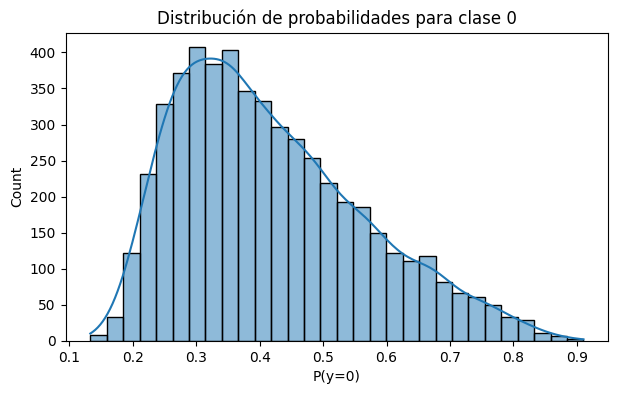

In [202]:
proba0 = best_xgb.predict_proba(X_test)[:, 0]

plt.figure(figsize=(7,4))
sns.histplot(proba0, bins=30, kde=True)
plt.title("Distribución de probabilidades para clase 0")
plt.xlabel("P(y=0)")
plt.show()

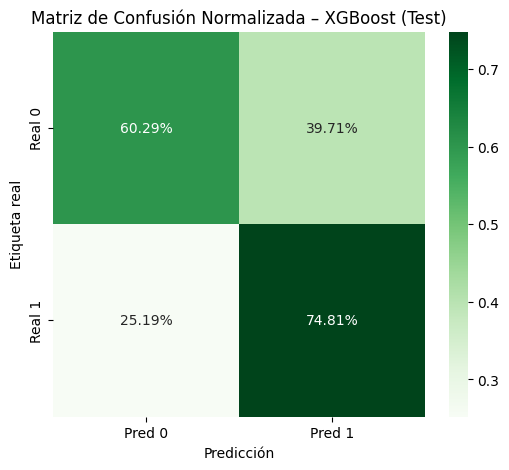

In [203]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocessor', 'model']
Features esperados: 289
Importances entregados: 289

Top 30 Features más importantes:


UCI_0.0                    0.050934
ERN_PC                     0.046543
ERN_Peso                   0.042841
AnioParto                  0.034842
educmadresimplificada_1    0.028527
tuvotransfusiones_0.0      0.025514
CONSULT08                  0.024866
ERN_Sexo_1                 0.024423
CSP_NutricionFam_1         0.022525
V204_1                     0.021823
CSP_EscolaridadMadre_2     0.021480
apgarcat1_4                0.020192
anoxia5mn_0.0              0.019180
ERN_Talla                  0.018674
ANOCAT                     0.018396
DIASTOT08                  0.017698
CP_edadmaterna             0.016963
INFECCIONOSOCOMIAL_0.0     0.016830
PA_NumDosisCorticoides     0.016447
Iden_Sede                  0.015295
RCIUPC_0.0                 0.015049
PA_EstActualMadre_1        0.014941
V209_1                     0.014756
educpadresimplificada_3    0.013499
REHOSP08                   0.012922
educpadresimplificada_2    0.012306
CP_SA_APP_0.0              0.012036
ERN_LubchencoFenton_1      0

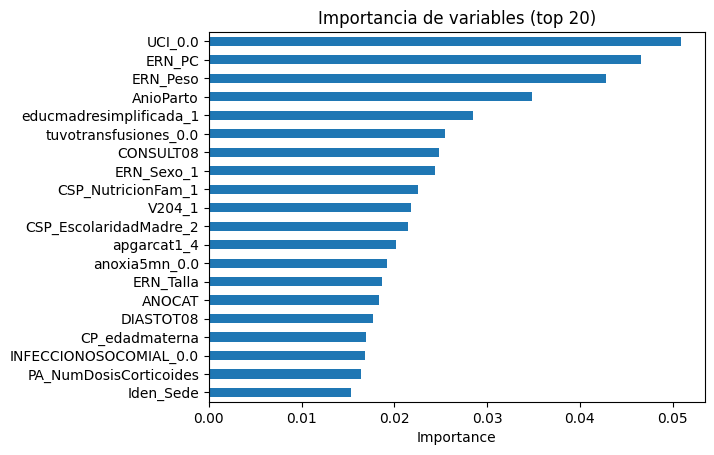

In [204]:
# Tomar los nombres de los pasos
step_names = list(best_xgb.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_xgb.named_steps[preproc_name]
xgb_best = best_xgb.named_steps[clf_name]

# 1.1 Nombres de columnas numéricas (sin transformar)
num_cols = preproc.transformers_[0][2]

# 1.2 Nombres de columnas categóricas transformadas
ohe = preproc.transformers_[1][1]       # OneHotEncoder
cat_cols = preproc.transformers_[1][2]  # columnas originales categóricas
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# 1.3 Unimos todas las columnas transformadas
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

# 1.4 Importance del modelo
importances = xgb_best.feature_importances_

# Validación por si hay mismatch
print("Features esperados:", len(all_feature_names))
print("Importances entregados:", len(importances))

# Crear tabla ordenada
feat_imp = pd.Series(importances, index=all_feature_names)\
                .sort_values(ascending=False)

print("\nTop 30 Features más importantes:")
display(feat_imp.head(30))


# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()


##### Guardar modelo

In [205]:
best_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ERN_PC', 'ERN_Peso',
                                                   'ERN_Talla', 'ERN_Ballard',
                                                   'HD_DiasAlojamiento',
                                                   'DIASTOT08', 'ANOCAT',
                                                   'PA_NumDosisCorticoides',
                                                   'CONSULT08', 'REHOSP08',
                                                   'CP_ARO', 'corticodosis',
                                                   'ecocat', 'CP_edadmaterna',
                                                   'CP_HospitalizacionesPreParto',
                                                   'CP_MesInicCP',...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [207]:
joblib.dump (best_xgb, "modeloxgb_fase3_infanib.pkl")
print("Modelo guardado como modeloxgb_fase2_infanib.pkl")

Modelo guardado como modeloxgb_fase2_infanib.pkl


In [ ]:
#Cargar modelo
#modelo = joblib.load("modelos_fase1/modeloxgb_fase1_infanib.pkl")

### Modelo hasta fase 3 con variables posicion canguro (IQ12cat)

##### Preparación

In [208]:
df = df_fase3_modelo.copy()

# Target binaria
y = df["IQ12cat"].astype(int)

# Columnas que no son predictores
id_cols = ["Idenfinal"]
target_col = ['infanib12m_bin', "IQ12cat"]

# Solo extraemos el año del parto
if np.issubdtype(df["Iden_FechaParto"].dtype, np.datetime64):
    df["AnioParto"] = df["Iden_FechaParto"].dt.year
    df = df.drop(columns=["Iden_FechaParto"])

# Predictores
feature_cols = [c for c in df.columns if c not in id_cols + target_col]
X = df[feature_cols]

# Separar numericas de categoricas
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['ERN_PC', 'ERN_Peso', 'ERN_Talla', 'ERN_Ballard', 'HD_DiasAlojamiento', 'DIASTOT08', 'ANOCAT', 'PA_NumDosisCorticoides', 'CONSULT08', 'REHOSP08', 'CP_ARO', 'corticodosis', 'ecocat', 'CP_edadmaterna', 'CP_HospitalizacionesPreParto', 'CP_MesInicCP', 'CP_NumEcografias', 'CP_MedGeneral', 'RELACIONAROSOBRETOTALCONSULTAS', 'CP_TotalCPN', 'CP_TP_Orina', 'trimestre', 'Iden_Sede', 'CP_TallaMadre', 'CSP_IngresoMensual', 'CSP_Menores5vivenMadre', 'CSP_numPersVivenIngMen', 'AnioParto']
Categóricas: ['CSP_AyudaPerm1mes', 'V204', 'V208', 'V209', 'ERN_AdaptNeonatal', 'anoxia5mn', 'ERN_A_10min', 'ERN_A_1min', 'ERN_A_5min', 'apgarcat1', 'apgarcat5', 'BPN', 'gestacat', 'INFECCIONOSOCOMIAL', 'ERN_LubchencoFenton', 'menosde1001', 'menosde31sem', 'Nearterm', 'pesocat', 'PESO1500G', 'RCIUPC', 'RCIUtalla', 'ERN_Remision', 'ERN_sepsis', 'ERN_Sexo', 'PA_AtendioParto', 'cesarea', 'PA_ComplicacionsPartoAbrupcio', 'PA_ComplicacionsPartoAmnionitis', 'PA_ComplicacionsPartoEclampsia', 'PA_ComplicacionsPa

##### Split en conjuntos de entrenamiento y prueba

In [209]:
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2,
                                                     random_state=42, stratify=y)

#### XGBoost

##### Pipeline con preprocesamiento y modelo

In [210]:
# Peso de clases para XGBoost
counts = y_train.value_counts()
print("Distribución en train:\n", counts)
scale_pos_weight = counts[0] / counts[1]   # mayor peso a la clase 1
print("scale_pos_weight:", scale_pos_weight)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Modelo base XGBoost
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",   # evita warnings
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",      # más rápido en CPU
    scale_pos_weight=scale_pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_clf)   #  nombre para acceder fácil después
])


Distribución en train:
 IQ12cat
1    16955
0     3969
Name: count, dtype: int64
scale_pos_weight: 0.23409023886759067


In [211]:
X_train.shape

(20924, 111)

##### GridSearch de hiperparámetros

In [212]:
# Búsqueda de hiperparámetros (ligera para no matar el PC)
param_grid = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.05, 0.1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score, pos_label=0)

In [213]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid, cv=cv, scoring=recall_scorer, 
                        n_jobs=-1,verbose=2)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ERN_PC',
                                                                          'ERN_Peso',
                                                                          'ERN_Talla',
                                                                          'ERN_Ballard',
                                                                          'HD_DiasAlojamiento',
                                                                          'DIASTOT08',
                                                                          'ANOCAT',
                                                                          'PA_NumDosisCorticoides',
                                                                          'CONSULT08',
                                                                          'REHOSP08',
                                                                          'CP_ARO',
                                                                          'cor...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [300, 500, 800]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=0),
             verbose=2)

##### Evaluación

In [214]:
best_xgb = grid_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:,1]
y_pred = best_xgb.predict(X_test)

print("Recall TRAIN:", recall_score(y_train, y_train_pred))
print("Recall TEST:", recall_score(y_test, y_pred))

print("Precision TRAIN:", precision_score(y_train, y_train_pred))
print("Precision TEST:", precision_score(y_test, y_pred))


Recall TRAIN: 0.7817163078737835
Recall TEST: 0.7640953054965793
Precision TRAIN: 0.9045246707158944
Precision TEST: 0.8920407601211787


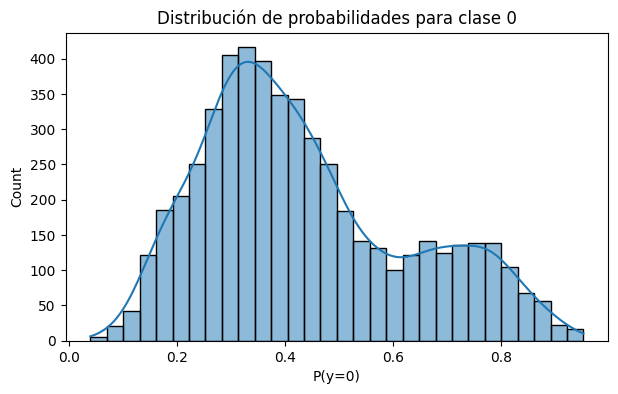

In [215]:
proba0 = best_xgb.predict_proba(X_test)[:, 0]

plt.figure(figsize=(7,4))
sns.histplot(proba0, bins=30, kde=True)
plt.title("Distribución de probabilidades para clase 0")
plt.xlabel("P(y=0)")
plt.show()

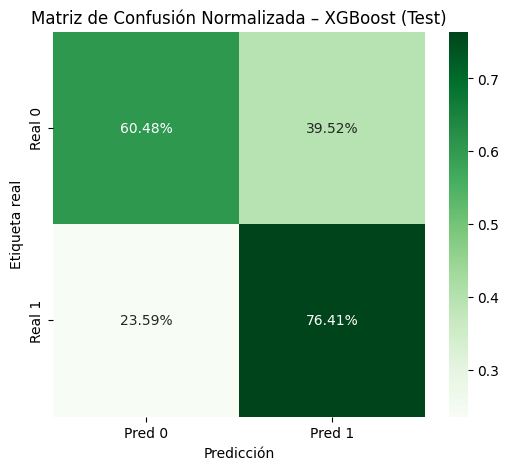

In [216]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocessor', 'model']
Features esperados: 289
Importances entregados: 289

Top 30 Features más importantes:


CSP_NutricionFam_1            0.195878
educmadresimplificada_1       0.023394
CSP_EscolaridadMadre_2        0.022841
UCI_0.0                       0.022136
anoxia5mn_0.0                 0.020440
ANOCAT                        0.020189
gestacat_5                    0.019305
CP_TP_Toxoplasmosis_1         0.016089
Iden_Sede                     0.014738
V209_1                        0.013694
PA_SufrimientoFetalAgudo_0    0.013428
ERN_Peso                      0.010294
INFECCIONOSOCOMIAL_0.0        0.010023
CSP_EscolaridadPadre_2        0.009849
AnioParto                     0.009805
educpadresimplificada_1       0.009305
apgarcat1_4                   0.009293
CP_TP_HIV_4                   0.008904
BPN_0.0                       0.008771
corticoprenatalsimple_1       0.008695
apgarcat5_4                   0.008394
ERN_AdaptNeonatal_1           0.008369
ERN_Ballard                   0.007865
menosde31sem_0.0              0.007796
CP_TP_HepatitisB_1            0.007724
ERN_A_1min_8             

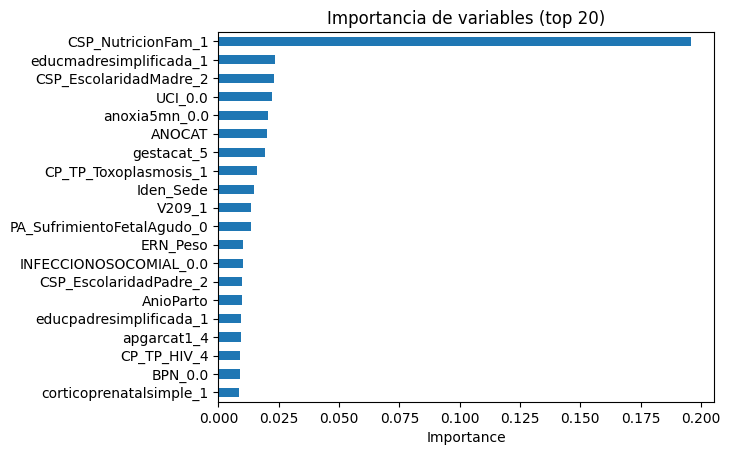

In [217]:
# Tomar los nombres de los pasos
step_names = list(best_xgb.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_xgb.named_steps[preproc_name]
xgb_best = best_xgb.named_steps[clf_name]

# 1.1 Nombres de columnas numéricas (sin transformar)
num_cols = preproc.transformers_[0][2]

# 1.2 Nombres de columnas categóricas transformadas
ohe = preproc.transformers_[1][1]       # OneHotEncoder
cat_cols = preproc.transformers_[1][2]  # columnas originales categóricas
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# 1.3 Unimos todas las columnas transformadas
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

# 1.4 Importance del modelo
importances = xgb_best.feature_importances_

# Validación por si hay mismatch
print("Features esperados:", len(all_feature_names))
print("Importances entregados:", len(importances))

# Crear tabla ordenada
feat_imp = pd.Series(importances, index=all_feature_names)\
                .sort_values(ascending=False)

print("\nTop 30 Features más importantes:")
display(feat_imp.head(30))


# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()


##### Guardar modelo

In [218]:
best_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ERN_PC', 'ERN_Peso',
                                                   'ERN_Talla', 'ERN_Ballard',
                                                   'HD_DiasAlojamiento',
                                                   'DIASTOT08', 'ANOCAT',
                                                   'PA_NumDosisCorticoides',
                                                   'CONSULT08', 'REHOSP08',
                                                   'CP_ARO', 'corticodosis',
                                                   'ecocat', 'CP_edadmaterna',
                                                   'CP_HospitalizacionesPreParto',
                                                   'CP_MesInicCP',...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [219]:
joblib.dump (best_xgb, "modeloxgb_fase3_iq12cat.pkl")
print("Modelo guardado como modeloxgb_fase2_iq12cat.pkl")

Modelo guardado como modeloxgb_fase2_iq12cat.pkl


In [220]:
#Cargar modelo
#modelo = joblib.load("modelos_fase1/modeloxgb_fase1_infanib.pkl")

### Modelo hasta fase 4 con variables posición canguro (infanib12m)

In [221]:
df_fase3_modelo

,Idenfinal,CSP_AyudaPerm1mes,V204,V208,V209,IQ12cat,infanib12m_bin,ERN_PC,ERN_Peso,ERN_Talla,ERN_AdaptNeonatal,anoxia5mn,ERN_A_10min,ERN_A_1min,ERN_A_5min,apgarcat1,apgarcat5,BPN,ERN_Ballard,gestacat,INFECCIONOSOCOMIAL,ERN_LubchencoFenton,menosde1001,menosde31sem,Nearterm,pesocat,PESO1500G,RCIUPC,RCIUtalla,ERN_Remision,ERN_sepsis,ERN_Sexo,HD_DiasAlojamiento,DIASTOT08,ANOCAT,PA_AtendioParto,cesarea,PA_ComplicacionsPartoAbrupcio,PA_ComplicacionsPartoAmnionitis,PA_ComplicacionsPartoEclampsia,PA_ComplicacionsPartoMultiples,PA_ComplicacionsPartoPatologIaCordOn,PA_ComplicacionsPartoPlacentaPrevia,PA_ComplicacionsPartoPreeclampsia,PA_ComplicacionsPartoSindromedehellp,PA_EstActualMadre,tuvotransfusiones,UCI,PA_LiqAmnioticoMeconiado,PA_LugarNacimiento,PA_Monitoreo,PA_NumDosisCorticoides,primipara,PA_RitmoCardiaco,PA_SufrimientoFetalAgudo,PA_TipoParto,CONSULT08,ecocerebral,REHOSP08,rehosp40,CP_ARO,AROCAT02,controlcat,corticodosis,corticoprenatalsimple,ecocat,CP_edadmaterna,embarazoplanifDIU,embarazoplanifhormonal,CP_HospitalizacionesPreParto,CP_MadreAlcohol,CP_MadreFumo,CP_MesInicCP,CP_NumEcografias,pdpcat,CP_MedGeneral,RELACIONAROSOBRETOTALCONSULTAS,CP_SA_Anemia,CP_SA_APP,CP_SA_EnfRespiratoria,CP_SA_InfGineco,CP_SA_InfUrinaria,CP_SA_Preclampsia,CP_SA_RPM,CP_SA_Sangrado,Sufrimientofetalcronico,CP_TotalCPN,toxemia,CP_TP_HepatitisB,CP_TP_HIV,CP_TP_Orina,CP_TP_Rubeola,CP_TP_Sifilis,CP_TP_Toxoplasmosis,trimestre,CSP_EmbarazoDeseado,Iden_embarazoMultiple,Iden_Sede,Iden_FechaParto,edadmatcat,educmadresimplificada,educpadresimplificada,CP_TallaMadre,CSP_DistanciaVivienda,CSP_EscolaridadMadre,CSP_EscolaridadPadre,CSP_IngresoMensual,CSP_Menores5vivenMadre,ninosmenosde5anos,CSP_numPersVivenIngMen,CSP_NutricionFam,CSP_SituacionLaboralMadre,CSP_SituacionLaboralPadre,CSP_SituaPareja
0,1005052,True,1,1,9,True,1,27.0,1111.0,38.0,1,False,10,8,10,4,4,False,28.0,1,False,1,False,True,False,2,True,False,False,False,2,1,0,3.0,6,1,True,False,False,False,False,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,10.0,True,2.0,True,4,1,1,1,0,1.0,38.0,False,False,0,False,False,1,3,2,2,59.06184,False,True,False,True,False,False,False,False,False,4,False,4,1,4,3,1,4,1,True,False,1,2008-03-11,3,2,2,159.130753,1,3,3,900000.0,1,True,5,1,1,1,3
1,1005053,True,2,1,2,True,1,31.343039,1980.0,43.0,1,True,10,7,9,3,4,False,34.0,3,False,1,False,False,True,5,False,False,False,False,0,1,0,0.0,6,1,True,False,False,False,False,False,False,True,False,1,False,False,0,1,False,1,False,0,0,2,8.0,True,0.0,False,5,1,2,0,0,2.0,29.0,False,False,0,False,False,1,4,1,2,64.417168,False,True,False,True,True,True,False,True,False,7,True,4,1,3,3,1,1,1,True,False,1,2008-04-18,2,3,3,155.947418,1,7,7,1000000.0,1,True,3,1,1,1,3
2,1005054,True,2,1,9,True,1,31.0,2100.0,43.0,1,True,9,7,8,3,4,False,33.0,3,False,1,False,False,False,6,False,False,False,False,2,1,0,0.0,6,1,True,False,False,False,True,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,9.0,True,0.0,False,6,1,3,1,0,2.0,21.0,False,True,0,False,False,1,4,1,1,70.13781,False,True,False,False,True,False,False,False,False,14,False,4,1,2,1,1,1,1,False,True,1,2008-04-16,2,3,3,157.673935,1,7,7,1974527.75,2,True,3,1,3,1,1
3,1005057,True,1,1,9,True,1,30.805439,1743.0,42.0,1,False,10,9,10,4,4,False,30.0,1,False,1,False,True,False,4,False,False,False,False,0,1,0,1.0,6,1,True,False,False,False,False,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,11.0,True,1.0,True,6,1,3,1,0,2.0,28.0,False,False,0,False,False,1,6,2,2,65.500465,False,False,False,False,False,False,False,False,False,17,False,4,1,4,3,1,1,1,True,False,1,2008-04-01,2,1,1,160.671936,1,1,1,2000000.0,1,True,3,1,1,1,3
4,1005058,True,1,1,9,True,1,33.0,2210.0,44.0,1,True,10,6,8,3,4,False,35.0,4,False,1,False,False,True,6,False,False,False,False,0,1,0,0.000121,6,1,True,False,False,False,False,False,False,True,False,1,False,True,0,1,False,1,False,0,0,2,0.0,True,0.000204,False,8,1,2,0,0,2.0,41.0,False,False,0,False,False,1,8,1,1,74.436562,False,True,False,False,True,True,F

In [222]:
dfs_por_fase[4]

,Idenfinal,IQ12cat,infanib12m_bin,V220,V218,V219,V246,DIASTOT09,V237,V238,NEURO40,algoLM40sem,ali40,V223,V221,V222,Indexnutricion40sem,LME40,V216,V235A,V235,CONSULT09,V236G,mortalidadhasta40sem,oftalmologia,oftalmopato,V236F,REHOSP09,V249,vacunas40semBCG,vacunas40semHepB,vino40
5049,1005052,True,1,37.0,3810.0,47.0,3,3.0,2,3,3,True,2,2,2,1,1,False,85.0,0,10,26.0,1,0,2,2,1,2.0,2,1,1,1
5050,1005053,True,1,36.0,3170.0,46.0,4,0.0,0,0,0,True,1,2,1,2,0,True,40.0,0,8,18.0,9,0,2,2,2,0.0,2,1,1,1
5051,1005054,True,1,34.0,2790.0,46.5,4,0.0,0,0,0,True,1,2,1,2,1,True,44.0,0,9,20.0,9,0,2,2,2,0.0,2,1,1,1
5054,1005057,True,1,36.0,3870.0,50.5,4,1.0,1,1,0,True,2,2,2,1,1,False,94.0,0,11,30.0,1,0,2,2,1,1.0,2,1,1,1
5055,1005058,True,1,34.789112,2914.383057,47.428928,4,1.098777,0,0,0,True,1,2,1,2,1,True,21.94923,0,0,0.0,9,0,0,2,2,0.033509,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64634,4012747,True,1,34.5,2940.0,49.5,4,0.0,0,0,0,True,1,2,1,2,1,True,30.549019,0,4,4.0,9,0,2,2,2,0.0,2,1,1,1
64635,4012807,True,1,35.5,2990.0,49.0,4,0.0,0,0,0,True,1,2,1,2,1,True,34.960911,0,6,12.0,9,0,2,2,2,0.0,2,1,1,1
64637,4012819,True,1,37.0,3480.0,50.0,4,0.0,0,0,0,True,1,2,1,2,1,True,40.719585,0,7,28.0,9,0,2,2,2,0.0,2,1,1,1
64639,4012897,True,1,36.5,3210.0,48.0,4,0.0,0,0,0,True,2,2,1,2,1,True,29.373453,0,6,14.0,9,0,2,2,2,0.0,2,1,1,1


In [223]:
#Merge de los dataframes de la fase 0 y 1
df_fase4_modelo = dfs_por_fase[4].merge(df_fase3_modelo, on=["Idenfinal", "IQ12cat", "infanib12m_bin"],how="inner")

In [224]:
#df_fase4_modelo.to_csv("modelos_fase4/df_fase4.csv", index=False, index_label=False)

In [225]:
df_fase4_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26155 entries, 0 to 26154
Columns: 143 entries, Idenfinal to CSP_SituaPareja
dtypes: Float32(19), Int64(19), boolean(46), category(56), datetime64[ns](1), int64(2)
memory usage: 10.9 MB


##### Preparación

In [226]:
vars_ruido_original = []

In [227]:
df = df_fase4_modelo.copy()


# Target binaria
y = df["infanib12m_bin"].astype(int)

# Columnas que no son predictores
id_cols = ["Idenfinal"]
target_col = ['infanib12m_bin', "IQ12cat"]

# Solo extraemos el año del parto
if np.issubdtype(df["Iden_FechaParto"].dtype, np.datetime64):
    df["AnioParto"] = df["Iden_FechaParto"].dt.year
    df = df.drop(columns=["Iden_FechaParto"])

# Predictores
feature_cols = [c for c in df.columns if c not in id_cols + target_col+ vars_ruido_original]
X = df[feature_cols]

# Separar numericas de categoricas
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['V220', 'V218', 'V219', 'DIASTOT09', 'V237', 'V238', 'V216', 'V235A', 'V235', 'CONSULT09', 'REHOSP09', 'ERN_PC', 'ERN_Peso', 'ERN_Talla', 'ERN_Ballard', 'HD_DiasAlojamiento', 'DIASTOT08', 'ANOCAT', 'PA_NumDosisCorticoides', 'CONSULT08', 'REHOSP08', 'CP_ARO', 'corticodosis', 'ecocat', 'CP_edadmaterna', 'CP_HospitalizacionesPreParto', 'CP_MesInicCP', 'CP_NumEcografias', 'CP_MedGeneral', 'RELACIONAROSOBRETOTALCONSULTAS', 'CP_TotalCPN', 'CP_TP_Orina', 'trimestre', 'Iden_Sede', 'CP_TallaMadre', 'CSP_IngresoMensual', 'CSP_Menores5vivenMadre', 'CSP_numPersVivenIngMen', 'AnioParto']
Categóricas: ['V246', 'NEURO40', 'algoLM40sem', 'ali40', 'V223', 'V221', 'V222', 'Indexnutricion40sem', 'LME40', 'V236G', 'mortalidadhasta40sem', 'oftalmologia', 'oftalmopato', 'V236F', 'V249', 'vacunas40semBCG', 'vacunas40semHepB', 'vino40', 'CSP_AyudaPerm1mes', 'V204', 'V208', 'V209', 'ERN_AdaptNeonatal', 'anoxia5mn', 'ERN_A_10min', 'ERN_A_1min', 'ERN_A_5min', 'apgarcat1', 'apgarcat5', 'BPN', 'gestaca

In [228]:
len(categorical_cols)

101

##### Split en conjuntos de entrenamiento y prueba

In [229]:
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2,
                                                     random_state=42, stratify=y)

#### XGBoost

##### Pipeline con preprocesamiento y modelo

In [230]:
# Peso de clases para XGBoost
counts = y_train.value_counts()
print("Distribución en train:\n", counts)
scale_pos_weight = counts[0] / counts[1]   # mayor peso a la clase 1
print("scale_pos_weight:", scale_pos_weight)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Modelo base XGBoost
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",   # evita warnings
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",      # más rápido en CPU
    scale_pos_weight=scale_pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_clf)   #  nombre para acceder fácil después
])


Distribución en train:
 infanib12m_bin
1    20088
0      836
Name: count, dtype: int64
scale_pos_weight: 0.04161688570290721


In [231]:
X_train.shape

(20924, 140)

##### GridSearch de hiperparámetros

In [232]:
# Búsqueda de hiperparámetros (ligera para no matar el PC)
param_grid = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.05, 0.1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score, pos_label=0)

In [233]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid, cv=cv, scoring=recall_scorer, 
                        n_jobs=-1,verbose=2)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['V220',
                                                                          'V218',
                                                                          'V219',
                                                                          'DIASTOT09',
                                                                          'V237',
                                                                          'V238',
                                                                          'V216',
                                                                          'V235A',
                                                                          'V235',
                                                                          'CONSULT09',
                                                                          'REHOSP09',
                                                                          'ERN_PC',
                                                                          'ERN_Peso',
                                                                          'ERN_Talla',
                                                                          'ERN_Ballard',
                                                                          'HD_DiasAlo...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [300, 500, 800]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=0),
             verbose=2)

##### Evaluación

In [234]:
best_xgb = grid_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:,1]
y_pred = best_xgb.predict(X_test)

print("Recall TRAIN:", recall_score(y_train, y_train_pred))
print("Recall TEST:", recall_score(y_test, y_pred))

print("Precision TRAIN:", precision_score(y_train, y_train_pred))
print("Precision TEST:", precision_score(y_test, y_pred))


Recall TRAIN: 0.7962962962962963
Recall TEST: 0.775189167662286
Precision TRAIN: 0.9856429847803315
Precision TEST: 0.980110775427996


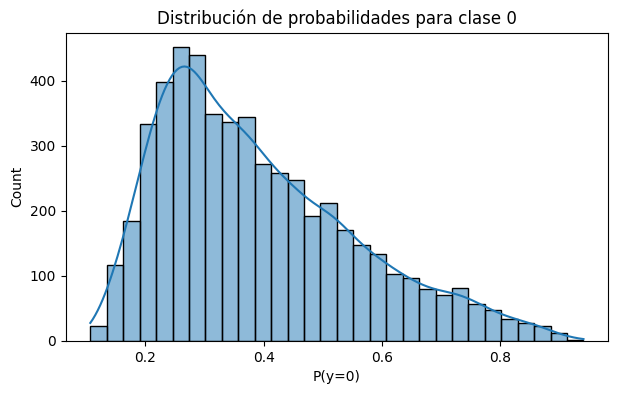

In [235]:
proba0 = best_xgb.predict_proba(X_test)[:, 0]

plt.figure(figsize=(7,4))
sns.histplot(proba0, bins=30, kde=True)
plt.title("Distribución de probabilidades para clase 0")
plt.xlabel("P(y=0)")
plt.show()

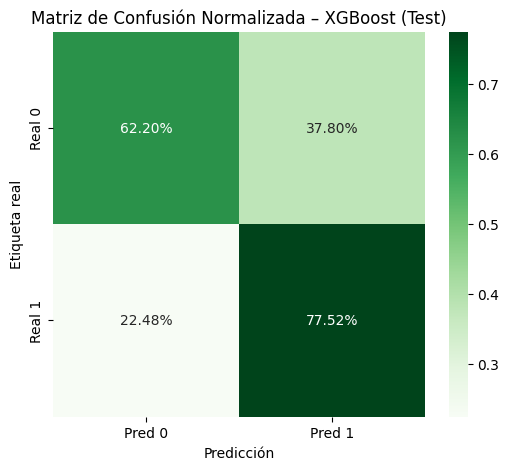

In [236]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


In [237]:
def predict_with_threshold(model, X, threshold=0.5):
    probs = model.predict_proba(X)[:, 1]
    return (probs >= threshold).astype(int)

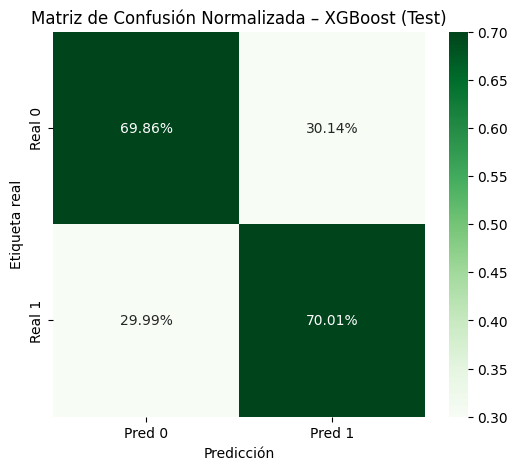

In [238]:
probs = best_xgb.predict_proba(X)[:, 1]
umbral = 0.5
preds = (probs >= umbral).astype(int)
preds = predict_with_threshold(best_xgb, X_test, threshold=0.55)

cm_norm = confusion_matrix(y_test, preds, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocessor', 'model']
Features esperados: 363
Importances entregados: 363

Top 30 Features más importantes:


UCI_0.0                        0.056890
V246_2                         0.033355
ERN_Peso                       0.032046
Indexnutricion40sem_0          0.030995
AnioParto                      0.029152
ERN_PC                         0.025735
NEURO40_0                      0.024819
V246_4                         0.024300
educmadresimplificada_1        0.022636
CONSULT08                      0.022437
tuvotransfusiones_0.0          0.018949
V219                           0.018225
V204_1                         0.017717
oftalmopato_2                  0.017110
V220                           0.016997
ERN_Talla                      0.016142
INFECCIONOSOCOMIAL_0.0         0.014637
V235                           0.014323
ali40_1                        0.014075
anoxia5mn_0.0                  0.013487
V236F_2                        0.013340
V236G_9                        0.012793
ANOCAT                         0.012728
DIASTOT08                      0.012704
ERN_Sexo_2                     0.012199


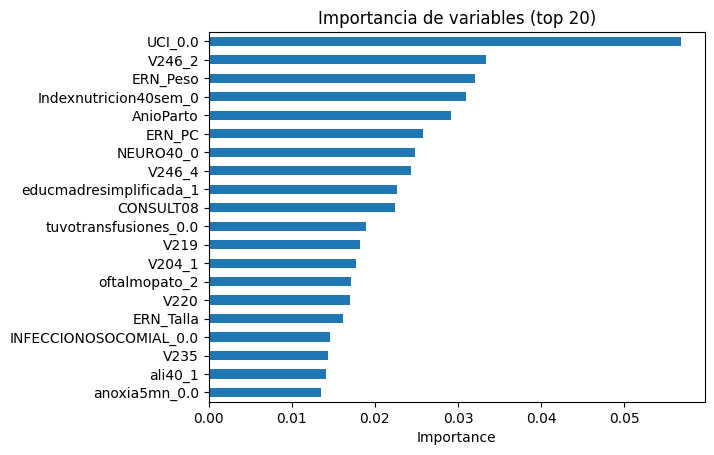

In [239]:
# Tomar los nombres de los pasos
step_names = list(best_xgb.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_xgb.named_steps[preproc_name]
xgb_best = best_xgb.named_steps[clf_name]

# 1.1 Nombres de columnas numéricas (sin transformar)
num_cols = preproc.transformers_[0][2]

# 1.2 Nombres de columnas categóricas transformadas
ohe = preproc.transformers_[1][1]       # OneHotEncoder
cat_cols = preproc.transformers_[1][2]  # columnas originales categóricas
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# 1.3 Unimos todas las columnas transformadas
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

# 1.4 Importance del modelo
importances = xgb_best.feature_importances_

# Validación por si hay mismatch
print("Features esperados:", len(all_feature_names))
print("Importances entregados:", len(importances))

# Crear tabla ordenada
feat_imp = pd.Series(importances, index=all_feature_names)\
                .sort_values(ascending=False)

print("\nTop 30 Features más importantes:")
display(feat_imp.head(30))


# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()


##### Guardar modelo

In [240]:
best_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V220', 'V218', 'V219',
                                                   'DIASTOT09', 'V237', 'V238',
                                                   'V216', 'V235A', 'V235',
                                                   'CONSULT09', 'REHOSP09',
                                                   'ERN_PC', 'ERN_Peso',
                                                   'ERN_Talla', 'ERN_Ballard',
                                                   'HD_DiasAlojamiento',
                                                   'DIASTOT08', 'ANOCAT',
                                                   'PA_NumDosisCorticoides',
                                                   'CONSULT08', 'REHOSP08',
                                                   'CP_...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=800, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [242]:
joblib.dump (best_xgb, "modeloxgb_fase4_infanib.pkl")
print("Modelo guardado como modeloxgb_fase4_infanib.pkl")

Modelo guardado como modeloxgb_fase4_infanib.pkl


In [243]:
#Cargar modelo
#modelo = joblib.load("modelos_fase1/modeloxgb_fase1_infanib.pkl")

### Modelo hasta fase 4 con variables episodios neonatos (infanib12m)

In [244]:
df_fase4_modelo

,Idenfinal,IQ12cat,infanib12m_bin,V220,V218,V219,V246,DIASTOT09,V237,V238,NEURO40,algoLM40sem,ali40,V223,V221,V222,Indexnutricion40sem,LME40,V216,V235A,V235,CONSULT09,V236G,mortalidadhasta40sem,oftalmologia,oftalmopato,V236F,REHOSP09,V249,vacunas40semBCG,vacunas40semHepB,vino40,CSP_AyudaPerm1mes,V204,V208,V209,ERN_PC,ERN_Peso,ERN_Talla,ERN_AdaptNeonatal,anoxia5mn,ERN_A_10min,ERN_A_1min,ERN_A_5min,apgarcat1,apgarcat5,BPN,ERN_Ballard,gestacat,INFECCIONOSOCOMIAL,ERN_LubchencoFenton,menosde1001,menosde31sem,Nearterm,pesocat,PESO1500G,RCIUPC,RCIUtalla,ERN_Remision,ERN_sepsis,ERN_Sexo,HD_DiasAlojamiento,DIASTOT08,ANOCAT,PA_AtendioParto,cesarea,PA_ComplicacionsPartoAbrupcio,PA_ComplicacionsPartoAmnionitis,PA_ComplicacionsPartoEclampsia,PA_ComplicacionsPartoMultiples,PA_ComplicacionsPartoPatologIaCordOn,PA_ComplicacionsPartoPlacentaPrevia,PA_ComplicacionsPartoPreeclampsia,PA_ComplicacionsPartoSindromedehellp,PA_EstActualMadre,tuvotransfusiones,UCI,PA_LiqAmnioticoMeconiado,PA_LugarNacimiento,PA_Monitoreo,PA_NumDosisCorticoides,primipara,PA_RitmoCardiaco,PA_SufrimientoFetalAgudo,PA_TipoParto,CONSULT08,ecocerebral,REHOSP08,rehosp40,CP_ARO,AROCAT02,controlcat,corticodosis,corticoprenatalsimple,ecocat,CP_edadmaterna,embarazoplanifDIU,embarazoplanifhormonal,CP_HospitalizacionesPreParto,CP_MadreAlcohol,CP_MadreFumo,CP_MesInicCP,CP_NumEcografias,pdpcat,CP_MedGeneral,RELACIONAROSOBRETOTALCONSULTAS,CP_SA_Anemia,CP_SA_APP,CP_SA_EnfRespiratoria,CP_SA_InfGineco,CP_SA_InfUrinaria,CP_SA_Preclampsia,CP_SA_RPM,CP_SA_Sangrado,Sufrimientofetalcronico,CP_TotalCPN,toxemia,CP_TP_HepatitisB,CP_TP_HIV,CP_TP_Orina,CP_TP_Rubeola,CP_TP_Sifilis,CP_TP_Toxoplasmosis,trimestre,CSP_EmbarazoDeseado,Iden_embarazoMultiple,Iden_Sede,Iden_FechaParto,edadmatcat,educmadresimplificada,educpadresimplificada,CP_TallaMadre,CSP_DistanciaVivienda,CSP_EscolaridadMadre,CSP_EscolaridadPadre,CSP_IngresoMensual,CSP_Menores5vivenMadre,ninosmenosde5anos,CSP_numPersVivenIngMen,CSP_NutricionFam,CSP_SituacionLaboralMadre,CSP_SituacionLaboralPadre,CSP_SituaPareja
0,1005052,True,1,37.0,3810.0,47.0,3,3.0,2,3,3,True,2,2,2,1,1,False,85.0,0,10,26.0,1,0,2,2,1,2.0,2,1,1,1,True,1,1,9,27.0,1111.0,38.0,1,False,10,8,10,4,4,False,28.0,1,False,1,False,True,False,2,True,False,False,False,2,1,0,3.0,6,1,True,False,False,False,False,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,10.0,True,2.0,True,4,1,1,1,0,1.0,38.0,False,False,0,False,False,1,3,2,2,59.06184,False,True,False,True,False,False,False,False,False,4,False,4,1,4,3,1,4,1,True,False,1,2008-03-11,3,2,2,159.130753,1,3,3,900000.0,1,True,5,1,1,1,3
1,1005053,True,1,36.0,3170.0,46.0,4,0.0,0,0,0,True,1,2,1,2,0,True,40.0,0,8,18.0,9,0,2,2,2,0.0,2,1,1,1,True,2,1,2,31.343039,1980.0,43.0,1,True,10,7,9,3,4,False,34.0,3,False,1,False,False,True,5,False,False,False,False,0,1,0,0.0,6,1,True,False,False,False,False,False,False,True,False,1,False,False,0,1,False,1,False,0,0,2,8.0,True,0.0,False,5,1,2,0,0,2.0,29.0,False,False,0,False,False,1,4,1,2,64.417168,False,True,False,True,True,True,False,True,False,7,True,4,1,3,3,1,1,1,True,False,1,2008-04-18,2,3,3,155.947418,1,7,7,1000000.0,1,True,3,1,1,1,3
2,1005054,True,1,34.0,2790.0,46.5,4,0.0,0,0,0,True,1,2,1,2,1,True,44.0,0,9,20.0,9,0,2,2,2,0.0,2,1,1,1,True,2,1,9,31.0,2100.0,43.0,1,True,9,7,8,3,4,False,33.0,3,False,1,False,False,False,6,False,False,False,False,2,1,0,0.0,6,1,True,False,False,False,True,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,9.0,True,0.0,False,6,1,3,1,0,2.0,21.0,False,True,0,False,False,1,4,1,1,70.13781,False,True,False,False,True,False,False,False,False,14,False,4,1,2,1,1,1,1,False,True,1,2008-04-16,2,3,3,157.673935,1,7,7,1974527.75,2,True,3,1,3,1,1
3,1005057,True,1,36.0,3870.0,50.5,4,1.0,1,1,0,True,2,2,2,1,1,False,94.0,0,11,30.0,1,0,2,2,1,1.0,2,1,1,1,True,1,1,9,30.805439,1743.0,42.0,1,False,10,9,10,4,4,False,30.0,1,False,1,False,True,False,4,False,False,False,False,0,1,0,1.0,6,1,True,False,False,False,False,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,

In [245]:
#Merge de los dataframes de la fase 0 y 1
df_fase4_modelob = df_neonato.merge(df_fase3_modelo, on=["Idenfinal"],how="inner")

In [246]:
#df_fase4_modelo.to_csv("modelos_fase4/df_fase4.csv", index=False, index_label=False)

##### Preparación

In [247]:
vars_ruido_original = []

In [248]:
df = df_fase4_modelob.copy()


# Target binaria
y = df["infanib12m_bin"].astype(int)

# Columnas que no son predictores
id_cols = ["Idenfinal"]
target_col = ['infanib12m_bin', "IQ12cat"]

# Solo extraemos el año del parto
if np.issubdtype(df["Iden_FechaParto"].dtype, np.datetime64):
    df["AnioParto"] = df["Iden_FechaParto"].dt.year
    df = df.drop(columns=["Iden_FechaParto"])

# Predictores
feature_cols = [c for c in df.columns if c not in id_cols + target_col+ vars_ruido_original + cols_no_imputar]
X = df[feature_cols]

# Separar numericas de categoricas
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['HD_CicloAntibio', 'HD_CiclosOtroAntibio', 'HD_CiclosUltimaLinea', 'HD_DiasAlimentacionPar', 'HD_DiasCamaraCefalica', 'HD_DiasCanulaNasa', 'HD_DiasFototerapia', 'HD_DiasIncubadora', 'HD_DiasOxigeno', 'HD_DiasUCI', 'HD_DiasURN', 'HD_DiasVenMecanica', 'HD_DiasVenNoInvasiva', 'HD_DosisAmino', 'HD_DosisSurfactante', 'HD_ExamenesEcocardiograma', 'HD_ExamenesEcografiacerebral', 'HD_ExamenesExamendeorina', 'HD_ExamenesGenetico', 'HD_ExamenesHIV', 'HD_ExamenesHepatitisB', 'HD_ExamenesRMICerebral', 'HD_ExamenesRubeola', 'HD_ExamenesSifilis', 'HD_ExamenesTSH_Tiroides', 'HD_ExamenesToxoplasmosis', 'HD_NumTrasSanguineas', 'HD_PesoSalida', 'HD_TotalDiasHospital', 'HD_UltiValorHematocrito', 'HD_UltimValorHemaglobina', 'HD_ValorMasAltoBilirubina', 'V196', 'gestasal', 'ERN_PC', 'ERN_Peso', 'ERN_Talla', 'ERN_Ballard', 'HD_DiasAlojamiento', 'DIASTOT08', 'ANOCAT', 'PA_NumDosisCorticoides', 'CONSULT08', 'REHOSP08', 'CP_ARO', 'corticodosis', 'ecocat', 'CP_edadmaterna', 'CP_HospitalizacionesPreP

In [249]:
len(categorical_cols)

104

##### Split en conjuntos de entrenamiento y prueba

In [296]:
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2,
                                                     random_state=42, stratify=y)

# En el notebook donde entrenaste Fase 3 o 4
print("--- COLUMNAS FASE 3/4 ---")
print(list(X_train.columns))

--- COLUMNAS FASE 3/4 ---
['V263', 'V261', 'V262', 'V270', 'DIASTOT10', 'V277', 'V279', 'V278', 'V276', 'V290', 'infanib3m', 'algoLM3meses', 'ali3m', 'V268', 'V266', 'V264', 'V265', 'V269', 'V267', 'LME3m', 'V274', 'V295', 'V275A', 'V286', 'audiometriapato', 'V300', 'CONSULT10', 'V275E', 'V260', 'V289', 'V298', 'V299', 'V275B', 'V287', 'V293', 'V285', 'V301C', 'V282', 'V281', 'V283', 'V301A', 'V275', 'optometriapato', 'V275D', 'V294', 'V297', 'REHOSP10', 'V301B', 'V292', 'vino3m', 'V220', 'V218', 'V219', 'V246', 'DIASTOT09', 'V237', 'V238', 'NEURO40', 'algoLM40sem', 'ali40', 'V223', 'V221', 'V222', 'Indexnutricion40sem', 'LME40', 'V216', 'V235A', 'V235', 'CONSULT09', 'V236G', 'mortalidadhasta40sem', 'oftalmologia', 'oftalmopato', 'V236F', 'REHOSP09', 'V249', 'vacunas40semBCG', 'vacunas40semHepB', 'vino40', 'CSP_AyudaPerm1mes', 'V204', 'V208', 'V209', 'ERN_PC', 'ERN_Peso', 'ERN_Talla', 'ERN_AdaptNeonatal', 'anoxia5mn', 'ERN_A_10min', 'ERN_A_1min', 'ERN_A_5min', 'apgarcat1', 'apgarcat5',

#### XGBoost

##### Pipeline con preprocesamiento y modelo

In [251]:
# Peso de clases para XGBoost
counts = y_train.value_counts()
print("Distribución en train:\n", counts)
scale_pos_weight = counts[0] / counts[1]   # mayor peso a la clase 1
print("scale_pos_weight:", scale_pos_weight)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Modelo base XGBoost
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",   # evita warnings
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",      # más rápido en CPU
    scale_pos_weight=scale_pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_clf)   #  nombre para acceder fácil después
])


Distribución en train:
 infanib12m_bin
1    20088
0      836
Name: count, dtype: int64
scale_pos_weight: 0.04161688570290721


In [252]:
X_train.shape

(20924, 166)

##### GridSearch de hiperparámetros

In [253]:
mixed_type_cols = []

for col in X_train.columns:
    tipos = {type(v) for v in X_train[col].dropna().tolist()}
    if len(tipos) > 1:
        mixed_type_cols.append((col, tipos))

mixed_type_cols

[('V204A', {int, str}),
 ('V205', {int, str}),
 ('V206', {int, str}),
 ('V207', {int, str})]

In [254]:
cols_mixtas = ["V206", "V204A", "V205", "V207"]

# Unificar tipo: todo como string (categórico)
for col in cols_mixtas:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype("string")
        X_test[col]  = X_test[col].astype("string")


In [255]:
# Búsqueda de hiperparámetros (ligera para no matar el PC)
param_grid = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.05, 0.1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score, pos_label=0)

In [256]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid, cv=cv, scoring=recall_scorer, 
                        n_jobs=-1,verbose=2)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['HD_CicloAntibio',
                                                                          'HD_CiclosOtroAntibio',
                                                                          'HD_CiclosUltimaLinea',
                                                                          'HD_DiasAlimentacionPar',
                                                                          'HD_DiasCamaraCefalica',
                                                                          'HD_DiasCanulaNasa',
                                                                          'HD_DiasFototera...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [300, 500, 800]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=0),
             verbose=2)

##### Evaluación

In [257]:
best_xgb = grid_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:,1]
y_pred = best_xgb.predict(X_test)

print("Recall TRAIN:", recall_score(y_train, y_train_pred))
print("Recall TEST:", recall_score(y_test, y_pred))

print("Precision TRAIN:", precision_score(y_train, y_train_pred))
print("Precision TEST:", precision_score(y_test, y_pred))


Recall TRAIN: 0.7516925527678215
Recall TEST: 0.7433293508562325
Precision TRAIN: 0.9832009376220862
Precision TEST: 0.9795329309892417


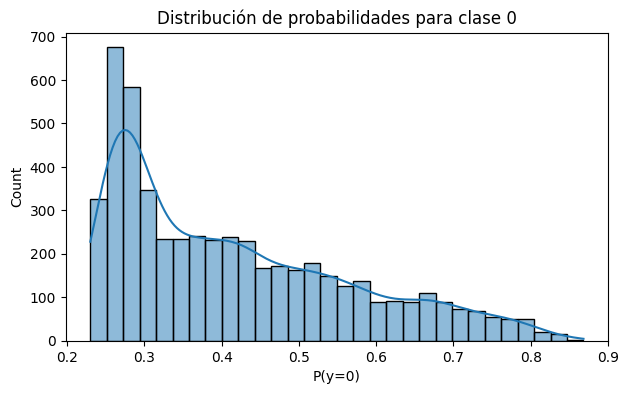

In [258]:
proba0 = best_xgb.predict_proba(X_test)[:, 0]

plt.figure(figsize=(7,4))
sns.histplot(proba0, bins=30, kde=True)
plt.title("Distribución de probabilidades para clase 0")
plt.xlabel("P(y=0)")
plt.show()

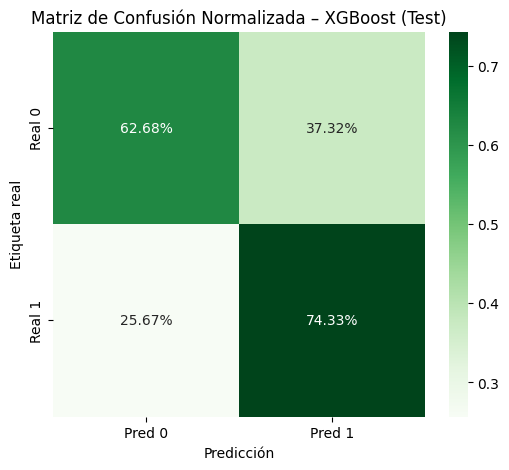

In [259]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


In [260]:
def predict_with_threshold(model, X, threshold=0.5):
    probs = model.predict_proba(X)[:, 1]
    return (probs >= threshold).astype(int)

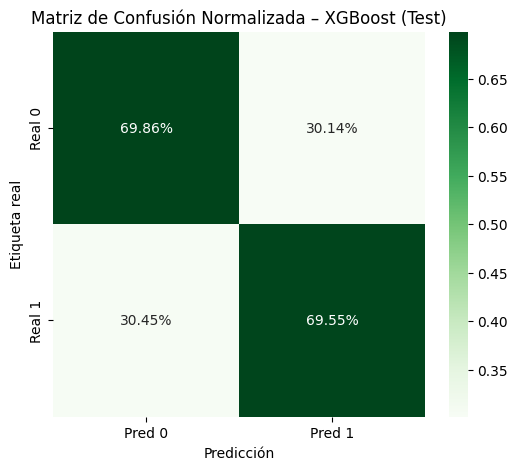

In [261]:
probs = best_xgb.predict_proba(X)[:, 1]
umbral = 0.5
preds = (probs >= umbral).astype(int)
preds = predict_with_threshold(best_xgb, X_test, threshold=0.53)

cm_norm = confusion_matrix(y_test, preds, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocessor', 'model']
Features esperados: 389
Importances entregados: 389

Top 30 Features más importantes:


HD_TotalDiasHospital         0.127965
V196                         0.065896
AnioParto                    0.038926
HD_ExamenesGenetico          0.034657
HD_C_ExamenNeurologico_0     0.027335
HD_PesoSalida                0.026523
RCIUPC_0.0                   0.026077
corticoprenatalsimple_0      0.024921
CP_edadmaterna               0.022650
DIASTOT08                    0.022078
educmadresimplificada_1      0.022074
HD_DiasURN                   0.021411
HD_C_ExamenNeurologico_3     0.020544
HD_C_ExamenNeurologico_4     0.020182
gestasal                     0.020101
HD_ExamenesEcocardiograma    0.018962
CSP_EscolaridadMadre_2       0.017510
ANOCAT                       0.017062
ERN_Sexo_2                   0.015523
V204_1                       0.015437
Iden_Sede                    0.014769
HD_DiasVenMecanica           0.014757
HD_UltimValorHemaglobina     0.014489
CSP_IngresoMensual           0.014143
CP_SA_InfGineco_0.0          0.014126
CONSULT08                    0.013455
pesocat_3   

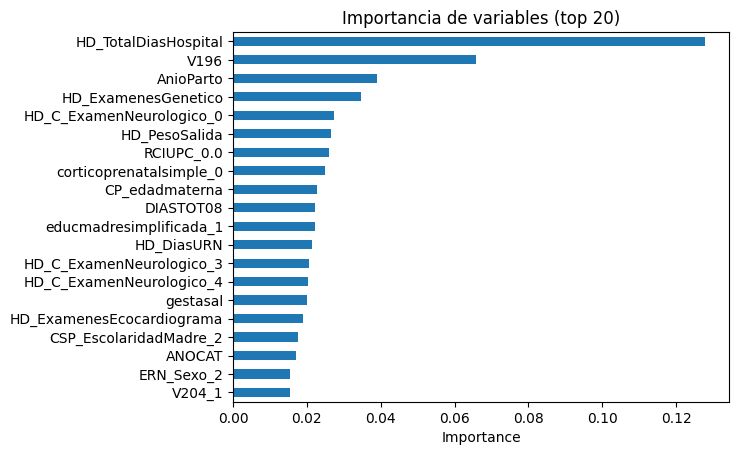

In [262]:
# Tomar los nombres de los pasos
step_names = list(best_xgb.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_xgb.named_steps[preproc_name]
xgb_best = best_xgb.named_steps[clf_name]

# 1.1 Nombres de columnas numéricas (sin transformar)
num_cols = preproc.transformers_[0][2]

# 1.2 Nombres de columnas categóricas transformadas
ohe = preproc.transformers_[1][1]       # OneHotEncoder
cat_cols = preproc.transformers_[1][2]  # columnas originales categóricas
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# 1.3 Unimos todas las columnas transformadas
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

# 1.4 Importance del modelo
importances = xgb_best.feature_importances_

# Validación por si hay mismatch
print("Features esperados:", len(all_feature_names))
print("Importances entregados:", len(importances))

# Crear tabla ordenada
feat_imp = pd.Series(importances, index=all_feature_names)\
                .sort_values(ascending=False)

print("\nTop 30 Features más importantes:")
display(feat_imp.head(30))


# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()


##### Guardar modelo

In [263]:
best_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['HD_CicloAntibio',
                                                   'HD_CiclosOtroAntibio',
                                                   'HD_CiclosUltimaLinea',
                                                   'HD_DiasAlimentacionPar',
                                                   'HD_DiasCamaraCefalica',
                                                   'HD_DiasCanulaNasa',
                                                   'HD_DiasFototerapia',
                                                   'HD_DiasIncubadora',
                                                   'HD_DiasOxigeno',
                                                   'HD_DiasUCI', 'HD_DiasURN',
                                                   'HD_DiasVenMeca...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [265]:
joblib.dump (best_xgb, "modeloxgb_fase4b_infanib.pkl")
print("Modelo guardado como modeloxgb_fase4b_infanib.pkl")

Modelo guardado como modeloxgb_fase4b_infanib.pkl


In [ ]:
#Cargar modelo
modelo = joblib.load("modelos_fase1/modeloxgb_fase1_infanib.pkl")

### Modelo hasta fase 4 con variables posicion canguro (IQ12cat)

##### Preparación

In [266]:
df = df_fase4_modelo.copy()

# Target binaria
y = df["IQ12cat"].astype(int)

# Columnas que no son predictores
id_cols = ["Idenfinal"]
target_col = ['infanib12m_bin', "IQ12cat"]

# Solo extraemos el año del parto
if np.issubdtype(df["Iden_FechaParto"].dtype, np.datetime64):
    df["AnioParto"] = df["Iden_FechaParto"].dt.year
    df = df.drop(columns=["Iden_FechaParto"])

# Predictores
feature_cols = [c for c in df.columns if c not in id_cols + target_col]
X = df[feature_cols]

# Separar numericas de categoricas
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['V220', 'V218', 'V219', 'DIASTOT09', 'V237', 'V238', 'V216', 'V235A', 'V235', 'CONSULT09', 'REHOSP09', 'ERN_PC', 'ERN_Peso', 'ERN_Talla', 'ERN_Ballard', 'HD_DiasAlojamiento', 'DIASTOT08', 'ANOCAT', 'PA_NumDosisCorticoides', 'CONSULT08', 'REHOSP08', 'CP_ARO', 'corticodosis', 'ecocat', 'CP_edadmaterna', 'CP_HospitalizacionesPreParto', 'CP_MesInicCP', 'CP_NumEcografias', 'CP_MedGeneral', 'RELACIONAROSOBRETOTALCONSULTAS', 'CP_TotalCPN', 'CP_TP_Orina', 'trimestre', 'Iden_Sede', 'CP_TallaMadre', 'CSP_IngresoMensual', 'CSP_Menores5vivenMadre', 'CSP_numPersVivenIngMen', 'AnioParto']
Categóricas: ['V246', 'NEURO40', 'algoLM40sem', 'ali40', 'V223', 'V221', 'V222', 'Indexnutricion40sem', 'LME40', 'V236G', 'mortalidadhasta40sem', 'oftalmologia', 'oftalmopato', 'V236F', 'V249', 'vacunas40semBCG', 'vacunas40semHepB', 'vino40', 'CSP_AyudaPerm1mes', 'V204', 'V208', 'V209', 'ERN_AdaptNeonatal', 'anoxia5mn', 'ERN_A_10min', 'ERN_A_1min', 'ERN_A_5min', 'apgarcat1', 'apgarcat5', 'BPN', 'gestaca

##### Split en conjuntos de entrenamiento y prueba

In [267]:
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2,
                                                     random_state=42, stratify=y)

#### XGBoost

##### Pipeline con preprocesamiento y modelo

In [268]:
# Peso de clases para XGBoost
counts = y_train.value_counts()
print("Distribución en train:\n", counts)
scale_pos_weight = counts[0] / counts[1]   # mayor peso a la clase 1
print("scale_pos_weight:", scale_pos_weight)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Modelo base XGBoost
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",   # evita warnings
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",      # más rápido en CPU
    scale_pos_weight=scale_pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_clf)   #  nombre para acceder fácil después
])


Distribución en train:
 IQ12cat
1    16955
0     3969
Name: count, dtype: int64
scale_pos_weight: 0.23409023886759067


In [269]:
X_train.shape

(20924, 140)

##### GridSearch de hiperparámetros

In [270]:
# Búsqueda de hiperparámetros (ligera para no matar el PC)
param_grid = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.05, 0.1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score, pos_label=0)

In [271]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid, cv=cv, scoring=recall_scorer, 
                        n_jobs=-1,verbose=2)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['V220',
                                                                          'V218',
                                                                          'V219',
                                                                          'DIASTOT09',
                                                                          'V237',
                                                                          'V238',
                                                                          'V216',
                                                                          'V235A',
                                                                          'V235',
                                                                          'CONSULT09',
                                                                          'REHOSP09',
                                                                          'ERN_PC',
                                                                          'ERN_Peso',
                                                                          'ERN_Talla',
                                                                          'ERN_Ballard',
                                                                          'HD_DiasAlo...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [300, 500, 800]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=0),
             verbose=2)

##### Evaluación

In [272]:
best_xgb = grid_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:,1]
y_pred = best_xgb.predict(X_test)

print("Recall TRAIN:", recall_score(y_train, y_train_pred))
print("Recall TEST:", recall_score(y_test, y_pred))

print("Precision TRAIN:", precision_score(y_train, y_train_pred))
print("Precision TEST:", precision_score(y_test, y_pred))


Recall TRAIN: 0.7757593630197582
Recall TEST: 0.7607926397735315
Precision TRAIN: 0.9025595278940507
Precision TEST: 0.8968298109010011


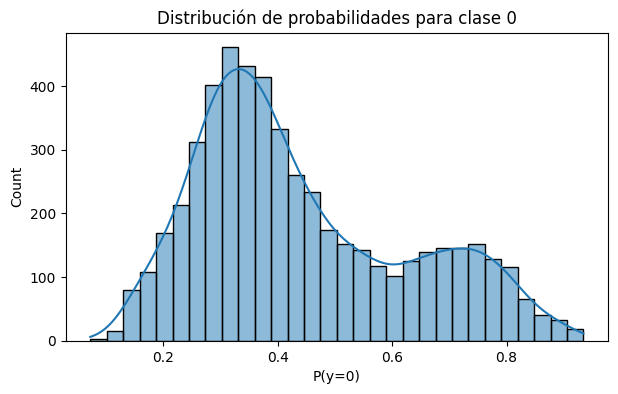

In [273]:
proba0 = best_xgb.predict_proba(X_test)[:, 0]

plt.figure(figsize=(7,4))
sns.histplot(proba0, bins=30, kde=True)
plt.title("Distribución de probabilidades para clase 0")
plt.xlabel("P(y=0)")
plt.show()

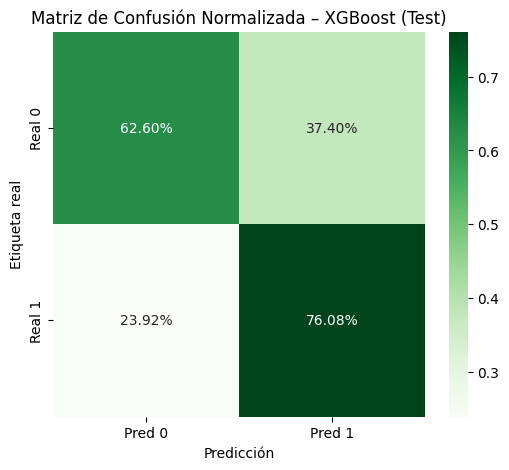

In [274]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocessor', 'model']
Features esperados: 363
Importances entregados: 363

Top 30 Features más importantes:


CSP_NutricionFam_1            0.177003
educmadresimplificada_1       0.021902
ANOCAT                        0.019312
tuvotransfusiones_0.0         0.018208
UCI_0.0                       0.018189
anoxia5mn_0.0                 0.016731
PA_Monitoreo_0.0              0.016402
V208_1                        0.015672
CP_TP_Toxoplasmosis_4         0.014378
Iden_Sede                     0.014373
ERN_Ballard                   0.014341
CSP_EscolaridadMadre_2        0.013088
V209_1                        0.012541
AnioParto                     0.011807
ERN_Peso                      0.011792
NEURO40_0                     0.011192
ERN_Talla                     0.010495
PA_SufrimientoFetalAgudo_0    0.010408
INFECCIONOSOCOMIAL_0.0        0.009635
V204_1                        0.009352
apgarcat1_4                   0.008681
PA_TipoParto_2                0.008252
CP_TP_HepatitisB_1            0.007875
CP_TP_Toxoplasmosis_1         0.007583
DIASTOT08                     0.007371
V204_2                   

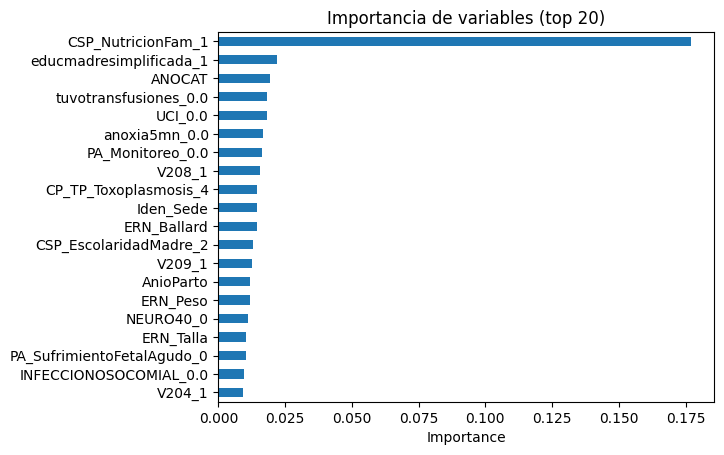

In [275]:
# Tomar los nombres de los pasos
step_names = list(best_xgb.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_xgb.named_steps[preproc_name]
xgb_best = best_xgb.named_steps[clf_name]

# 1.1 Nombres de columnas numéricas (sin transformar)
num_cols = preproc.transformers_[0][2]

# 1.2 Nombres de columnas categóricas transformadas
ohe = preproc.transformers_[1][1]       # OneHotEncoder
cat_cols = preproc.transformers_[1][2]  # columnas originales categóricas
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# 1.3 Unimos todas las columnas transformadas
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

# 1.4 Importance del modelo
importances = xgb_best.feature_importances_

# Validación por si hay mismatch
print("Features esperados:", len(all_feature_names))
print("Importances entregados:", len(importances))

# Crear tabla ordenada
feat_imp = pd.Series(importances, index=all_feature_names)\
                .sort_values(ascending=False)

print("\nTop 30 Features más importantes:")
display(feat_imp.head(30))


# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()


##### Guardar modelo

In [276]:
best_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V220', 'V218', 'V219',
                                                   'DIASTOT09', 'V237', 'V238',
                                                   'V216', 'V235A', 'V235',
                                                   'CONSULT09', 'REHOSP09',
                                                   'ERN_PC', 'ERN_Peso',
                                                   'ERN_Talla', 'ERN_Ballard',
                                                   'HD_DiasAlojamiento',
                                                   'DIASTOT08', 'ANOCAT',
                                                   'PA_NumDosisCorticoides',
                                                   'CONSULT08', 'REHOSP08',
                                                   'CP_...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [278]:
joblib.dump (best_xgb, "modeloxgb_fase4_iq12cat.pkl")
print("Modelo guardado como modeloxgb_fase4_iq12cat.pkl")

Modelo guardado como modeloxgb_fase4_iq12cat.pkl


In [279]:
print(X_train)

            V220         V218       V219 V246  DIASTOT09  V237  V238 NEURO40  \
5785        37.0       3790.0       50.0    2   1.835039     0     0       1   
794    34.099998       2410.0       45.5    4        0.0     0     0       0   
13525  34.599998       3200.0  48.799999    4        0.0     0     0       0   
16385  37.799999       3390.0  49.799999    9        0.0     0     0       0   
16968  33.969219  2955.225586  47.467606    9        0.0     0     0       0   
...          ...          ...        ...  ...        ...   ...   ...     ...   
22849       35.0       2590.0       47.0    4        0.0     0     0       0   
11207       32.0       2370.0  45.200001    4        0.0     0     0       0   
18604       35.5       3330.0       49.5    4        0.0     0     0       0   
21219       34.0       2765.0       47.0    4        0.0     0     0       0   
6396   33.200001       2240.0       46.5    4        3.0     1     3       0   

       algoLM40sem ali40 V223 V221 V222

In [281]:
#Cargar modelo
#modelo = joblib.load("modelos_fase1/modeloxgb_fase1_infanib.pkl")

### Modelo hasta fase 5 con variables posición canguro (infanib12m)

In [282]:
df_fase4_modelo

,Idenfinal,IQ12cat,infanib12m_bin,V220,V218,V219,V246,DIASTOT09,V237,V238,NEURO40,algoLM40sem,ali40,V223,V221,V222,Indexnutricion40sem,LME40,V216,V235A,V235,CONSULT09,V236G,mortalidadhasta40sem,oftalmologia,oftalmopato,V236F,REHOSP09,V249,vacunas40semBCG,vacunas40semHepB,vino40,CSP_AyudaPerm1mes,V204,V208,V209,ERN_PC,ERN_Peso,ERN_Talla,ERN_AdaptNeonatal,anoxia5mn,ERN_A_10min,ERN_A_1min,ERN_A_5min,apgarcat1,apgarcat5,BPN,ERN_Ballard,gestacat,INFECCIONOSOCOMIAL,ERN_LubchencoFenton,menosde1001,menosde31sem,Nearterm,pesocat,PESO1500G,RCIUPC,RCIUtalla,ERN_Remision,ERN_sepsis,ERN_Sexo,HD_DiasAlojamiento,DIASTOT08,ANOCAT,PA_AtendioParto,cesarea,PA_ComplicacionsPartoAbrupcio,PA_ComplicacionsPartoAmnionitis,PA_ComplicacionsPartoEclampsia,PA_ComplicacionsPartoMultiples,PA_ComplicacionsPartoPatologIaCordOn,PA_ComplicacionsPartoPlacentaPrevia,PA_ComplicacionsPartoPreeclampsia,PA_ComplicacionsPartoSindromedehellp,PA_EstActualMadre,tuvotransfusiones,UCI,PA_LiqAmnioticoMeconiado,PA_LugarNacimiento,PA_Monitoreo,PA_NumDosisCorticoides,primipara,PA_RitmoCardiaco,PA_SufrimientoFetalAgudo,PA_TipoParto,CONSULT08,ecocerebral,REHOSP08,rehosp40,CP_ARO,AROCAT02,controlcat,corticodosis,corticoprenatalsimple,ecocat,CP_edadmaterna,embarazoplanifDIU,embarazoplanifhormonal,CP_HospitalizacionesPreParto,CP_MadreAlcohol,CP_MadreFumo,CP_MesInicCP,CP_NumEcografias,pdpcat,CP_MedGeneral,RELACIONAROSOBRETOTALCONSULTAS,CP_SA_Anemia,CP_SA_APP,CP_SA_EnfRespiratoria,CP_SA_InfGineco,CP_SA_InfUrinaria,CP_SA_Preclampsia,CP_SA_RPM,CP_SA_Sangrado,Sufrimientofetalcronico,CP_TotalCPN,toxemia,CP_TP_HepatitisB,CP_TP_HIV,CP_TP_Orina,CP_TP_Rubeola,CP_TP_Sifilis,CP_TP_Toxoplasmosis,trimestre,CSP_EmbarazoDeseado,Iden_embarazoMultiple,Iden_Sede,Iden_FechaParto,edadmatcat,educmadresimplificada,educpadresimplificada,CP_TallaMadre,CSP_DistanciaVivienda,CSP_EscolaridadMadre,CSP_EscolaridadPadre,CSP_IngresoMensual,CSP_Menores5vivenMadre,ninosmenosde5anos,CSP_numPersVivenIngMen,CSP_NutricionFam,CSP_SituacionLaboralMadre,CSP_SituacionLaboralPadre,CSP_SituaPareja
0,1005052,True,1,37.0,3810.0,47.0,3,3.0,2,3,3,True,2,2,2,1,1,False,85.0,0,10,26.0,1,0,2,2,1,2.0,2,1,1,1,True,1,1,9,27.0,1111.0,38.0,1,False,10,8,10,4,4,False,28.0,1,False,1,False,True,False,2,True,False,False,False,2,1,0,3.0,6,1,True,False,False,False,False,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,10.0,True,2.0,True,4,1,1,1,0,1.0,38.0,False,False,0,False,False,1,3,2,2,59.06184,False,True,False,True,False,False,False,False,False,4,False,4,1,4,3,1,4,1,True,False,1,2008-03-11,3,2,2,159.130753,1,3,3,900000.0,1,True,5,1,1,1,3
1,1005053,True,1,36.0,3170.0,46.0,4,0.0,0,0,0,True,1,2,1,2,0,True,40.0,0,8,18.0,9,0,2,2,2,0.0,2,1,1,1,True,2,1,2,31.343039,1980.0,43.0,1,True,10,7,9,3,4,False,34.0,3,False,1,False,False,True,5,False,False,False,False,0,1,0,0.0,6,1,True,False,False,False,False,False,False,True,False,1,False,False,0,1,False,1,False,0,0,2,8.0,True,0.0,False,5,1,2,0,0,2.0,29.0,False,False,0,False,False,1,4,1,2,64.417168,False,True,False,True,True,True,False,True,False,7,True,4,1,3,3,1,1,1,True,False,1,2008-04-18,2,3,3,155.947418,1,7,7,1000000.0,1,True,3,1,1,1,3
2,1005054,True,1,34.0,2790.0,46.5,4,0.0,0,0,0,True,1,2,1,2,1,True,44.0,0,9,20.0,9,0,2,2,2,0.0,2,1,1,1,True,2,1,9,31.0,2100.0,43.0,1,True,9,7,8,3,4,False,33.0,3,False,1,False,False,False,6,False,False,False,False,2,1,0,0.0,6,1,True,False,False,False,True,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,9.0,True,0.0,False,6,1,3,1,0,2.0,21.0,False,True,0,False,False,1,4,1,1,70.13781,False,True,False,False,True,False,False,False,False,14,False,4,1,2,1,1,1,1,False,True,1,2008-04-16,2,3,3,157.673935,1,7,7,1974527.75,2,True,3,1,3,1,1
3,1005057,True,1,36.0,3870.0,50.5,4,1.0,1,1,0,True,2,2,2,1,1,False,94.0,0,11,30.0,1,0,2,2,1,1.0,2,1,1,1,True,1,1,9,30.805439,1743.0,42.0,1,False,10,9,10,4,4,False,30.0,1,False,1,False,True,False,4,False,False,False,False,0,1,0,1.0,6,1,True,False,False,False,False,False,False,False,False,1,False,True,0,1,False,1,False,0,0,2,

In [283]:
dfs_por_fase[5]

,Idenfinal,IQ12cat,infanib12m_bin,V263,V261,V262,V270,DIASTOT10,V277,V279,V278,V276,V290,infanib3m,algoLM3meses,ali3m,V268,V266,V264,V265,V269,V267,LME3m,V274,V295,V275A,V286,audiometriapato,V300,CONSULT10,V275E,V260,V289,V298,V299,V275B,V287,V293,V285,V301C,V282,V281,V283,V301A,V275,optometriapato,V275D,V294,V297,REHOSP10,V301B,V292,vino3m
5049,1005052,True,1,43.0,7490.0,58.0,9,3.0,0.0,2,2,0.0,2,1,0,3,1,1,2,2,2,2,False,6.0,9,2,4,0,1,44.0,9,177.0,2,2,2,1,4,9,0,1,2,1,2,SANO,0.0,14,2,9,2,2.0,1,0,True
5050,1005053,True,1,41.0,5110.0,54.0,9,0.0,0.0,2,2,0.0,1,2,1,1,2,2,1,2,2,1,True,2.0,9,1,2,0,1,30.0,9,125.0,2,2,2,1,1,1,2,1,2,2,1,REFLUJO GASTROESOFAGICO- RETRASO PSICOMOTOR,0.0,4,2,9,2,0.0,1,0,True
5051,1005054,True,1,40.5,5680.0,56.0,9,0.0,0.0,2,2,0.0,2,1,1,1,2,2,1,2,2,1,True,2.0,9,1,4,0,1,33.0,9,138.0,2,1,1,1,4,9,0,1,2,1,2,SANO,0.0,14,2,9,1,0.0,1,0,True
5054,1005057,True,1,40.700001,7280.0,62.0,9,1.0,0.0,2,2,0.0,2,1,0,3,1,1,2,2,1,2,False,8.0,9,2,0,0,1,51.0,9,156.0,2,2,2,1,0,9,0,1,2,1,2,SANO,0.0,1,2,9,2,1.0,1,0,True
5055,1005058,True,1,39.521233,4838.359375,57.661942,9,0.0,0.0,2,2,0.0,2,1,1,2,1,2,2,1,2,1,False,0.0,9,2,0,0,1,7.0,9,117.856415,2,1,2,1,0,1,0,1,2,1,2,SANA,3.38744,14,2,9,1,0.0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64634,4012747,True,1,39.5,5270.0,57.0,9,0.0,-3.637257,2,2,-0.012866,2,1,1,2,1,2,2,1,2,1,False,2.560778,9,2,0,0,1,10.0,9,122.099213,2,1,2,1,0,1,0,1,2,1,2,SANA,40.400974,3,2,9,1,0.0,1,1,True
64635,4012807,True,1,41.5,5880.0,60.0,9,0.0,-4.023344,2,2,-0.021741,2,2,0,3,1,2,2,1,2,1,False,2.510519,9,2,0,0,1,23.0,9,130.191437,2,1,2,1,0,1,0,1,2,1,2,SANA,32.844612,3,2,9,1,0.0,1,1,True
64637,4012819,True,1,41.0,5990.0,60.5,9,0.0,-20.71575,2,2,-0.11659,2,1,1,2,1,2,2,1,2,1,False,2.347512,9,2,0,0,1,52.0,9,131.768967,2,1,2,1,0,1,0,1,2,1,2,SANA,33.085571,1,2,9,1,0.0,1,1,True
64639,4012897,True,1,42.0,5780.0,60.0,9,1.086066,-17.688129,2,2,-0.08862,2,1,1,2,1,2,2,1,2,1,False,2.359595,9,2,0,0,1,14.0,9,126.520279,2,1,2,1,0,1,0,1,2,1,2,SANA,35.230568,1,2,9,1,0.0916,1,1,True


In [284]:
#Merge de los dataframes de la fase 0 y 1
df_fase5_modelo = dfs_por_fase[5].merge(df_fase4_modelo, on=["Idenfinal", "IQ12cat", "infanib12m_bin"],how="inner")

In [285]:
#df_fase4_modelo.to_csv("modelos_fase4/df_fase4.csv", index=False, index_label=False)

In [286]:
df_fase5_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26155 entries, 0 to 26154
Columns: 193 entries, Idenfinal to CSP_SituaPareja
dtypes: Float32(30), Int64(19), boolean(48), category(92), datetime64[ns](1), int64(2), string(1)
memory usage: 13.5 MB


##### Preparación

In [287]:
vars_ruido_original = []

In [288]:
df = df_fase5_modelo.copy()


# Target binaria
y = df["infanib12m_bin"].astype(int)

# Columnas que no son predictores
id_cols = ["Idenfinal"]
target_col = ['infanib12m_bin', "IQ12cat"]

# Solo extraemos el año del parto
if np.issubdtype(df["Iden_FechaParto"].dtype, np.datetime64):
    df["AnioParto"] = df["Iden_FechaParto"].dt.year
    df = df.drop(columns=["Iden_FechaParto"])

# Predictores
feature_cols = [c for c in df.columns if c not in id_cols + target_col+ vars_ruido_original]
X = df[feature_cols]

# Separar numericas de categoricas
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['V263', 'V261', 'V262', 'DIASTOT10', 'V277', 'V276', 'V274', 'CONSULT10', 'V260', 'V275', 'REHOSP10', 'V220', 'V218', 'V219', 'DIASTOT09', 'V237', 'V238', 'V216', 'V235A', 'V235', 'CONSULT09', 'REHOSP09', 'ERN_PC', 'ERN_Peso', 'ERN_Talla', 'ERN_Ballard', 'HD_DiasAlojamiento', 'DIASTOT08', 'ANOCAT', 'PA_NumDosisCorticoides', 'CONSULT08', 'REHOSP08', 'CP_ARO', 'corticodosis', 'ecocat', 'CP_edadmaterna', 'CP_HospitalizacionesPreParto', 'CP_MesInicCP', 'CP_NumEcografias', 'CP_MedGeneral', 'RELACIONAROSOBRETOTALCONSULTAS', 'CP_TotalCPN', 'CP_TP_Orina', 'trimestre', 'Iden_Sede', 'CP_TallaMadre', 'CSP_IngresoMensual', 'CSP_Menores5vivenMadre', 'CSP_numPersVivenIngMen', 'AnioParto']
Categóricas: ['V270', 'V279', 'V278', 'V290', 'infanib3m', 'algoLM3meses', 'ali3m', 'V268', 'V266', 'V264', 'V265', 'V269', 'V267', 'LME3m', 'V295', 'V275A', 'V286', 'audiometriapato', 'V300', 'V275E', 'V289', 'V298', 'V299', 'V275B', 'V287', 'V293', 'V285', 'V301C', 'V282', 'V281', 'V283', 'V301A', 'op

In [289]:
len(categorical_cols)

140

##### Split en conjuntos de entrenamiento y prueba

In [290]:
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2,
                                                     random_state=42, stratify=y)

#### XGBoost

##### Pipeline con preprocesamiento y modelo

In [291]:
# Peso de clases para XGBoost
counts = y_train.value_counts()
print("Distribución en train:\n", counts)
scale_pos_weight = counts[0] / counts[1]   # mayor peso a la clase 1
print("scale_pos_weight:", scale_pos_weight)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Modelo base XGBoost
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",   # evita warnings
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",      # más rápido en CPU
    scale_pos_weight=scale_pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_clf)   #  nombre para acceder fácil después
])


Distribución en train:
 infanib12m_bin
1    20088
0      836
Name: count, dtype: int64
scale_pos_weight: 0.04161688570290721


In [292]:
X_train.shape

(20924, 190)

##### GridSearch de hiperparámetros

In [293]:
# Búsqueda de hiperparámetros (ligera para no matar el PC)
param_grid = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.05, 0.1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score, pos_label=0)

In [294]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid, cv=cv, scoring=recall_scorer, 
                        n_jobs=-1,verbose=2)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['V263',
                                                                          'V261',
                                                                          'V262',
                                                                          'DIASTOT10',
                                                                          'V277',
                                                                          'V276',
                                                                          'V274',
                                                                          'CONSULT10',
                                                                          'V260',
                                                                          'V275',
                                                                          'REHOSP10',
                                                                          'V220',
                                                                          'V218',
                                                                          'V219',
                                                                          'DIASTOT09',
                                                                          'V237',
                                                                          'V238',
                                                                          'V216',
                                                                          'V23...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [300, 500, 800]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=0),
             verbose=2)

##### Evaluación

In [295]:
best_xgb = grid_xgb.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_train_proba = best_xgb.predict_proba(X_train)[:,1]
y_pred = best_xgb.predict(X_test)

print("Recall TRAIN:", recall_score(y_train, y_train_pred))
print("Recall TEST:", recall_score(y_test, y_pred))

print("Precision TRAIN:", precision_score(y_train, y_train_pred))
print("Precision TEST:", precision_score(y_test, y_pred))
print("--- COLUMNAS FASE 3/4 ---")
print(list(X_train.columns))

Recall TRAIN: 0.804410593389088
Recall TEST: 0.7913181999203505
Precision TRAIN: 0.9847044485070079
Precision TEST: 0.9822046465645081
--- COLUMNAS FASE 3/4 ---
['V263', 'V261', 'V262', 'V270', 'DIASTOT10', 'V277', 'V279', 'V278', 'V276', 'V290', 'infanib3m', 'algoLM3meses', 'ali3m', 'V268', 'V266', 'V264', 'V265', 'V269', 'V267', 'LME3m', 'V274', 'V295', 'V275A', 'V286', 'audiometriapato', 'V300', 'CONSULT10', 'V275E', 'V260', 'V289', 'V298', 'V299', 'V275B', 'V287', 'V293', 'V285', 'V301C', 'V282', 'V281', 'V283', 'V301A', 'V275', 'optometriapato', 'V275D', 'V294', 'V297', 'REHOSP10', 'V301B', 'V292', 'vino3m', 'V220', 'V218', 'V219', 'V246', 'DIASTOT09', 'V237', 'V238', 'NEURO40', 'algoLM40sem', 'ali40', 'V223', 'V221', 'V222', 'Indexnutricion40sem', 'LME40', 'V216', 'V235A', 'V235', 'CONSULT09', 'V236G', 'mortalidadhasta40sem', 'oftalmologia', 'oftalmopato', 'V236F', 'REHOSP09', 'V249', 'vacunas40semBCG', 'vacunas40semHepB', 'vino40', 'CSP_AyudaPerm1mes', 'V204', 'V208', 'V209', 'E

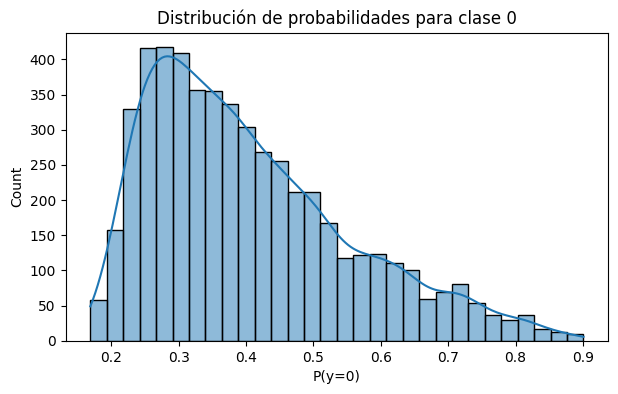

In [ ]:
proba0 = best_xgb.predict_proba(X_test)[:, 0]

plt.figure(figsize=(7,4))
sns.histplot(proba0, bins=30, kde=True)
plt.title("Distribución de probabilidades para clase 0")
plt.xlabel("P(y=0)")
plt.show()

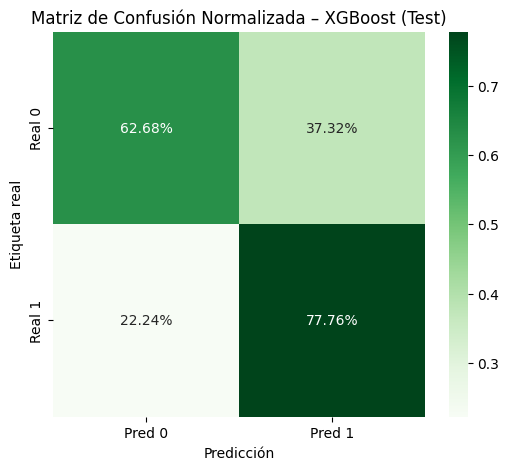

In [ ]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


In [ ]:
def predict_with_threshold(model, X, threshold=0.5):
    probs = model.predict_proba(X)[:, 1]
    return (probs >= threshold).astype(int)

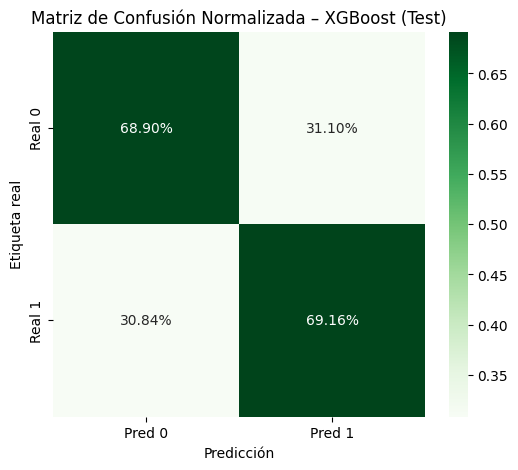

In [ ]:
probs = best_xgb.predict_proba(X)[:, 1]
umbral = 0.5
preds = (probs >= umbral).astype(int)
preds = predict_with_threshold(best_xgb, X_test, threshold=0.55)

cm_norm = confusion_matrix(y_test, preds, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Real 0", "Real 1"])
plt.title("Matriz de Confusión Normalizada – XGBoost (Test)")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()


##### Feature importance

Steps en el pipeline: ['preprocessor', 'model']
Features esperados: 363
Importances entregados: 363

Top 30 Features más importantes:


ERN_PC                     0.050957
UCI_0.0                    0.048089
V246_4                     0.035555
ERN_Peso                   0.033315
AnioParto                  0.028185
CONSULT08                  0.022202
NEURO40_0                  0.021226
Indexnutricion40sem_0      0.019982
V220                       0.019647
V219                       0.018926
tuvotransfusiones_0.0      0.018764
educmadresimplificada_1    0.018502
V204_1                     0.018331
REHOSP08                   0.017692
oftalmopato_2              0.017667
ERN_Talla                  0.017296
DIASTOT08                  0.017082
oftalmologia_2             0.016335
V216                       0.015399
ali40_1                    0.015314
V235                       0.014773
anoxia5mn_0.0              0.014639
V238                       0.014222
CONSULT09                  0.013579
pdpcat_2                   0.013383
ERN_Sexo_2                 0.012697
HD_DiasAlojamiento         0.012582
CP_TP_Orina                0

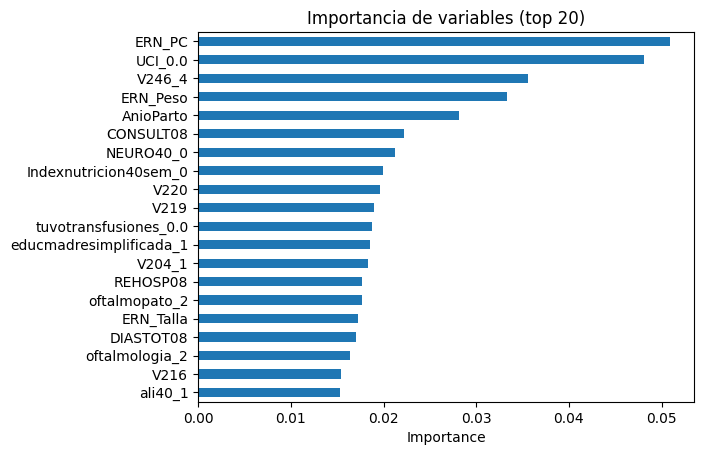

In [ ]:
# Tomar los nombres de los pasos
step_names = list(best_xgb.named_steps.keys())
print("Steps en el pipeline:", step_names)

# Heurística: normalmente el primer step es el preprocesador
# y el último es el modelo
preproc_name = step_names[0]
clf_name     = step_names[-1]

preproc = best_xgb.named_steps[preproc_name]
xgb_best = best_xgb.named_steps[clf_name]

# 1.1 Nombres de columnas numéricas (sin transformar)
num_cols = preproc.transformers_[0][2]

# 1.2 Nombres de columnas categóricas transformadas
ohe = preproc.transformers_[1][1]       # OneHotEncoder
cat_cols = preproc.transformers_[1][2]  # columnas originales categóricas
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# 1.3 Unimos todas las columnas transformadas
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

# 1.4 Importance del modelo
importances = xgb_best.feature_importances_

# Validación por si hay mismatch
print("Features esperados:", len(all_feature_names))
print("Importances entregados:", len(importances))

# Crear tabla ordenada
feat_imp = pd.Series(importances, index=all_feature_names)\
                .sort_values(ascending=False)

print("\nTop 30 Features más importantes:")
display(feat_imp.head(30))


# Gráfico rápido
top_n = 20
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importancia de variables (top 20)")
plt.xlabel("Importance")
plt.show()


##### Guardar modelo

In [ ]:
best_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ERN_PC', 'ERN_Peso',
                                                   'ERN_Talla', 'ERN_Ballard',
                                                   'HD_DiasAlojamiento',
                                                   'DIASTOT08', 'ANOCAT',
                                                   'PA_NumDosisCorticoides',
                                                   'CONSULT08', 'REHOSP08',
                                                   'CP_ARO', 'corticodosis',
                                                   'ecocat', 'CP_edadmaterna',
                                                   'CP_HospitalizacionesPreParto',
                                                   'CP_MesInicCP',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
joblib.dump (best_xgb, "modeloxgb_fase4_infanib.pkl")
print("Modelo guardado como modeloxgb_fase4_infanib.pkl")

Modelo guardado como modeloxgb_fase4_infanib.pkl


In [ ]:
#Cargar modelo
#modelo = joblib.load("modelos_fase1/modeloxgb_fase1_infanib.pkl")